# Introduction
this project is ANN model for battery state estimation with NASA data as it is a sub-project in the electric vehicle architecture and digital twin project.

In [8]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

## NASA data analysis

In [51]:
mat_b5 = loadmat('nasa_data/B0005.mat')
mat_b6 = loadmat('nasa_data/B0006.mat')
mat_b7 = loadmat('nasa_data/B0007.mat')
mat_b18 = loadmat('nasa_data/B0018.mat')
print('dataset5', len(mat_b5['B0005'][0, 0]['cycle'][0]), 
      'dataset6', len(mat_b6['B0006'][0, 0]['cycle'][0]),
     'dataset7', len(mat_b7['B0007'][0, 0]['cycle'][0]),
     'dataset18', len(mat_b18['B0018'][0, 0]['cycle'][0]))

dataset5 616 dataset6 616 dataset7 616 dataset18 319


In [1534]:
charge = mat_b5['B0005'][0, 0]['cycle'][0,0]

In [1535]:
discharge = mat_b5['B0005'][0, 0]['cycle'][0,1]

**Take a look data** </br>
**capacity exists in discharge**

In [1536]:
discharge['data'][0][0]['Capacity']

array([[1.85648742]])

Text(0, 0.5, 'Current load')

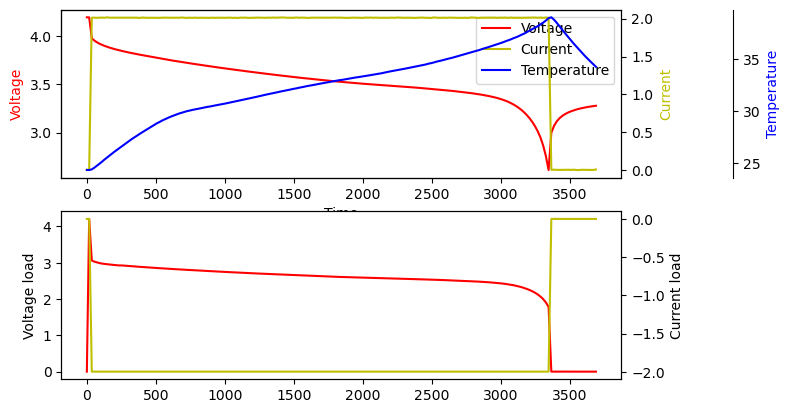

In [1628]:
fig, (ax, ax2) = plt.subplots(2,1)
fig.subplots_adjust(right=1)

current_ax = ax.twinx()
temperature_ax = ax.twinx()


temperature_ax.spines.right.set_position(("axes", 1.2))
#fig.plot(discharge['data'][0][0]['Time'][0])
p1, = ax.plot(discharge['data'][0][0]['Time'][0], discharge['data'][0][0]['Voltage_measured'][0], "r-", label="Voltage")
p2, = current_ax.plot(discharge['data'][0][0]['Time'][0], -discharge['data'][0][0]['Current_measured'][0], "y-", label="Current")
p3, = temperature_ax.plot(discharge['data'][0][0]['Time'][0], discharge['data'][0][0]['Temperature_measured'][0], "b-", label="Temperature")

#ax.set_xlim(0, 2)
#ax.set_ylim(0, 2)
#current_ax.set_ylim(-4, 0)
#temperature_ax.set_ylim(1, 20)

ax.set_xlabel("Time")
ax.set_ylabel("Voltage")
current_ax.set_ylabel("Current")
temperature_ax.set_ylabel("Temperature")

ax.yaxis.label.set_color(p1.get_color())
current_ax.yaxis.label.set_color(p2.get_color())
temperature_ax.yaxis.label.set_color(p3.get_color())

ax.legend(handles=[p1, p2, p3])
#fig2.subplots_adjust(right=0.75)
currentload_ax = ax2.twinx()

ax2.plot(discharge['data'][0][0]['Time'][0], discharge['data'][0][0]['Voltage_load'][0], "r-", label="Voltage load")
currentload_ax.plot(discharge['data'][0][0]['Time'][0], discharge['data'][0][0]['Current_load'][0], "y-", label="Current load")
ax2.set_ylabel("Voltage load")
currentload_ax.set_ylabel("Current load")

Coulomb calculation </br>
Coulomb = ((current_now + current_previous)/2)/(time_now - time_previous) </br>
(current_now + current_previous)/2 is because measurement time inverval is long in data. so i want to make them smooth. </br>
data is measured with constant current. so it is not necessary to use many history data.

# Check cycle data

In [1632]:
b5_cycle_arr = mat_b5['B0005'][0, 0]['cycle'][0,]
b6_cycle_arr = mat_b6['B0006'][0, 0]['cycle'][0,]
b7_cycle_arr = mat_b7['B0007'][0, 0]['cycle'][0,]
b18_cycle_arr = mat_b18['B0018'][0, 0]['cycle'][0,]
print(len(b5_cycle_arr), len(b6_cycle_arr), len(b7_cycle_arr), len(b18_cycle_arr))

616 616 616 319


In [1633]:
print(b5_cycle_arr[0]['type'], cycle_arr[1]['type'])

['charge'] ['discharge']


# check voltage during discarge

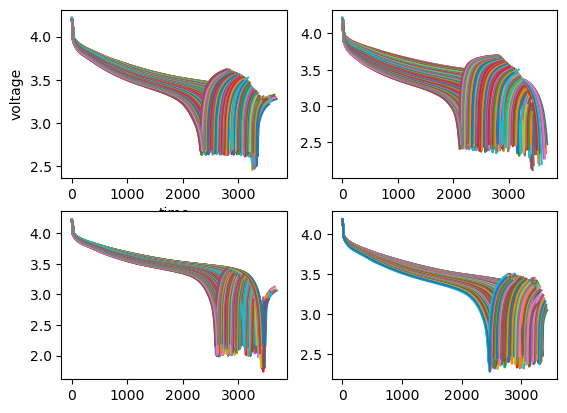

In [1656]:
plt.title('Discharge Voltage')
plt.subplot(221)
for i in range(len(b5_cycle_arr)-1):
    if(b5_cycle_arr[i]['type'] == 'discharge'):
        plt.plot(b5_cycle_arr[i]['data'][0][0]['Time'][0], b5_cycle_arr[i]['data'][0][0]['Voltage_measured'][0])
plt.xlabel("time")
plt.ylabel("voltage")

ax = plt.subplot(222)
for i in range(len(b6_cycle_arr)-1):
    if(b6_cycle_arr[i]['type'] == 'discharge'):
        plt.plot(b6_cycle_arr[i]['data'][0][0]['Time'][0], b6_cycle_arr[i]['data'][0][0]['Voltage_measured'][0])
        
ax = plt.subplot(223)
for i in range(len(b7_cycle_arr)-1):
    if(b7_cycle_arr[i]['type'] == 'discharge'):
        plt.plot(b7_cycle_arr[i]['data'][0][0]['Time'][0], b7_cycle_arr[i]['data'][0][0]['Voltage_measured'][0])        

ax = plt.subplot(224)
for i in range(len(b18_cycle_arr)-1):
    if(b18_cycle_arr[i]['type'] == 'discharge'):
        plt.plot(b18_cycle_arr[i]['data'][0][0]['Time'][0], b18_cycle_arr[i]['data'][0][0]['Voltage_measured'][0])        


# Data is not clean for discharging voltage
1) the discharge is not terminated at exact termination voltage </br>
2) discharge data include non-discharge data. it makes discharge curve jump when stopping discharge.

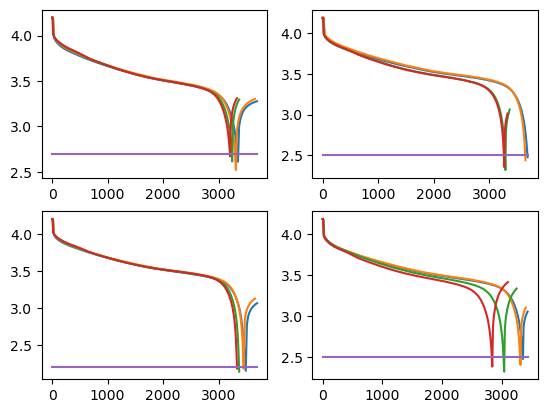

In [1793]:
plt.subplot(221)

plt.plot(b5_cycle_arr[1]['data'][0][0]['Time'][0], b5_cycle_arr[1]['data'][0][0]['Voltage_measured'][0])
plt.plot(b5_cycle_arr[11]['data'][0][0]['Time'][0], b5_cycle_arr[11]['data'][0][0]['Voltage_measured'][0])
plt.plot(b5_cycle_arr[101]['data'][0][0]['Time'][0], b5_cycle_arr[101]['data'][0][0]['Voltage_measured'][0])
plt.plot(b5_cycle_arr[153]['data'][0][0]['Time'][0], b5_cycle_arr[153]['data'][0][0]['Voltage_measured'][0])
last_idx = len(b5_cycle_arr[1]['data'][0][0]['Time'][0]) - 1
plt.plot([0.,b5_cycle_arr[1]['data'][0][0]['Time'][0][last_idx]], [2.7, 2.7])

plt.subplot(222)
plt.plot(b6_cycle_arr[1]['data'][0][0]['Time'][0], b6_cycle_arr[1]['data'][0][0]['Voltage_measured'][0])
plt.plot(b6_cycle_arr[11]['data'][0][0]['Time'][0], b6_cycle_arr[11]['data'][0][0]['Voltage_measured'][0])
plt.plot(b6_cycle_arr[101]['data'][0][0]['Time'][0], b6_cycle_arr[101]['data'][0][0]['Voltage_measured'][0])
plt.plot(b6_cycle_arr[153]['data'][0][0]['Time'][0], b6_cycle_arr[153]['data'][0][0]['Voltage_measured'][0])
last_idx = len(b6_cycle_arr[1]['data'][0][0]['Time'][0]) - 1
plt.plot([0.,b6_cycle_arr[1]['data'][0][0]['Time'][0][last_idx]], [2.5, 2.5])

plt.subplot(223)
plt.plot(b7_cycle_arr[1]['data'][0][0]['Time'][0], b7_cycle_arr[1]['data'][0][0]['Voltage_measured'][0])
plt.plot(b7_cycle_arr[11]['data'][0][0]['Time'][0], b7_cycle_arr[11]['data'][0][0]['Voltage_measured'][0])
plt.plot(b7_cycle_arr[101]['data'][0][0]['Time'][0], b7_cycle_arr[101]['data'][0][0]['Voltage_measured'][0])
plt.plot(b7_cycle_arr[153]['data'][0][0]['Time'][0], b7_cycle_arr[153]['data'][0][0]['Voltage_measured'][0])
last_idx = len(b7_cycle_arr[1]['data'][0][0]['Time'][0]) - 1
plt.plot([0.,b7_cycle_arr[1]['data'][0][0]['Time'][0][last_idx]], [2.2, 2.2])

plt.subplot(224)
plt.plot(b18_cycle_arr[2]['data'][0][0]['Time'][0], b18_cycle_arr[2]['data'][0][0]['Voltage_measured'][0])
plt.plot(b18_cycle_arr[14]['data'][0][0]['Time'][0], b18_cycle_arr[14]['data'][0][0]['Voltage_measured'][0])
plt.plot(b18_cycle_arr[101]['data'][0][0]['Time'][0], b18_cycle_arr[101]['data'][0][0]['Voltage_measured'][0])
plt.plot(b18_cycle_arr[154]['data'][0][0]['Time'][0], b18_cycle_arr[154]['data'][0][0]['Voltage_measured'][0])
last_idx = len(b18_cycle_arr[2]['data'][0][0]['Time'][0]) - 1
plt.plot([0.,b18_cycle_arr[2]['data'][0][0]['Time'][0][last_idx]], [2.5, 2.5])

# check charging voltage
B0005, B0006, B0007 show abnormal charging voltage over 8V. </br>
It looks not intended since their lab report says the charging is performed with 1.5A CC and 4.2V CV

Text(0.5, 1.0, 'Charge Voltage')

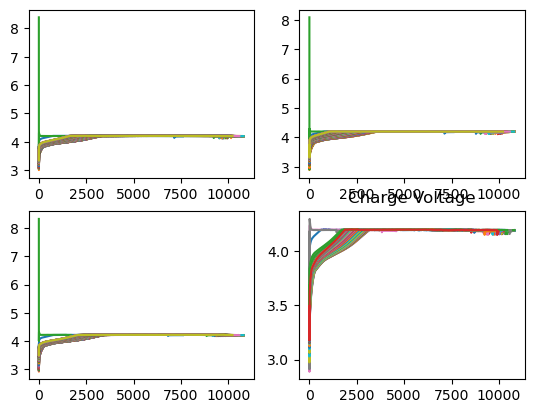

In [1797]:
plt.subplot(221)
#plt.ylim(2.7, 5)
for i in range(len(b5_cycle_arr)-1):
    if(b5_cycle_arr[i]['type'] == 'charge'):
        plt.plot(b5_cycle_arr[i]['data'][0][0]['Time'][0], b5_cycle_arr[i]['data'][0][0]['Voltage_measured'][0])
ax = plt.subplot(222)
#plt.ylim(2.7, 5)
for i in range(len(b6_cycle_arr)-1):
    if(b6_cycle_arr[i]['type'] == 'charge'):
        plt.plot(b6_cycle_arr[i]['data'][0][0]['Time'][0], b6_cycle_arr[i]['data'][0][0]['Voltage_measured'][0])
        
ax = plt.subplot(223)
#plt.ylim(2.7, 5)
for i in range(len(b7_cycle_arr)-1):
    if(b7_cycle_arr[i]['type'] == 'charge'):
        plt.plot(b7_cycle_arr[i]['data'][0][0]['Time'][0], b7_cycle_arr[i]['data'][0][0]['Voltage_measured'][0])        

ax = plt.subplot(224)
#plt.ylim(2.7, 5)
for i in range(len(b18_cycle_arr)-1):
    if(b18_cycle_arr[i]['type'] == 'charge'):
        plt.plot(b18_cycle_arr[i]['data'][0][0]['Time'][0], b18_cycle_arr[i]['data'][0][0]['Voltage_measured'][0])      

plt.title('Charge Voltage')

# Detect abnormal peak voltage during charge

In [1828]:
def detect_abnormal_chgvolt(cycle_arr, charging_volt, cycle_num):
    for i in range(len(cycle_arr)-1):
        if(cycle_arr[i]['type'] == 'charge'):
            for j in range(len(cycle_arr[i]['data'][0][0]['Voltage_measured'][0])):
                if(cycle_arr[i]['data'][0][0]['Voltage_measured'][0][j] >= charging_volt):
                    cycle_num.append(i)
                    break;
                

cycle_num_b5 = []
detect_abnormal_chgvolt(b5_cycle_arr, 4.4, cycle_num_b5)
print(len(cycle_num_b5))
print(cycle_num[0])

cycle_num_b6 = []
detect_abnormal_chgvolt(b6_cycle_arr, 4.4, cycle_num_b6)
print(len(cycle_num_b6))
print(cycle_num_b6[0])

cycle_num_b7 = []
detect_abnormal_chgvolt(b7_cycle_arr, 4.4, cycle_num_b7)
print(len(cycle_num_b7))
print(cycle_num_b7[0])

cycle_num_b18 = []
detect_abnormal_chgvolt(b18_cycle_arr, 4.4, cycle_num_b18)
print(len(cycle_num_b18))

1
84
1
84
1
84
0


# Abnormal peak voltages exist at cycle 84 in B5, B6, and B7.

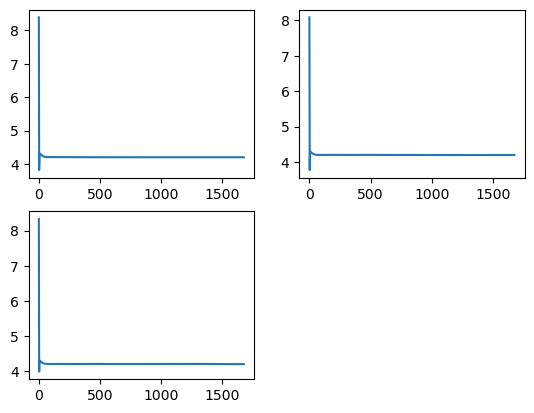

In [1830]:
plt.subplot(221)
plt.plot(b5_cycle_arr[84]['data'][0][0]['Time'][0], b5_cycle_arr[84]['data'][0][0]['Voltage_measured'][0])
plt.subplot(222)
plt.plot(b6_cycle_arr[84]['data'][0][0]['Time'][0], b6_cycle_arr[84]['data'][0][0]['Voltage_measured'][0])
plt.subplot(223)
plt.plot(b7_cycle_arr[84]['data'][0][0]['Time'][0], b7_cycle_arr[84]['data'][0][0]['Voltage_measured'][0])

# Check charging voltages again in limitation of y axis
Voltages are not stable during taper charging. </br>

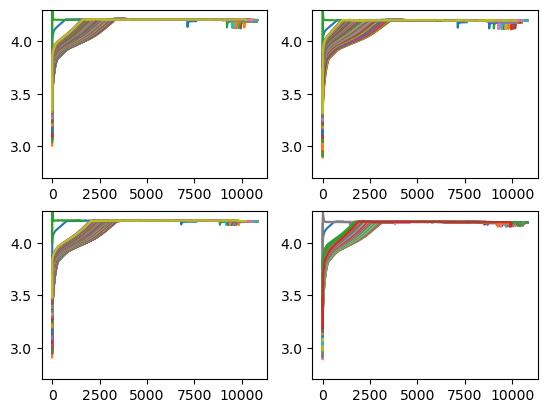

In [1835]:
ax = plt.subplot(221)
plt.ylim(2.7, 4.3)
for i in range(len(b6_cycle_arr)-1):
    if(b5_cycle_arr[i]['type'] == 'charge'):
        plt.plot(b5_cycle_arr[i]['data'][0][0]['Time'][0], b5_cycle_arr[i]['data'][0][0]['Voltage_measured'][0])
ax = plt.subplot(222)
plt.ylim(2.7, 4.3)
for i in range(len(b6_cycle_arr)-1):
    if(b6_cycle_arr[i]['type'] == 'charge'):
        plt.plot(b6_cycle_arr[i]['data'][0][0]['Time'][0], b6_cycle_arr[i]['data'][0][0]['Voltage_measured'][0])
        
ax = plt.subplot(223)
plt.ylim(2.7, 4.3)
for i in range(len(b7_cycle_arr)-1):
    if(b7_cycle_arr[i]['type'] == 'charge'):
        plt.plot(b7_cycle_arr[i]['data'][0][0]['Time'][0], b7_cycle_arr[i]['data'][0][0]['Voltage_measured'][0])        

ax = plt.subplot(224)
plt.ylim(2.7, 4.3)
for i in range(len(b18_cycle_arr)-1):
    if(b18_cycle_arr[i]['type'] == 'charge'):
        plt.plot(b18_cycle_arr[i]['data'][0][0]['Time'][0], b18_cycle_arr[i]['data'][0][0]['Voltage_measured'][0])      

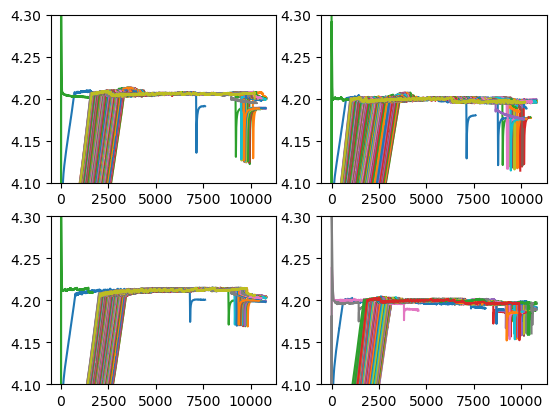

In [1837]:
ax = plt.subplot(221)
plt.ylim(4.1, 4.3)
for i in range(len(b6_cycle_arr)-1):
    if(b5_cycle_arr[i]['type'] == 'charge'):
        plt.plot(b5_cycle_arr[i]['data'][0][0]['Time'][0], b5_cycle_arr[i]['data'][0][0]['Voltage_measured'][0])
ax = plt.subplot(222)
plt.ylim(4.1, 4.3)
for i in range(len(b6_cycle_arr)-1):
    if(b6_cycle_arr[i]['type'] == 'charge'):
        plt.plot(b6_cycle_arr[i]['data'][0][0]['Time'][0], b6_cycle_arr[i]['data'][0][0]['Voltage_measured'][0])
        
ax = plt.subplot(223)
plt.ylim(4.1, 4.3)
for i in range(len(b7_cycle_arr)-1):
    if(b7_cycle_arr[i]['type'] == 'charge'):
        plt.plot(b7_cycle_arr[i]['data'][0][0]['Time'][0], b7_cycle_arr[i]['data'][0][0]['Voltage_measured'][0])        

ax = plt.subplot(224)
plt.ylim(4.1, 4.3)
for i in range(len(b18_cycle_arr)-1):
    if(b18_cycle_arr[i]['type'] == 'charge'):
        plt.plot(b18_cycle_arr[i]['data'][0][0]['Time'][0], b18_cycle_arr[i]['data'][0][0]['Voltage_measured'][0])     

# Summary of charing voltagte data
there are some problems since their lab report says the charging is performed with 1.5A CC and 4.2V CV </br>
1) B0005, B0006, B0007 show abnormal charging voltage over 8V at 84-th cycle. </br>
2) taper voltages are not stable </br>
# Thus, data during charging cycle cannot be trusted and discharge data will be used


## Reshape discharge data

In [1666]:
coulomb = ((discharge['data'][0][0]['Current_measured'][0][0]+discharge['data'][0][0]['Current_measured'][0][1])/2)*(discharge['data'][0][0]['Time'][0][1]-discharge['data'][0][0]['Time'][0][0])/3600
coulomb

-1.486888606285338e-05

In [1988]:
def reshape_discharge_data(cycle_arr, term_voltage):
    discharge_arr = []
    voltage = []
    current = []
    temperature = []
    current_load = []
    voltage_load = []
    time = []
    counter = 0
    
    for i in range(len(cycle_arr)-1):
        if(cycle_arr[i]['type'] == 'discharge'):
            voltage = cycle_arr[i]['data'][0][0]['Voltage_measured'][0]
            current = cycle_arr[i]['data'][0][0]['Current_measured'][0]
            temperature = cycle_arr[i]['data'][0][0]['Temperature_measured'][0]
            current_load = cycle_arr[i]['data'][0][0]['Current_load'][0]
            voltage_load = cycle_arr[i]['data'][0][0]['Voltage_load'][0]
            time = cycle_arr[i]['data'][0][0]['Time'][0]
            capacity = cycle_arr[i]['data'][0][0]['Capacity'][0][0]
            
            counter = counter + 1
            coulomb = []
            acc_capacity_list = []
            acc_capacity = 0.0
            coulomb.append(0.0)
            acc_capacity_list.append(0.0)
            coulomb_capacity = 0.0
            acc_flag = 1 # after discharging stop, prevent increasing capacity from voltage jump
            #print(len(time))
            for j in range(1, len(time)):
                coulomb.append((((current[j]+current[j-1])/2)*(time[j]-time[j-1]))/3600.0)
                acc_capacity = acc_capacity + coulomb[j]
                acc_capacity_list.append(acc_capacity)
                if voltage[j] < term_voltage and acc_flag: #record and prevent re-recording from voltage jump when stopping discharge.
                    coulomb_capacity = acc_capacity
                    #print(voltage[j], current[j], (current[j]+current[j-1])/2, coulomb[j], coulomb_capacity)
                    acc_flag = 0
            discharge_arr.append([counter, capacity, coulomb_capacity, 
                                  voltage, current, temperature, coulomb, current_load, voltage_load, time, acc_capacity_list])

            
    return discharge_arr

# Why the numbers of data sizes of 5, 6, and 7 are small up to 50 cycles
Lab report: Discharge was carried out at a constant current (CC) level of 2A until the battery voltage fell to 2.7V, 2.5V, 2.2V and 2.5V for batteries 5 6 7 and 18 respectively. 

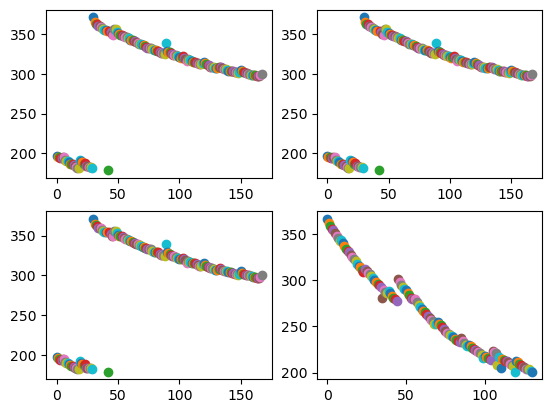

In [1989]:
plt.subplot(221)
b5_discharge = reshape_discharge_data(b5_cycle_arr, 2.7)
for i in range(len(b5_discharge)):
    plt.plot(i, len(b5_discharge[i][9]), 'o')
plt.subplot(222)
b6_discharge = reshape_discharge_data(b6_cycle_arr, 2.5)
for i in range(len(b6_discharge)):
    plt.plot(i, len(b6_discharge[i][9]), 'o')
plt.subplot(223)
b7_discharge = reshape_discharge_data(b7_cycle_arr, 2.2)
for i in range(len(b7_discharge)):
    plt.plot(i, len(b7_discharge[i][9]), 'o')
plt.subplot(224)
b18_discharge = reshape_discharge_data(b18_cycle_arr, 2.5)
for i in range(len(b18_discharge)):
    plt.plot(i, len(b18_discharge[i][9]), 'o')
    

# Accumulated capacity at each cycle.

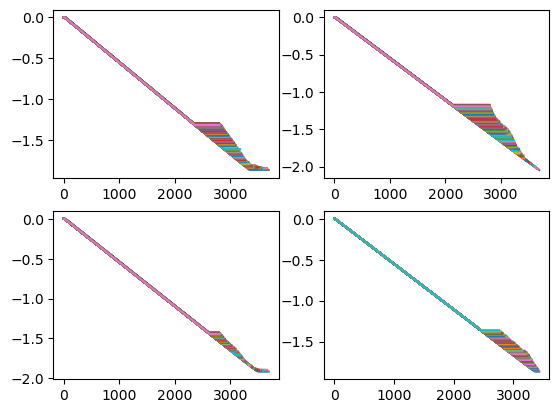

In [1990]:
plt.subplot(221)
for i in range(len(b5_discharge)-1):
    plt.plot(b5_discharge[i][9], b5_discharge[i][10])
plt.subplot(222)
for i in range(len(b6_discharge)-1):
    plt.plot(b6_discharge[i][9], b6_discharge[i][10])
plt.subplot(223)
for i in range(len(b7_discharge)-1):
    plt.plot(b7_discharge[i][9], b7_discharge[i][10])
plt.subplot(224)
for i in range(len(b18_discharge)-1):
    plt.plot(b18_discharge[i][9], b18_discharge[i][10])

# Compare capacity between NASA capacity and accumulated capacity
they are the same.
So, NASA capacity is made also accumulated capacity until termination voltage.

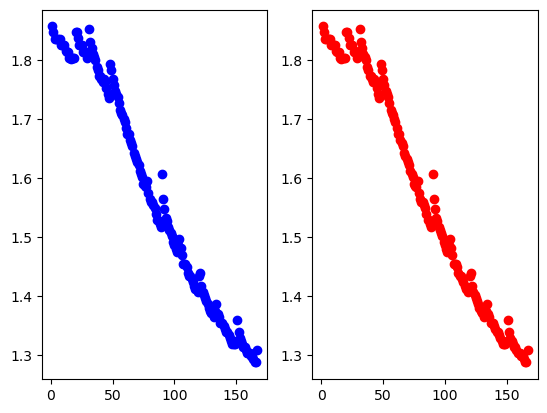

In [1992]:
for i in range(len(b5_discharge)-1):
    plt.subplot(1,2,1)
    plt.plot(b5_discharge[i][0], b5_discharge[i][1], 'bo')
    plt.subplot(1,2,2)
    plt.plot(b5_discharge[i][0], -b5_discharge[i][2], 'ro')

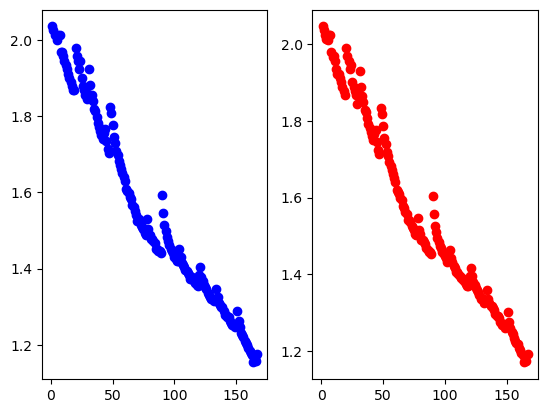

In [1993]:
for i in range(len(b6_discharge)-1):
    plt.subplot(1,2,1)
    plt.plot(b6_discharge[i][0], b6_discharge[i][1], 'bo')
    plt.subplot(1,2,2)
    plt.plot(b6_discharge[i][0], -b6_discharge[i][2], 'ro')

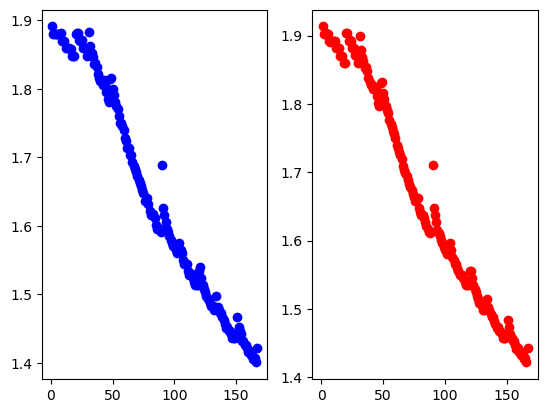

In [1995]:
for i in range(len(b7_discharge)-1):
    plt.subplot(1,2,1)
    plt.plot(b7_discharge[i][0], b7_discharge[i][1], 'bo')
    plt.subplot(1,2,2)
    plt.plot(b7_discharge[i][0], -b7_discharge[i][2], 'ro')

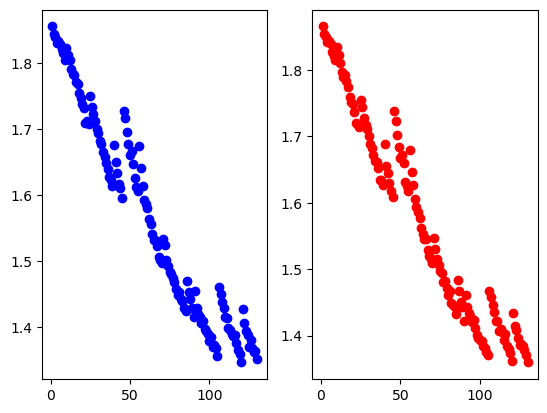

In [1996]:
for i in range(len(b18_discharge)-1):
    plt.subplot(1,2,1)
    plt.plot(b18_discharge[i][0], b18_discharge[i][1], 'bo')
    plt.subplot(1,2,2)
    plt.plot(b18_discharge[i][0], -b18_discharge[i][2], 'ro')

# capacity fade by cycles

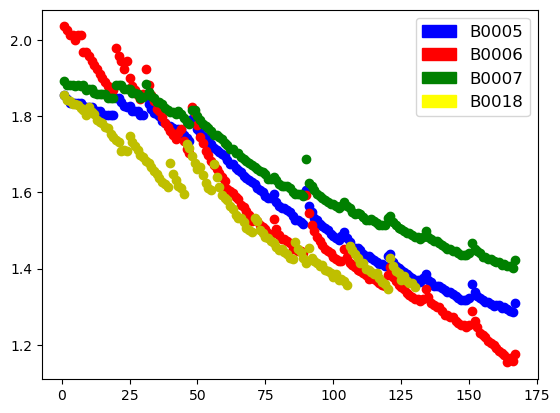

In [1999]:
for i in range(len(b5_discharge)-1):
    plt.plot([b5_discharge[i][0]], [b5_discharge[i][1]], 'bo')
for i in range(len(b6_discharge)-1):
    plt.plot([b6_discharge[i][0]], [b6_discharge[i][1]], 'ro')
for i in range(len(b7_discharge)-1):
    plt.plot([b7_discharge[i][0]], [b7_discharge[i][1]], 'go')  
for i in range(len(b18_discharge)-1):
    plt.plot([b18_discharge[i][0]], [b18_discharge[i][1]], 'yo')
#plt.legend(['B0005', 'B0006', 'B0007', 'B0018'], color=['blue','red','green','yellow'])

legend_b0005 = mpatches.Patch(color='blue',label='B0005')
legend_b0006 = mpatches.Patch(color='red',label='B0006')
legend_b0007 = mpatches.Patch(color='green',label='B0007')
legend_b0018 = mpatches.Patch(color='yellow',label='B0018')
plt.legend(handles=[legend_b0005, legend_b0006, legend_b0007,legend_b0018], 
           loc ='upper right', frameon=True, fontsize = 12,
         facecolor='white', labelcolor='black',
          bbox_to_anchor=(1, 1))

# SOH target calculation
SOH target = present capacity/initial capacity

In [2001]:
def SOH_target_calculation(discharge_arr):
    SOH_target = []
    initial_capacity = discharge_arr[0][1]
    for i in range(len(discharge_arr)-1):
        cycle = discharge_arr[i][0]
        capacity = discharge_arr[i][1]
        SOH = capacity/initial_capacity
        SOH_target.append([cycle, capacity, SOH])
    return pd.DataFrame(data=SOH_target, columns=['cycle', 'capacity', 'SOH'])

In [2002]:
b5_SOH_target = SOH_target_calculation(b5_discharge)
b5_SOH_target

cycle  capacity       SOH
0        1  1.856487  1.000000
1        2  1.846327  0.994527
2        3  1.835349  0.988614
3        4  1.835263  0.988567
4        5  1.834646  0.988235
..     ...       ...       ...
162    163  1.298074  0.699209
163    164  1.293464  0.696726
164    165  1.288003  0.693785
165    166  1.287453  0.693488
166    167  1.309015  0.705103

[167 rows x 3 columns]

# SOH is also jumped due to capacity jumping

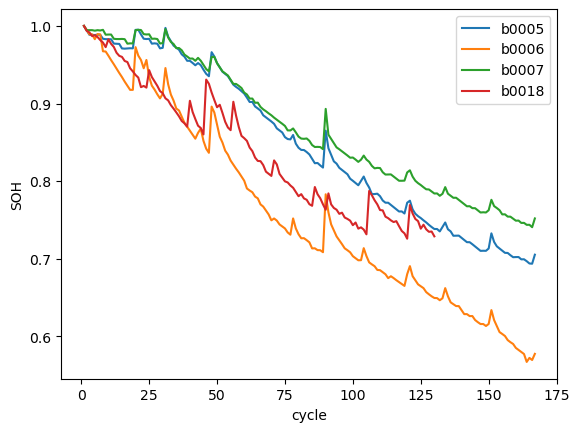

In [2004]:
b6_SOH_target = SOH_target_calculation(b6_discharge)
b7_SOH_target = SOH_target_calculation(b7_discharge)
b18_SOH_target = SOH_target_calculation(b18_discharge)
plt.plot(b5_SOH_target['cycle'], b5_SOH_target['SOH'])
plt.plot(b6_SOH_target['cycle'], b6_SOH_target['SOH'])
plt.plot(b7_SOH_target['cycle'], b7_SOH_target['SOH'])
plt.plot(b18_SOH_target['cycle'], b18_SOH_target['SOH'])
plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['b0005', 'b0006', 'b0007', 'b0018'])

# Data cleansing for discharging votlages

In [2039]:
def cleansing_discharge_data(discharge_arr, term_voltage):
    cleaned_discharge_arr = []
    counter = 0
    for i in range(len(discharge_arr)-1):
        voltage = []
        current = []
        temperature = []
        current_load = []
        voltage_load = []
        time = []
    
        voltage.append(discharge_arr[i][3][0])
        current.append(discharge_arr[i][4][0])
        temperature.append(discharge_arr[i][5][0])
        current_load.append(discharge_arr[i][6][0])
        voltage_load.append(discharge_arr[i][7][0])
        time.append(discharge_arr[i][9][0])
        capacity = discharge_arr[i][1]
            
        counter = counter + 1
        coulomb = []
        acc_capacity_list = []
        acc_capacity = 0.0
        coulomb.append(0.0)
        acc_capacity_list.append(0.0)
        coulomb_capacity = 0.0
        #print(len(time))
        for j in range(1, len(discharge_arr[i][9])):
            voltage.append(discharge_arr[i][3][j])
            current.append(discharge_arr[i][4][j])
            temperature.append(discharge_arr[i][5][j])
            current_load.append(discharge_arr[i][7][j])
            voltage_load.append(discharge_arr[i][8][j])
            time.append(discharge_arr[i][9][j])
            coulomb.append((((current[j]+current[j-1])/2)*(time[j]-time[j-1]))/3600.0)
            coulomb_capacity = coulomb_capacity + coulomb[j]
            acc_capacity_list.append(coulomb_capacity)
            if discharge_arr[i][3][j] < term_voltage: #record and prevent re-recording from voltage jump when stopping discharge.
                #print(j, len(discharge_arr[i][9]), voltage[j], current[j], (current[j]+current[j-1])/2, coulomb[j], acc_capacity)
                #plt.plot(time, voltage)
                break
        cleaned_discharge_arr.append([counter, capacity, coulomb_capacity, 
                              voltage, current, temperature, coulomb, current_load, voltage_load, time, acc_capacity_list])

            
    return cleaned_discharge_arr

In [2052]:
b5_discharge_cleaned = cleansing_discharge_data(b5_discharge, 2.7)
b6_discharge_cleaned = cleansing_discharge_data(b6_discharge, 2.5)
b7_discharge_cleaned = cleansing_discharge_data(b7_discharge, 2.2)
b18_discharge_cleaned = cleansing_discharge_data(b18_discharge, 2.5)

# cleaned data size at each cycle

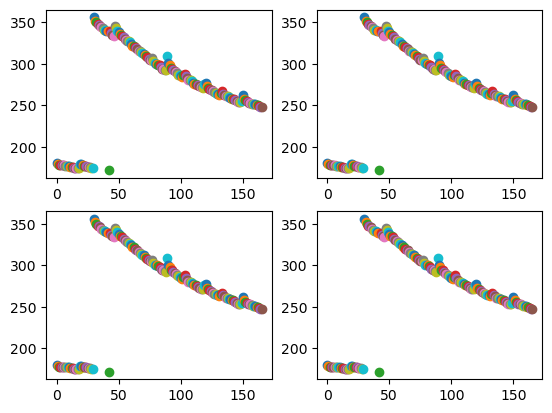

In [2053]:
plt.subplot(221)
for i in range(len(b5_discharge_cleaned)-1):
    plt.plot(i, len(b5_discharge_cleaned[i][9]), 'o')
plt.subplot(222)
for i in range(len(b5_discharge_cleaned)-1):
    plt.plot(i, len(b5_discharge_cleaned[i][9]), 'o')
plt.subplot(223)
for i in range(len(b5_discharge_cleaned)-1):
    plt.plot(i, len(b5_discharge_cleaned[i][9]), 'o')
plt.subplot(224)
for i in range(len(b5_discharge_cleaned)-1):
    plt.plot(i, len(b5_discharge_cleaned[i][9]), 'o')

# cleand discharging voltages at each cycle

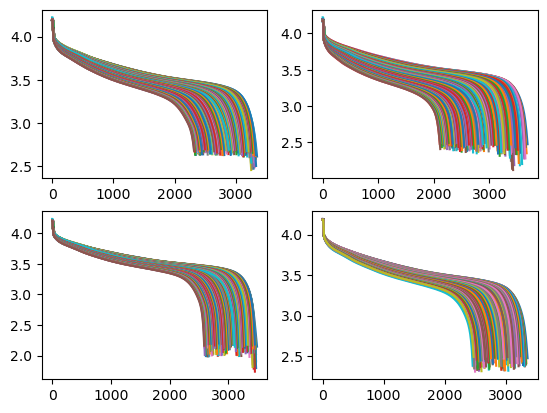

In [2054]:
plt.subplot(221)
for i in range(len(b5_discharge_cleaned)-1):
    plt.plot(b5_discharge_cleaned[i][9], b5_discharge_cleaned[i][3])

plt.subplot(222)
for i in range(len(b6_discharge_cleaned)-1):
    plt.plot(b6_discharge_cleaned[i][9], b6_discharge_cleaned[i][3])
        
plt.subplot(223)
for i in range(len(b7_discharge_cleaned)-1):
    plt.plot(b7_discharge_cleaned[i][9], b7_discharge_cleaned[i][3])

plt.subplot(224)
for i in range(len(b18_discharge_cleaned)-1):
    plt.plot(b18_discharge_cleaned[i][9], b18_discharge_cleaned[i][3])

# In perspective of voltage condition, b7 is most severe condition
# However, capacity fade of B7 is the slowest
Thus, i can expect B7 is different type from others.

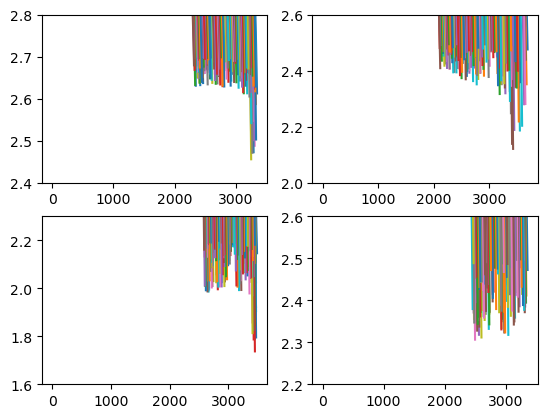

In [2092]:
plt.subplot(221)
plt.ylim(2.4, 2.8)
for i in range(len(b5_discharge_cleaned)-1):
    plt.plot(b5_discharge_cleaned[i][9], b5_discharge_cleaned[i][3])

plt.subplot(222)
plt.ylim(2.0, 2.6)
for i in range(len(b6_discharge_cleaned)-1):
    plt.plot(b6_discharge_cleaned[i][9], b6_discharge_cleaned[i][3])
        
plt.subplot(223)
plt.ylim(1.6, 2.3)
for i in range(len(b7_discharge_cleaned)-1):
    plt.plot(b7_discharge_cleaned[i][9], b7_discharge_cleaned[i][3])

plt.subplot(224)
plt.ylim(2.2, 2.6)
for i in range(len(b18_discharge_cleaned)-1):
    plt.plot(b18_discharge_cleaned[i][9], b18_discharge_cleaned[i][3])

# Cleaned accumlated capacity at each cycle

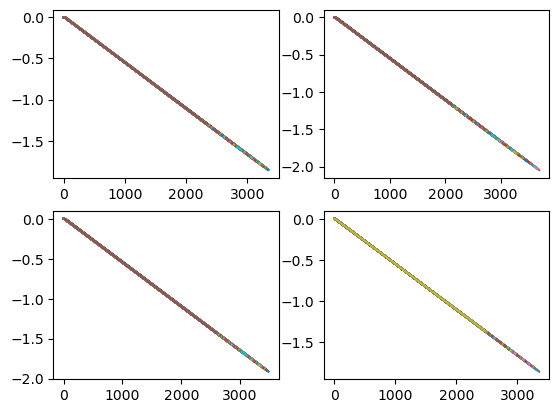

In [2055]:
plt.subplot(221)
for i in range(len(b5_discharge_cleaned)-1):
    plt.plot(b5_discharge_cleaned[i][9], b5_discharge_cleaned[i][10])
plt.subplot(222)
for i in range(len(b6_discharge_cleaned)-1):
    plt.plot(b6_discharge_cleaned[i][9], b6_discharge_cleaned[i][10])
plt.subplot(223)
for i in range(len(b7_discharge_cleaned)-1):
    plt.plot(b7_discharge_cleaned[i][9], b7_discharge_cleaned[i][10])
plt.subplot(224)
for i in range(len(b18_discharge_cleaned)-1):
    plt.plot(b18_discharge_cleaned[i][9], b18_discharge_cleaned[i][10])

# Compare original capacity in NASA dataset with accumulated coulomb of cleaned data

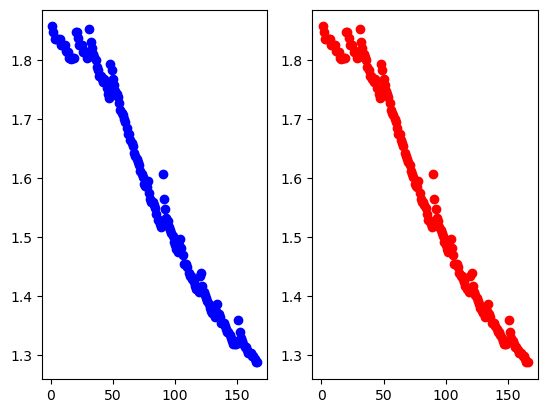

In [2056]:
for i in range(len(b5_discharge_cleaned)-1):
    plt.subplot(1,2,1)
    plt.plot(b5_discharge_cleaned[i][0], b5_discharge_cleaned[i][1], 'bo')
    plt.subplot(1,2,2)
    plt.plot(b5_discharge_cleaned[i][0], -b5_discharge_cleaned[i][2], 'ro')

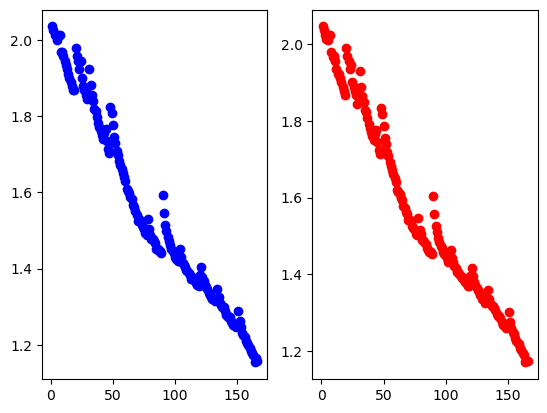

In [2057]:
for i in range(len(b6_discharge_cleaned)-1):
    plt.subplot(1,2,1)
    plt.plot(b6_discharge_cleaned[i][0], b6_discharge_cleaned[i][1], 'bo')
    plt.subplot(1,2,2)
    plt.plot(b6_discharge_cleaned[i][0], -b6_discharge_cleaned[i][2], 'ro')


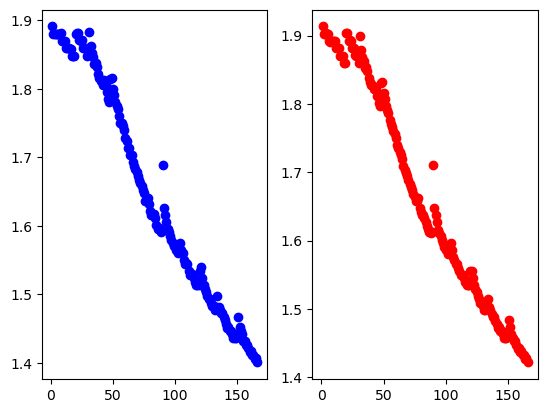

In [2058]:
for i in range(len(b7_discharge_cleaned)-1):
    plt.subplot(1,2,1)
    plt.plot([b7_discharge_cleaned[i][0]], [b7_discharge_cleaned[i][1]], 'bo')
    plt.subplot(1,2,2)
    plt.plot([b7_discharge_cleaned[i][0]], [-b7_discharge_cleaned[i][2]], 'ro')

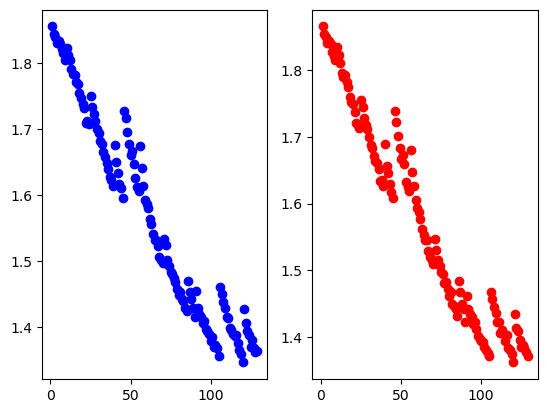

In [2059]:
for i in range(len(b18_discharge_cleaned)-1):
    plt.subplot(1,2,1)
    plt.plot([b18_discharge_cleaned[i][0]], [b18_discharge_cleaned[i][1]], 'bo')
    plt.subplot(1,2,2)
    plt.plot([b18_discharge_cleaned[i][0]], [-b18_discharge_cleaned[i][2]], 'ro')

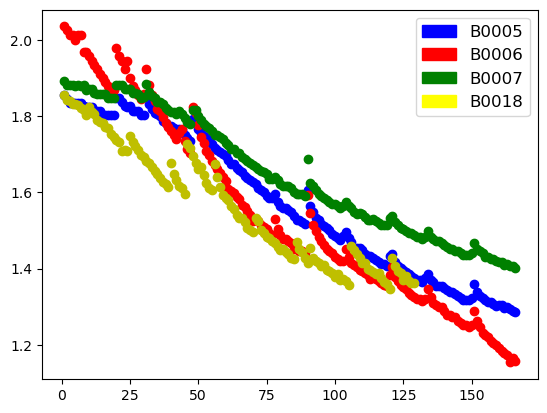

In [2060]:
import matplotlib.patches as mpatches

for i in range(len(b5_discharge_cleaned)-1):
    plt.plot([b5_discharge_cleaned[i][0]], [b5_discharge_cleaned[i][1]], 'bo')
for i in range(len(b6_discharge_cleaned)-1):
    plt.plot([b6_discharge_cleaned[i][0]], [b6_discharge_cleaned[i][1]], 'ro')
for i in range(len(b7_discharge_cleaned)-1):
    plt.plot([b7_discharge_cleaned[i][0]], [b7_discharge_cleaned[i][1]], 'go')  
for i in range(len(b18_discharge_cleaned)-1):
    plt.plot([b18_discharge_cleaned[i][0]], [b18_discharge_cleaned[i][1]], 'yo')
#plt.legend(['B0005', 'B0006', 'B0007', 'B0018'], color=['blue','red','green','yellow'])

legend_b0005 = mpatches.Patch(color='blue',label='B0005')
legend_b0006 = mpatches.Patch(color='red',label='B0006')
legend_b0007 = mpatches.Patch(color='green',label='B0007')
legend_b0018 = mpatches.Patch(color='yellow',label='B0018')
plt.legend(handles=[legend_b0005, legend_b0006, legend_b0007,legend_b0018], 
           loc ='upper right', frameon=True, fontsize = 12,
         facecolor='white', labelcolor='black',
          bbox_to_anchor=(1, 1))

In [2061]:
b5_SOH_target_cleaned = SOH_target_calculation(b5_discharge_cleaned)
b5_SOH_target_cleaned

cycle  capacity       SOH
0        1  1.856487  1.000000
1        2  1.846327  0.994527
2        3  1.835349  0.988614
3        4  1.835263  0.988567
4        5  1.834646  0.988235
..     ...       ...       ...
161    162  1.297887  0.699109
162    163  1.298074  0.699209
163    164  1.293464  0.696726
164    165  1.288003  0.693785
165    166  1.287453  0.693488

[166 rows x 3 columns]

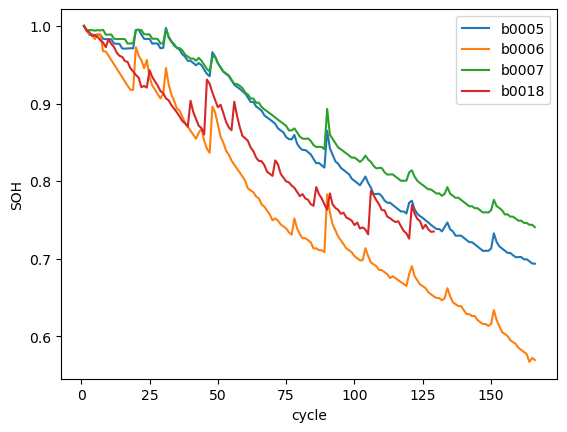

In [2062]:
b6_SOH_target_cleaned = SOH_target_calculation(b6_discharge_cleaned)
b7_SOH_target_cleaned = SOH_target_calculation(b7_discharge_cleaned)
b18_SOH_target_cleaned = SOH_target_calculation(b18_discharge_cleaned)
plt.plot(b5_SOH_target_cleaned['cycle'], b5_SOH_target_cleaned['SOH'])
plt.plot(b6_SOH_target_cleaned['cycle'], b6_SOH_target_cleaned['SOH'])
plt.plot(b7_SOH_target_cleaned['cycle'], b7_SOH_target_cleaned['SOH'])
plt.plot(b18_SOH_target_cleaned['cycle'], b18_SOH_target_cleaned['SOH'])
plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['b0005', 'b0006', 'b0007', 'b0018'])

# Conclusion for NASA data analysis
1) B0005, B0006, B0007 show abnormal charging voltage over 8V at 84-th cycle. </br>
2) voltages are not stable during taper charging </br>
3) the number of data sizes are big gap between before 50 cycles and after 50 cycles. </br>
4) discharging volages are not clean since data include jump voltage after stopping discharge. </br>
**5) why B0007 show that capacity fade is slowest? According to lab report, B0007 is tested under worst condition that discharging termination voltage is 2.2V. it looks like cell type of B0007 is different from others** </br>

However, many researchers have studied with NASA dataset. So, let me try writing ANN model with NASA dataset.

# Hypotheis: 
1) ANN model will show better training performance with cleaned data <br>
2) B0007 looks like different type cell from others. so we can compare tests that one include B0007 and anohter exclude B0007. </br>
3) In perspective of capacity fade pattern, training with b5 looks good. In perspective of termination voltage, training with b7 looks good. Training data will affect model performance to predict SOH of other battery data.
Previous studies trained models without cleasing data. </br>

# Cleasning data

In [2064]:
def inout_dataframe(discharge_arr, term_voltage):
    SOH_target = []
    input_features = []
    initial_capacity = discharge_arr[0][1]
    for i in range(len(discharge_arr)-1):
        cycle = discharge_arr[i][0]
        capacity = discharge_arr[i][1]
        SOH = capacity/initial_capacity
        for j in range(len(discharge_arr[i][3])):
            voltage = discharge_arr[i][3][j]
            current = discharge_arr[i][4][j]
            temperature = discharge_arr[i][5][j]
            coulomb = discharge_arr[i][6][j]
            time = discharge_arr[i][9][j]
            acc_cap = discharge_arr[i][10][j]
            
            if voltage >= term_voltage:
                SOH_target.append(SOH)
                input_features.append([cycle, capacity, voltage, current, temperature, coulomb, time, acc_cap])
            else:
                break
            
    return [pd.DataFrame(data=SOH_target, columns=['SOH']), 
            pd.DataFrame(data=input_features, columns=['cycle', 'capacity', 'voltage', 'current', 'temperature', 'coulomb', 'time', 'accumulated_capacity'])]

            #discharge_arr.append([counter, capacity, coulomb_capacity, 
                                  #voltage, current, temperature, coulomb, current_load, voltage_load, time])

# Work with non-cleaned data

In [2519]:
b5_SOH_target, b5_inputs = inout_dataframe(b5_discharge, 2.7)
b6_SOH_target, b6_inputs = inout_dataframe(b6_discharge, 2.5)
b7_SOH_target, b7_inputs = inout_dataframe(b7_discharge, 2.2)
b18_SOH_target, b18_inputs = inout_dataframe(b18_discharge, 2.5)

b5_SOH_target_cleaned, b5_inputs_cleaned = inout_dataframe(b5_discharge_cleaned, 2.7)
b6_SOH_target_cleaned, b6_inputs_cleaned = inout_dataframe(b6_discharge_cleaned, 2.5)
b7_SOH_target_cleaned, b7_inputs_cleaned = inout_dataframe(b7_discharge_cleaned, 2.2)
b18_SOH_target_cleaned, b18_inputs_cleaned = inout_dataframe(b18_discharge_cleaned, 2.5)

print(b5_SOH_target.shape, b5_inputs.shape)

(45036, 1) (45036, 8)


In [2067]:
b5_SOH_target

SOH
0      1.000000
1      1.000000
2      1.000000
3      1.000000
4      1.000000
...         ...
45031  0.705103
45032  0.705103
45033  0.705103
45034  0.705103
45035  0.705103

[45036 rows x 1 columns]

In [2523]:
b5_inputs

cycle  capacity   voltage   current  temperature   coulomb      time  \
0          1  1.856487  4.191492 -0.004902    24.330034  0.000000     0.000   
1          1  1.856487  4.190749 -0.001478    24.325993 -0.000015    16.781   
2          1  1.856487  3.974871 -2.012528    24.389085 -0.005293    35.703   
3          1  1.856487  3.951717 -2.013979    24.544752 -0.010110    53.781   
4          1  1.856487  3.934352 -2.011144    24.731385 -0.010142    71.922   
...      ...       ...       ...       ...          ...       ...       ...   
45031    167  1.309015  2.896440 -2.011362    40.302149 -0.005318  2308.016   
45032    167  1.309015  2.866654 -2.014975    40.404162 -0.005347  2317.578   
45033    167  1.309015  2.831597 -2.011871    40.501529 -0.005348  2327.141   
45034    167  1.309015  2.790443 -2.011597    40.649221 -0.005274  2336.578   
45035    167  1.309015  2.740493 -2.014447    40.778508 -0.005295  2346.047   

       accumulated_capacity  
0                  0.000000  
1                 -0.000015  
2                 -0.005308  
3                 -0.015418  
4                 -0.025559  
...                     ...  
45031             -1.282401  
45032             -1.287749  
45033             -1.293097  
45034             -1.298371  
45035             -1.303665  

[45036 rows x 8 columns]

In [2071]:
last = len(b5_SOH_target['SOH'])-1
print(b5_SOH_target['SOH'][last], b5_inputs['voltage'][last])

0.705103277055252 2.740493324451625


## create train data

In [2077]:
def create_train_data(attributes, inputs, targets):
    train_inputs = inputs[attributes]
    scale = MinMaxScaler(feature_range=(0,1))
    train_inputs  = scale.fit_transform(train_inputs)
    train_targets  = targets.to_numpy()
    last = len(train_targets)-1
    print(train_targets[last], train_inputs[last][0], inputs['voltage'][last])
    return train_inputs, train_targets

In [2078]:
input_attributes = ['voltage', 'current', 'temperature', 'coulomb', 'time']
b5_train_inputs, b5_train_SOH = create_train_data(input_attributes, b5_inputs, b5_SOH_target)

[0.70510328] 0.02627202702865672 2.740493324451625


In [2074]:
b6_train_inputs, b6_train_SOH = create_train_data(input_attributes, b6_inputs, b6_SOH_target)

[0.57728747] 0.03297634809815464 2.5576952469008285


In [2075]:
b7_train_inputs, b7_train_SOH = create_train_data(input_attributes, b7_inputs, b7_SOH_target)

[0.75184938] 0.0132320260218306 2.2279347416731947


In [2076]:
b18_train_inputs, b7_train_SOH = create_train_data(input_attributes, b7_inputs, b7_SOH_target)

[0.75184938] 0.0132320260218306 2.2279347416731947


In [2459]:
b5_train_inputs_cleaned, b5_train_SOH_cleaned = create_train_data(input_attributes, b5_inputs_cleaned, b5_SOH_target_cleaned)

[0.69348842] 0.026592460210996816 2.740981159585237


In [2460]:
b6_train_inputs_cleaned, b6_train_SOH_cleaned = create_train_data(input_attributes, b6_inputs_cleaned, b6_SOH_target_cleaned)

[0.56933921] 0.0009649713577821739 2.502584690743227


In [2461]:
b7_train_inputs_cleaned, b7_train_SOH_cleaned = create_train_data(input_attributes, b7_inputs_cleaned, b7_SOH_target_cleaned)

[0.74056928] 0.08328817228087115 2.3703085797709997


In [2462]:
b18_train_inputs_cleaned, b18_train_SOH_cleaned = create_train_data(input_attributes, b18_inputs_cleaned, b18_SOH_target_cleaned)

[0.73498749] 0.08344414613269935 2.6439672118526083


In [1694]:
b6_train_SOH

array([[1.        ],
       [1.        ],
       [1.        ],
       ...,
       [0.57728747],
       [0.57728747],
       [0.57728747]])

In [1695]:
b6_train_inputs

array([[0.97518774, 0.99652212, 0.05775097, 0.99965645, 0.        ],
       [0.97520134, 0.99790031, 0.05772445, 0.9992633 , 0.00457264],
       [0.85130755, 0.00628818, 0.06250812, 0.5376984 , 0.00972867],
       ...,
       [0.10871747, 0.0087446 , 0.93375556, 0.54376244, 0.57716107],
       [0.07392616, 0.00782965, 0.94352881, 0.54194231, 0.57972002],
       [0.03297635, 0.00733631, 0.9493982 , 0.54317734, 0.58227024]])

# Feature analysis

In [2545]:
from sklearn.model_selection import train_test_split
import seaborn as sns

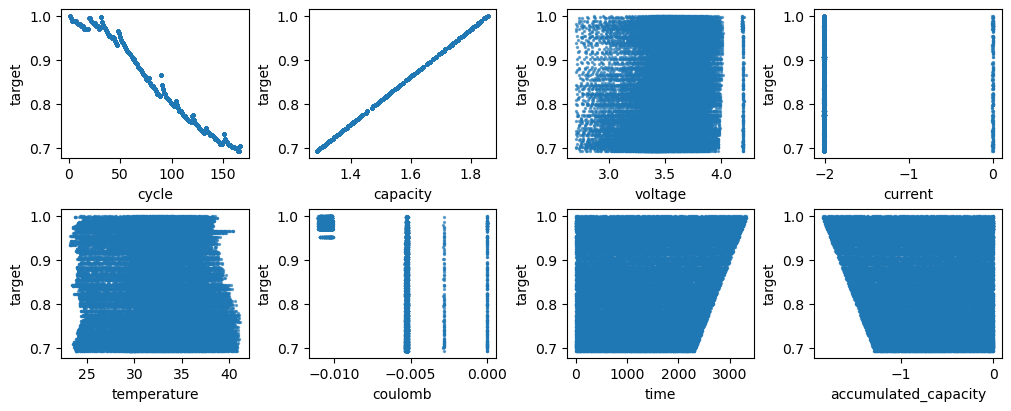

In [2557]:
x_train, x_test, y_train, y_test = train_test_split(b5_inputs, b5_SOH_target)

df_train = x_train.copy()
df_train['target'] = y_train

fig, axes = plt.subplots(2, 4, constrained_layout=True, figsize=(10, 4))
for col, ax in zip(b7_inputs.columns, axes.ravel()):
    df_train.plot(x=col, y='target', kind='scatter', ax=ax, legend=False, s=2, alpha=.6)

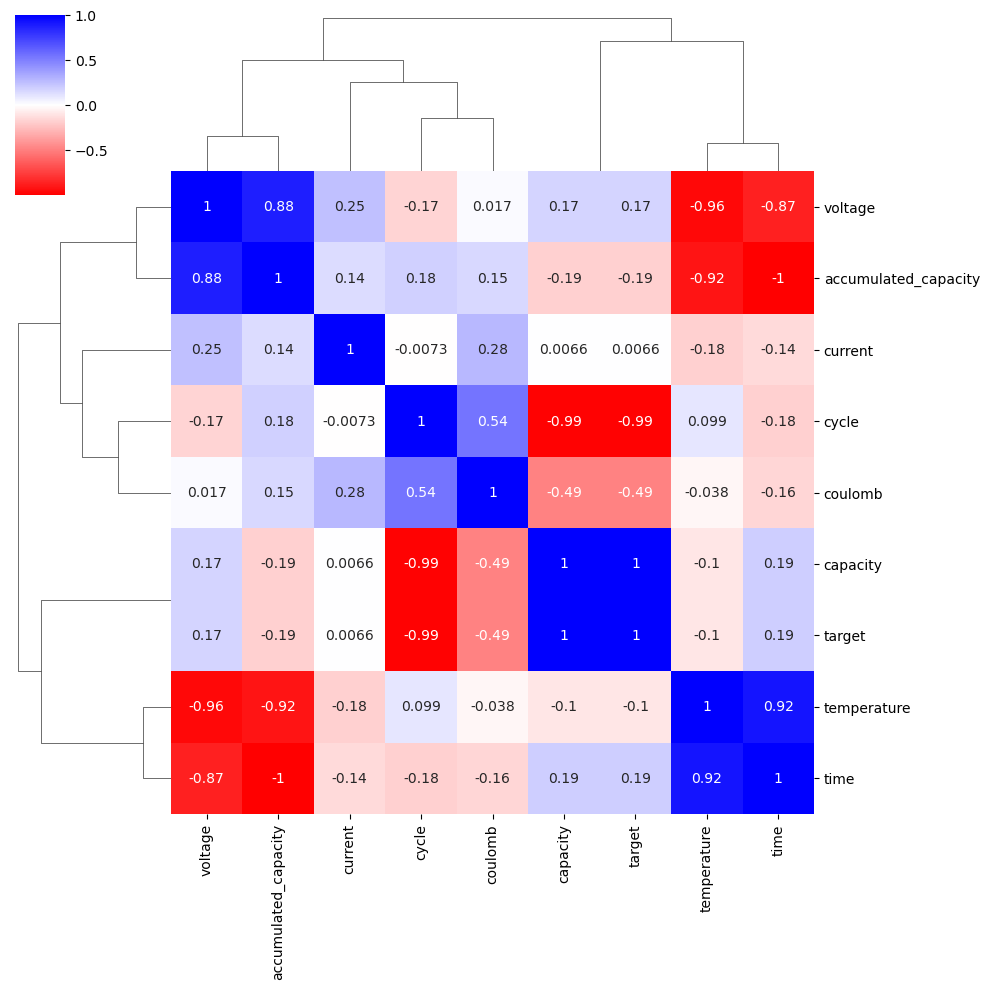

In [2558]:
sns.clustermap(df_train.corr(), annot=True, cmap='bwr_r')

## cross validation with ridge ($R^2\$)

In [2559]:
res = pd.DataFrame(cross_validate(Ridge(), x_train, y_train, return_train_score=True))
res.mean()

fit_time       0.005785
score_time     0.002593
test_score     0.999953
train_score    0.999953
dtype: float64

## cleaned data

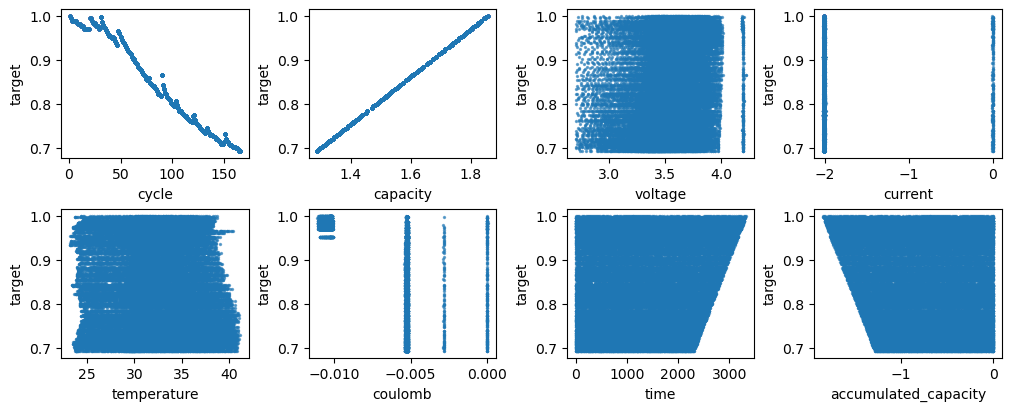

In [2560]:
x_train, x_test, y_train, y_test = train_test_split(b5_inputs_cleaned, b5_SOH_target_cleaned)

df_train = x_train.copy()
df_train['target'] = y_train

fig, axes = plt.subplots(2, 4, constrained_layout=True, figsize=(10, 4))
for col, ax in zip(b7_inputs.columns, axes.ravel()):
    df_train.plot(x=col, y='target', kind='scatter', ax=ax, legend=False, s=2, alpha=.6)

## categorical features: voltage, current, coulomb
Coulomb is interesting feature

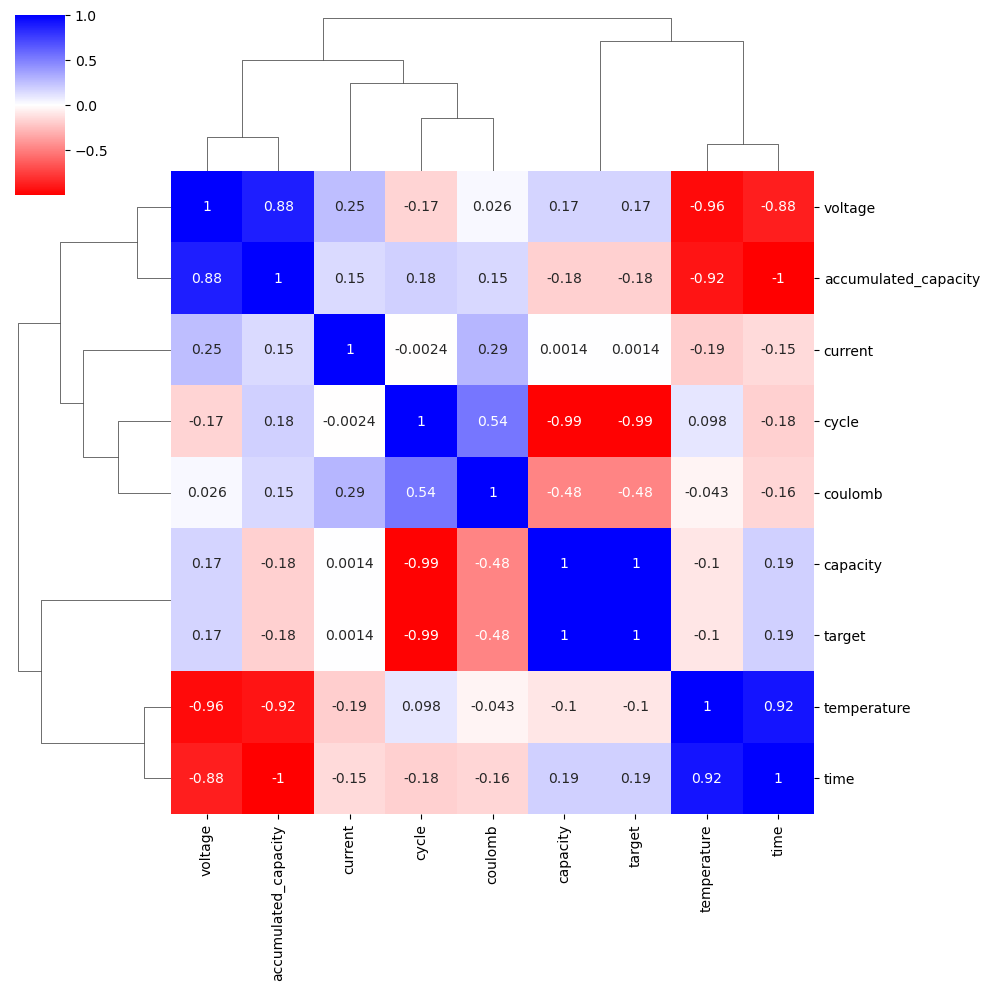

In [2561]:
sns.clustermap(df_train.corr(), annot=True, cmap='bwr_r')

In [2562]:
res = pd.DataFrame(cross_validate(Ridge(), x_train, y_train, return_train_score=True))
res.mean()

fit_time       0.006184
score_time     0.002593
test_score     0.999951
train_score    0.999951
dtype: float64

## With original B7

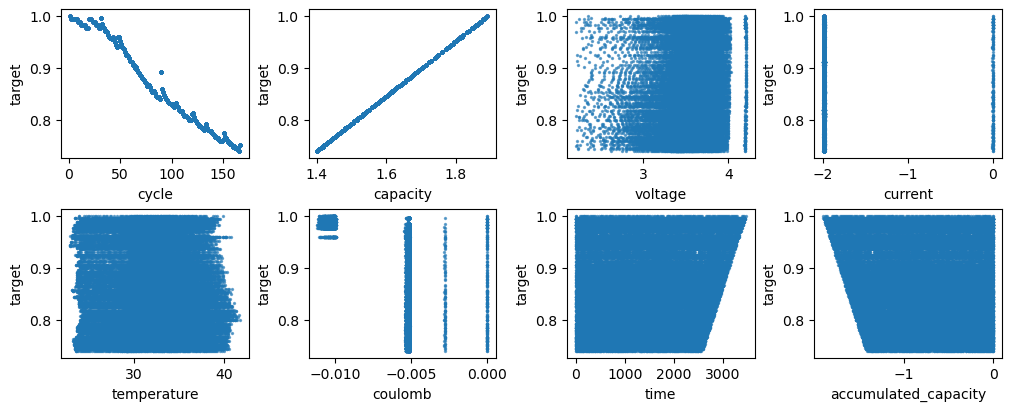

In [2563]:
x_train, x_test, y_train, y_test = train_test_split(b7_inputs, b7_SOH_target)

df_train = x_train.copy()
df_train['target'] = y_train

fig, axes = plt.subplots(2, 4, constrained_layout=True, figsize=(10, 4))
for col, ax in zip(b7_inputs.columns, axes.ravel()):
    df_train.plot(x=col, y='target', kind='scatter', ax=ax, legend=False, s=2, alpha=.6)

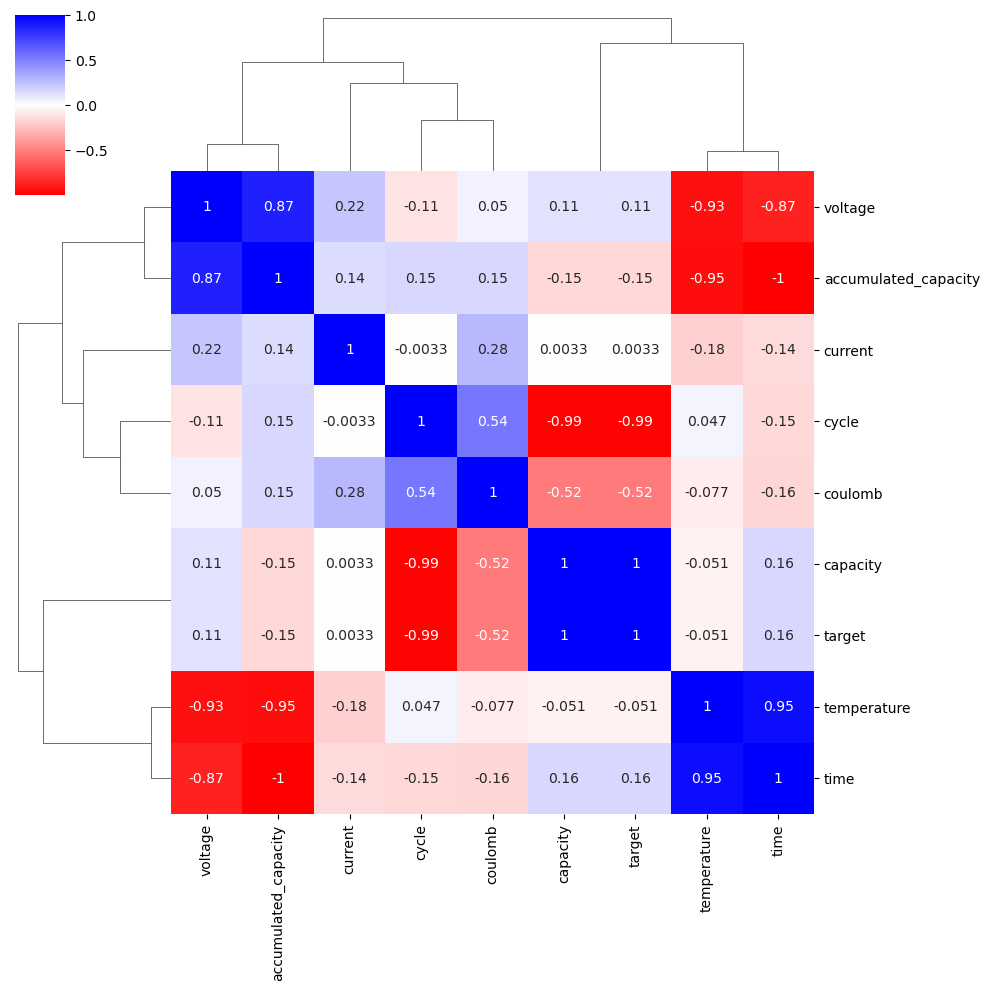

In [2564]:
sns.clustermap(df_train.corr(), annot=True, cmap='bwr_r')

In [2565]:
res = pd.DataFrame(cross_validate(Ridge(), x_train, y_train, return_train_score=True))
res.mean()

fit_time       0.007181
score_time     0.002593
test_score     0.999919
train_score    0.999919
dtype: float64

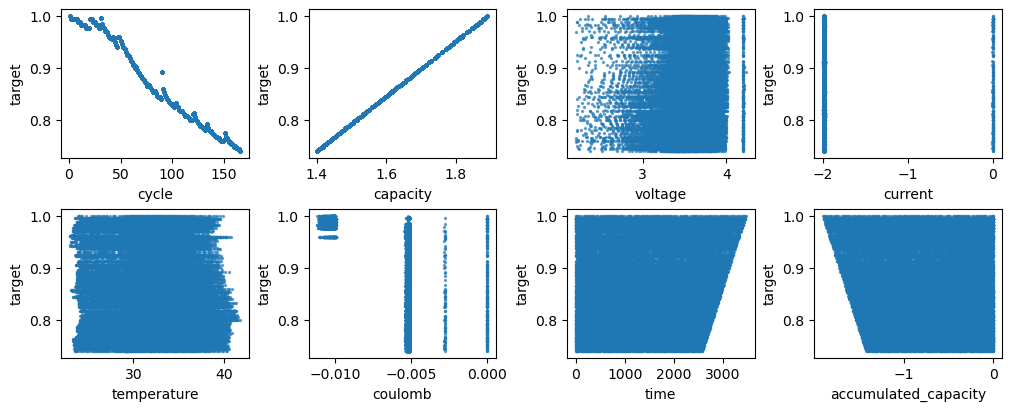

In [2567]:
x_train, x_test, y_train, y_test = train_test_split(b7_inputs_cleaned, b7_SOH_target_cleaned)

df_train = x_train.copy()
df_train['target'] = y_train

fig, axes = plt.subplots(2, 4, constrained_layout=True, figsize=(10, 4))
for col, ax in zip(b7_inputs.columns, axes.ravel()):
    df_train.plot(x=col, y='target', kind='scatter', ax=ax, legend=False, s=2, alpha=.6)

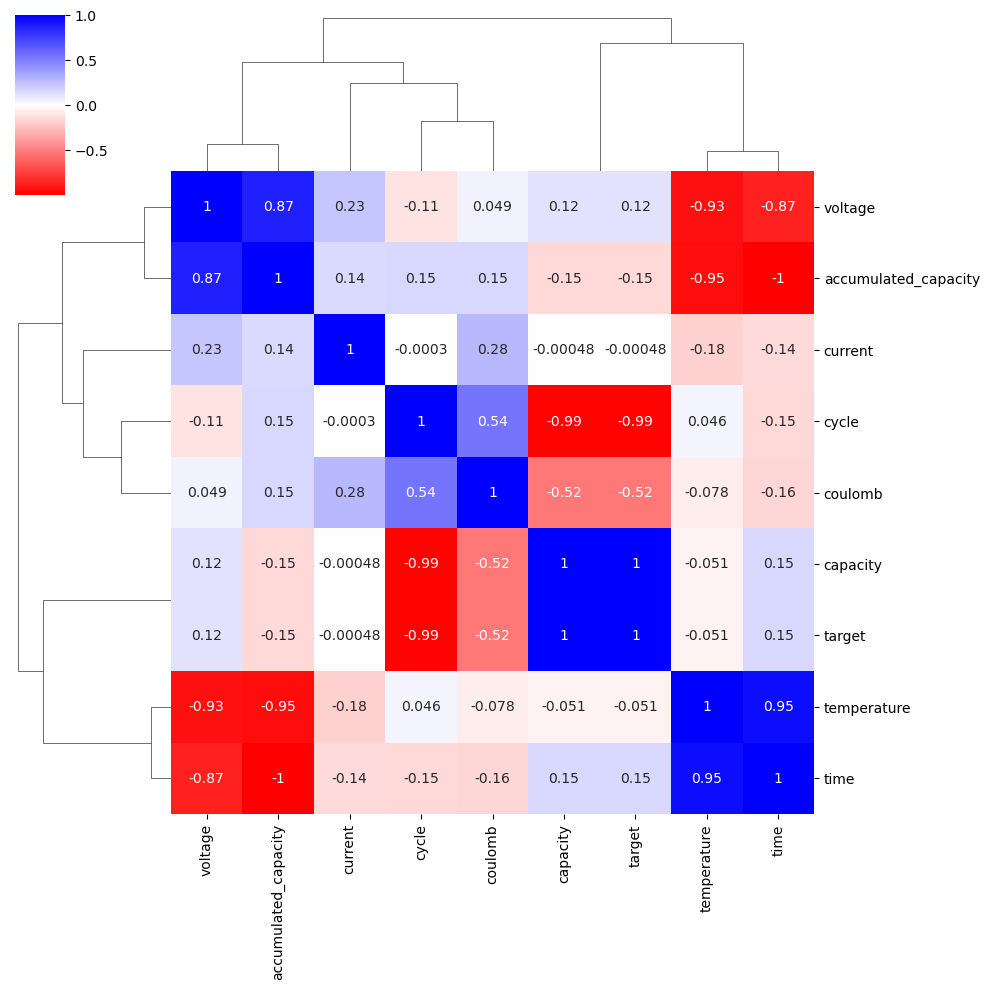

In [2568]:
sns.clustermap(df_train.corr(), annot=True, cmap='bwr_r')

In [2570]:
res = pd.DataFrame(cross_validate(Ridge(), x_train, y_train, return_train_score=True))
res.mean()

fit_time       0.008577
score_time     0.002992
test_score     0.999917
train_score    0.999917
dtype: float64

# Conclusion of feature analysis
1) Cleaned data do not show any improvement in feature analysis. Thus, H1 will be rejected. it may require one more validation with simple ANN model </br>
2) voltage, current, and coulomb are categorical features. especially, the coulomb feature shows strong relationship with SOH. Thus, the coulomb feature must be included in feature set as input data. </br>
3) temperature and current feature show weak realtionship with SOH since ambient temperature and current are fixed in experiment </br>
4) time and accumulated capacity show strong relationship. so two features may have the same direction in vector space.
5) Cycle count show strong relationship with SOH and capacity.

## input features
1) Capacity can not be get in real world. so capacity data will not be included in feature set. </br>
2) Although cycle count show strong relationship with SOH, it is not easy to determined with real-time data.

Thus, two input feature sets will be tested. </br>
1) 'voltage', 'current', 'temperature', 'coulomb', 'time' </br>
2) 'cycle', 'accumulated capacity', 'voltage', 'current', 'temperature', 'coulomb', 'time' </br>

In [705]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

## modify tensorflow example for custom train

In [836]:
import time

class custom_train:
    def __init__(self, model, optimizer_fn, loss_fn, metric_fn):
        self.model = model
        self.optimizer = optimizer_fn
        self.loss_fn = loss_fn
        self.metrics = metric_fn

    #tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            #print(f'x:{x}, y:{y} {type(x)}')
            logits = self.model(x, training=True)
            loss_value = self.loss_fn(y, logits)
        grads = tape.gradient(loss_value, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.metrics.update_state(y, logits)
        return loss_value

    def train(self, inputs, outputs, epochs, epoch_log, loss_threshold):
        loss_list = []
        epoch_list = []
        start_time = time.time()
        for epoch in range(epochs):
            loss_value = self.train_step(inputs, outputs)
            
            # Display metrics at the end of each epoch.
            train_acc = self.metrics.result()
            
            if epoch%epoch_log==0:
                loss_list.append(loss_value)
                epoch_list.append(epoch)
                print(
                    "Training acc over epoch: %.4f Training loss (for one batch) at step %d: %.4f Time taken: %.2fs " 
                    % (float(train_acc), epoch, float(loss_value), (time.time() - start_time))
                )
            if loss_value <= loss_threshold:
                break
            # Reset training metrics at the end of each epoch
            self.metrics.reset_states()
            
        return loss_list, epoch_list

In [2315]:
class custom_train:
    def __init__(self, model, optimizer_fn, loss_fn, metric_fn):
        self.model = model
        self.optimizer = optimizer_fn
        self.loss_fn = loss_fn
        self.metrics = metric_fn
        self.loss_record = []
        self.epoch_record = []
        self.overfitting_epoch = []
        self.best_rms = 1.0
        self.rms_record = []


    #tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            #print(f'x:{x}, y:{y} {type(x)}')
            logits = self.model(x, training=True)
            loss_value = self.loss_fn(y, logits)
        grads = tape.gradient(loss_value, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.metrics.update_state(y, logits)
        return loss_value
    
    def validation(self, SOH_target, validation_inputs, cycle):
        SOH_predict = self.model.predict(validation_inputs)

        SOH_validation = cycle.loc[(cycle['cycle'] >= 1), ['cycle']]
        SOH_validation['SOH_predict'] = SOH_predict
        SOH_validation['SOH_target'] = SOH_target.to_numpy()

        rms = np.sqrt(mean_squared_error(SOH_validation['SOH_predict'], SOH_validation['SOH_target']))
        print('Root Mean Square Error: ', rms)

        SOH_validation_mean = SOH_validation.groupby(['cycle']).mean().reset_index()
        rms = np.sqrt(mean_squared_error(SOH_validation_mean['SOH_predict'], SOH_validation_mean['SOH_target']))
        print('Root Mean Square Error: ', rms)


        plt.plot(SOH_validation['cycle'], SOH_validation['SOH_predict'])
        plt.plot(SOH_validation_mean['cycle'], SOH_validation_mean['SOH_predict'])
        plt.plot(SOH_validation['cycle'], SOH_validation['SOH_target'])

        plt.xlabel("cycle")
        plt.ylabel("SOH")
        plt.legend(['Prediction', 'Mean Prediction by cycle', 'Real'])
        plt.title('SOH prediction')
    
    def train(self, inputs, outputs, epochs, epoch_log, loss_threshold):
        loss_list = []
        epoch_list = []
        start_time = time.time()
        for epoch in range(epochs):
            loss_value = self.train_step(inputs, outputs)
            
            # Display metrics at the end of each epoch.
            train_acc = self.metrics.result()
            
            if epoch%epoch_log==0:
                loss_list.append(loss_value)
                epoch_list.append(epoch)
                print(
                    "Training acc over epoch: %.4f Training loss (for one batch) at step %d: %.4f Time taken: %.2fs " 
                    % (float(train_acc), epoch, float(loss_value), (time.time() - start_time))
                )
            if loss_value <= loss_threshold:
                break
            # Reset training metrics at the end of each epoch
            self.metrics.reset_states()
        return loss_list, epoch_list
    
    def get_log(self):
        return self.loss_record, self.epoch_record, self.overfitting_epoch, self.best_rms, self.rms_record
    
    def clear_log(self):
        self.loss_record = []
        self.epoch_record = []
        self.overfitting_epoch = []
        self.best_rms = 1.0
        self.rms_record = []
            
    def train_validation(self, 
              train_inputs,
              train_outputs,
              cycle,
              validation_inputs,
              validation_outputs,
              epochs,
              epoch_log,
              loss_threshold,
              validation_threshold): # this is very slow due to validation automatically
        loss_list = []
        epoch_list = []
        start_time = time.time()
        if(len(self.epoch_record) == 0):
            initial_epoch = 0
        else:
            initial_epoch = self.epoch_record[-1]
        
        for epoch in range(1, epochs+1):
            loss_value = self.train_step(train_inputs, train_outputs)
            
            # Display metrics at the end of each epoch.
            train_acc = self.metrics.result()
            
            if (epoch%epoch_log)==0:
                loss_list.append(loss_value)
                epoch_list.append(epoch)
                self.loss_record.append(loss_value)
                if(len(self.epoch_record) == 0):
                    self.epoch_record.append(epoch)
                else:
                    self.epoch_record.append(initial_epoch + epoch)
                print(
                    "epoch: %d Training acc: %.4f Training loss at step %d: %.4f Time taken: %.2fs " 
                    % (self.epoch_record[-1], float(train_acc), epoch, float(loss_value), (time.time() - start_time)) # this print only training time
                )
                prediction_start_time = time.time()
                SOH_predict = self.model.predict(validation_inputs)
                SOH_validation = cycle
                SOH_validation['SOH_predict'] = SOH_predict
                SOH_validation['SOH_target'] = validation_outputs.to_numpy()
                realtime_rms = np.sqrt(mean_squared_error(SOH_validation['SOH_predict'], SOH_validation['SOH_target']))
                SOH_validation_mean = SOH_validation.groupby(['cycle']).mean().reset_index()
                cycle_rms = np.sqrt(mean_squared_error(SOH_validation_mean['SOH_predict'], SOH_validation_mean['SOH_target']))
                self.rms_record.append(cycle_rms)
                if self.best_rms > cycle_rms:
                    self.best_rms  = cycle_rms
                else:
                    self.overfitting_epoch.append(self.epoch_record[-1])
                    #break
                print(
                    "Prediction: realtime RMSE %.4f cycle RMSE %.4f Time taken: %.2fs " 
                    % (realtime_rms, cycle_rms, (time.time() - prediction_start_time))
                )
                print('overfitting candidates', self.overfitting_epoch)
                if cycle_rms <= validation_threshold:
                    break
            if loss_value <= loss_threshold:
                break
            
            # Reset training metrics at the end of each epoch
            self.metrics.reset_states()
            
        return loss_list, epoch_list

In [2463]:
b5_validation_inputs = b5_inputs[input_attributes]
b5_validation_inputs  = scale.fit_transform(b5_validation_inputs)

b6_validation_inputs = b6_inputs[input_attributes]
b6_validation_inputs  = scale.fit_transform(b6_validation_inputs)

b7_validation_inputs = b7_inputs[input_attributes]
b7_validation_inputs  = scale.fit_transform(b7_validation_inputs)

b18_validation_inputs = b18_inputs[input_attributes]
b18_validation_inputs  = scale.fit_transform(b18_validation_inputs)

b5_cycle = b5_inputs.loc[(b5_inputs['cycle'] >= 1), ['cycle']]
b6_cycle = b6_inputs.loc[(b6_inputs['cycle'] >= 1), ['cycle']]
b7_cycle = b7_inputs.loc[(b7_inputs['cycle'] >= 1), ['cycle']]
b18_cycle = b18_inputs.loc[(b18_inputs['cycle'] >= 1), ['cycle']]

b5_validation_inputs_cleaned = b5_inputs_cleaned[input_attributes]
b5_validation_inputs_cleaned  = scale.fit_transform(b5_validation_inputs_cleaned)

b6_validation_inputs_cleaned = b6_inputs_cleaned[input_attributes]
b6_validation_inputs_cleaned  = scale.fit_transform(b6_validation_inputs_cleaned)

b7_validation_inputs_cleaned = b7_inputs_cleaned[input_attributes]
b7_validation_inputs_cleaned  = scale.fit_transform(b7_validation_inputs_cleaned)

b18_validation_inputs_cleaned = b18_inputs_cleaned[input_attributes]
b18_validation_inputs_cleaned  = scale.fit_transform(b18_validation_inputs_cleaned)

b5_cycle_cleaned = b5_inputs_cleaned.loc[(b5_inputs_cleaned['cycle'] >= 1), ['cycle']]
b6_cycle_cleaned = b6_inputs_cleaned.loc[(b6_inputs_cleaned['cycle'] >= 1), ['cycle']]
b7_cycle_cleaned = b7_inputs_cleaned.loc[(b7_inputs_cleaned['cycle'] >= 1), ['cycle']]
b18_cycle_cleaned = b18_inputs_cleaned.loc[(b18_inputs_cleaned['cycle'] >= 1), ['cycle']]


In [2120]:
def custom_validation(model, SOH_target, validation_inputs, inputs):
    SOH_predict = model.predict(validation_inputs)

    SOH_validation = inputs.loc[(inputs['cycle'] >= 1), ['cycle']]
    SOH_validation['SOH_predict'] = SOH_predict
    SOH_validation['SOH_target'] = SOH_target.to_numpy()
    
    rms = np.sqrt(mean_squared_error(SOH_validation['SOH_predict'], SOH_validation['SOH_target']))
    print('Root Mean Square Error: ', rms)

    SOH_validation_mean = SOH_validation.groupby(['cycle']).mean().reset_index()
    rms = np.sqrt(mean_squared_error(SOH_validation_mean['SOH_predict'], SOH_validation_mean['SOH_target']))
    print('Root Mean Square Error: ', rms)


    plt.plot(SOH_validation['cycle'], SOH_validation['SOH_predict'])
    plt.plot(SOH_validation_mean['cycle'], SOH_validation_mean['SOH_predict'])
    plt.plot(SOH_validation['cycle'], SOH_validation['SOH_target'])

    plt.xlabel("cycle")
    plt.ylabel("SOH")
    plt.legend(['Prediction', 'Mean Prediction by cycle', 'Real'])
    plt.title('SOH real-time prediction')

# Test with simple models for rejection of my H1

# FNN(b7) + hidden(relu) + output(sigmoid)
optimizer=Adam, loss=MSE, Metrics=MAE, validation with b6 during training

In [2281]:
loss_list = []
epoch_list = []

input_layer = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer = keras.layers.Dense(10, activation='relu', kernel_initializer = 'random_normal')(input_layer)
output_layer = keras.layers.Dense(1, activation='sigmoid', kernel_initializer = 'random_normal')(hidden_layer)
model = keras.Model(input_layer, output_layer)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model.summary()

Model: "model_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_132 (InputLayer)      [(None, 5)]               0         
                                                                 
 dense_441 (Dense)           (None, 10)                60        
                                                                 
 dense_442 (Dense)           (None, 1)                 11        
                                                                 
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


In [2316]:
my_train = custom_train(model, optimizer, loss_function, metric)

In [2300]:
loss_list, epoch_list = my_train.train_validation(b7_train_inputs, b7_train_SOH, b6_cycle, b6_validation_inputs, b6_SOH_target, 1000, 200, 0.001, 0.03)

epoch: 8400 Training acc: 0.0319 Training loss at step 200: 0.0020 Time taken: 3.37s 
1385/1385 [==============================] - 2s 1ms/step
Prediction: realtime RMSE 0.0656 cycle RMSE 0.0329 Time taken: 2.46s 
overfitting candidates [400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 5800, 7200, 7400, 7600]
epoch: 8600 Training acc: 0.0316 Training loss at step 400: 0.0020 Time taken: 9.07s 
1385/1385 [==============================] - 2s 1ms/step
Prediction: realtime RMSE 0.0656 cycle RMSE 0.0321 Time taken: 2.27s 
overfitting candidates [400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 5800, 7200, 7400, 7600]
epoch: 8800 Training acc: 0.0314 Training loss at step 600: 0.0019 Time taken: 14.30s 
1385/1385 [==============================] - 2s 1ms/step
Prediction: realtime RMSE 0.0658 cycle RMSE 0.0316 Time taken: 2.30s 
overfitting candidates [400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 5800, 7200, 740

In [2301]:
loss_list, epoch_list, overfitting_epoch, best_rms, rms_list = my_train.get_log()
print(overfitting_epoch)

[400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 5800, 7200, 7400, 7600, 9000, 9200]


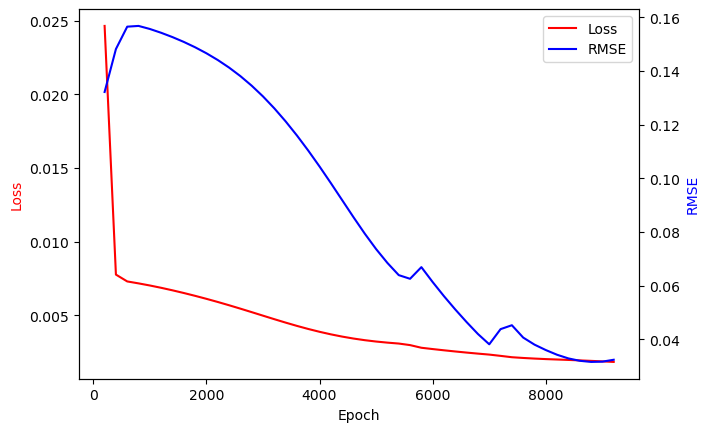

In [2303]:
fig, ax = plt.subplots()
fig.subplots_adjust(right=1)

rms_ax = ax.twinx()


#temperature_ax.spines.right.set_position(("axes", 1.2))
#fig.plot(discharge['data'][0][0]['Time'][0])
p1, = ax.plot(epoch_list, loss_list, "r-", label="Loss")
p2, = rms_ax.plot(epoch_list, rms_list, "b-", label="RMSE")


#ax.set_xlim(0, 2)
#ax.set_ylim(0, 2)
#current_ax.set_ylim(-4, 0)
#temperature_ax.set_ylim(1, 20)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
rms_ax.set_ylabel("RMSE")

ax.yaxis.label.set_color(p1.get_color())
rms_ax.yaxis.label.set_color(p2.get_color())

ax.legend(handles=[p1, p2])
#fig2.subplots_adjust(right=0.75)

1408/1408 [==============================] - 2s 2ms/step
Root Mean Square Error:  0.09262956527238114
Root Mean Square Error:  0.0688200928612999


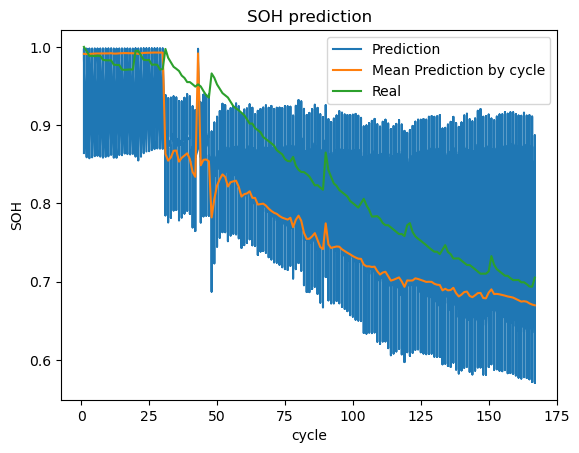

In [2322]:
my_train.validation(b5_SOH_target, b5_validation_inputs, b5_cycle)

1385/1385 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.06709318953718693
Root Mean Square Error:  0.03243942902766831


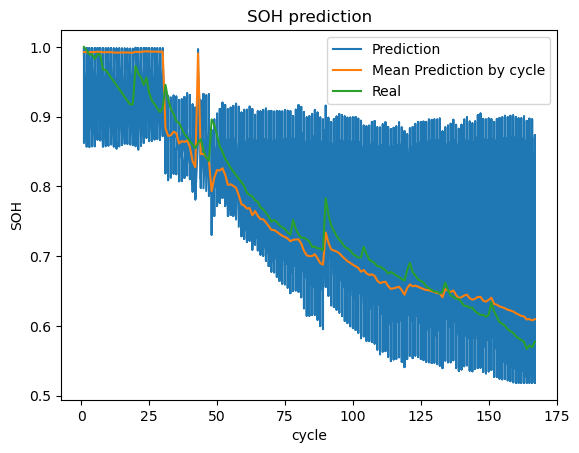

In [2323]:
my_train.validation(b6_SOH_target, b6_validation_inputs, b6_cycle)

1506/1506 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.04297842381280998
Root Mean Square Error:  0.02986555721764074


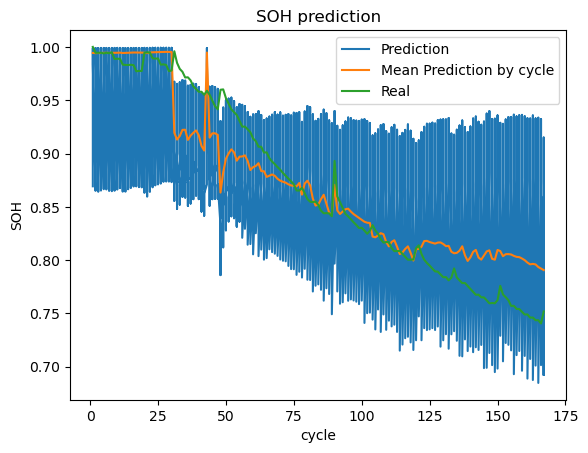

In [2324]:
my_train.validation(b7_SOH_target, b7_validation_inputs, b7_cycle)

993/993 [==============================] - 1s 1ms/step
Root Mean Square Error:  0.14833514426144934
Root Mean Square Error:  0.1605112992283108


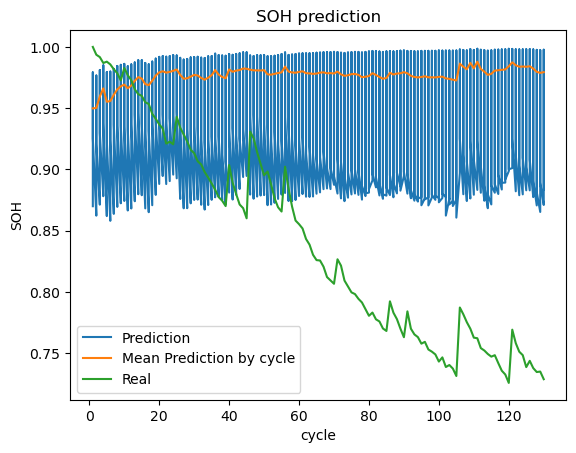

In [2325]:
my_train.validation(b18_SOH_target, b18_validation_inputs, b18_cycle)

# Training with B5

In [2407]:
loss_list = []
epoch_list = []

input_layer = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer = keras.layers.Dense(10, activation='relu', kernel_initializer = 'random_normal')(input_layer)
output_layer = keras.layers.Dense(1, activation='sigmoid', kernel_initializer = 'random_normal')(hidden_layer)
model = keras.Model(input_layer, output_layer)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model.summary()

Model: "model_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_140 (InputLayer)      [(None, 5)]               0         
                                                                 
 dense_457 (Dense)           (None, 10)                60        
                                                                 
 dense_458 (Dense)           (None, 1)                 11        
                                                                 
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


In [2408]:
my_train = custom_train(model, optimizer, loss_function, metric)

In [2433]:
loss_list, epoch_list = my_train.train_validation(b5_train_inputs, b5_train_SOH, b6_cycle, b6_validation_inputs, b6_SOH_target, 1000, 200, 0.001, 0.03)

epoch: 16200 Training acc: 0.0301 Training loss at step 200: 0.0017 Time taken: 3.35s 
1385/1385 [==============================] - 1s 908us/step
Prediction: realtime RMSE 0.0658 cycle RMSE 0.0521 Time taken: 1.82s 
overfitting candidates [400, 600, 800, 1000, 10600, 11000, 11400, 12200, 12600, 13000, 13200, 13400, 13800, 14000, 14400, 14600, 14800, 15000, 15200, 15400, 15600, 15800, 16000, 16200]
epoch: 16400 Training acc: 0.0299 Training loss at step 400: 0.0017 Time taken: 8.18s 
1385/1385 [==============================] - 2s 1ms/step
Prediction: realtime RMSE 0.0659 cycle RMSE 0.0526 Time taken: 2.20s 
overfitting candidates [400, 600, 800, 1000, 10600, 11000, 11400, 12200, 12600, 13000, 13200, 13400, 13800, 14000, 14400, 14600, 14800, 15000, 15200, 15400, 15600, 15800, 16000, 16200, 16400]
epoch: 16600 Training acc: 0.0298 Training loss at step 600: 0.0017 Time taken: 13.47s 
1385/1385 [==============================] - 1s 1ms/step
Prediction: realtime RMSE 0.0660 cycle RMSE 0.05

In [2434]:
loss_list, epoch_list, overfitting_epoch, best_rms, rms_list = my_train.get_log()
print(overfitting_epoch)

[400, 600, 800, 1000, 10600, 11000, 11400, 12200, 12600, 13000, 13200, 13400, 13800, 14000, 14400, 14600, 14800, 15000, 15200, 15400, 15600, 15800, 16000, 16200, 16400, 16600, 16800, 17000]


In [2435]:
def loss_plot(epoch_list, loss_list, rms_list):
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1)

    rms_ax = ax.twinx()

    p1, = ax.plot(epoch_list, loss_list, "r-", label="Loss")
    p2, = rms_ax.plot(epoch_list, rms_list, "b-", label="RMSE")

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    rms_ax.set_ylabel("RMSE")

    ax.yaxis.label.set_color(p1.get_color())
    rms_ax.yaxis.label.set_color(p2.get_color())

    ax.legend(handles=[p1, p2])

In [2436]:
print(best_rms, epoch_list[-1])

0.0509751298268695 17000


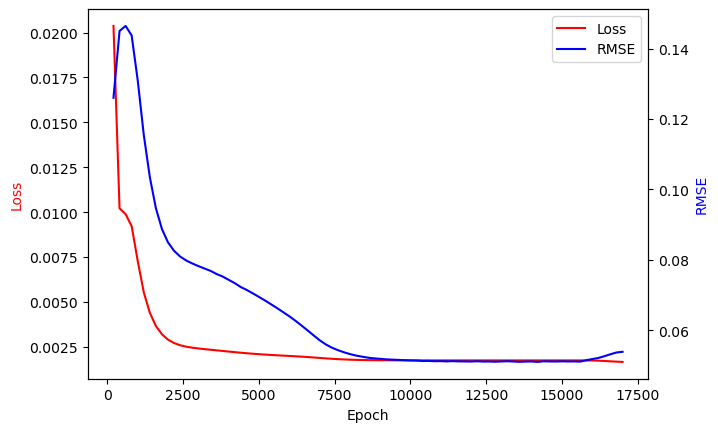

In [2437]:
loss_plot(epoch_list, loss_list, rms_list)

1408/1408 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.04174917486452869
Root Mean Square Error:  0.022719605326137614


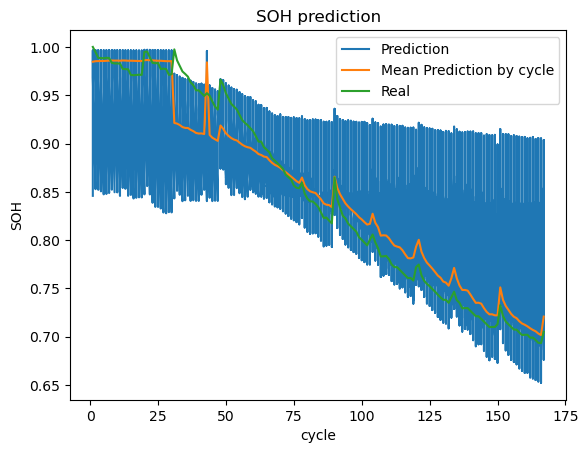

In [2429]:
my_train.validation(b5_SOH_target, b5_validation_inputs, b5_cycle)

1385/1385 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.06583955036560092
Root Mean Square Error:  0.05178655292810246


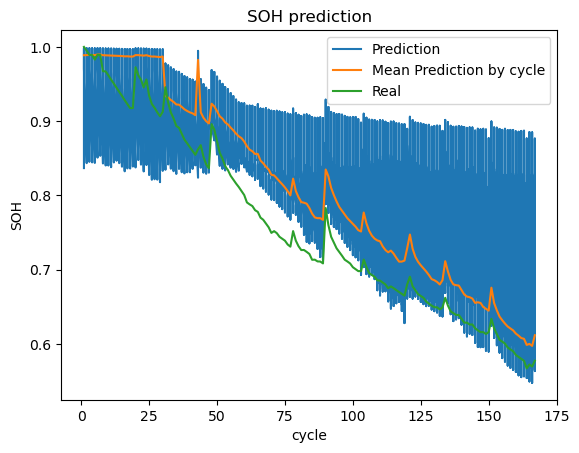

In [2430]:
my_train.validation(b6_SOH_target, b6_validation_inputs, b6_cycle)

1506/1506 [==============================] - 1s 979us/step
Root Mean Square Error:  0.1033286791291221
Root Mean Square Error:  0.09878021682679118


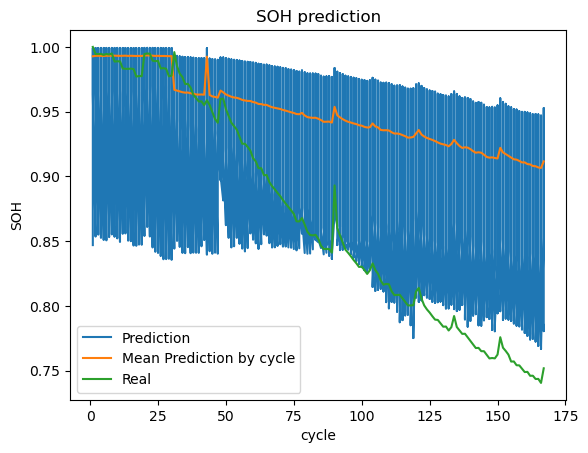

In [2431]:
my_train.validation(b7_SOH_target, b7_validation_inputs, b7_cycle)

993/993 [==============================] - 1s 1ms/step
Root Mean Square Error:  0.14539206493020598
Root Mean Square Error:  0.15665838547297128


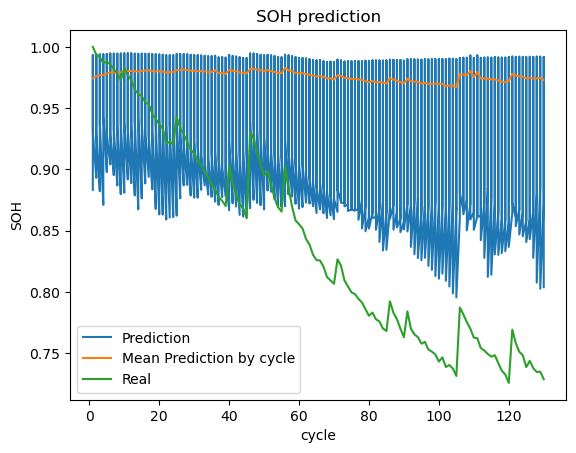

In [2432]:
my_train.validation(b18_SOH_target, b18_validation_inputs, b18_cycle)

# training with cleaned B7
However, no improvement compared with non-cleaned data

In [2488]:
loss_list = []
epoch_list = []

input_layer = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer = keras.layers.Dense(10, activation='relu', kernel_initializer = 'random_normal')(input_layer)
output_layer = keras.layers.Dense(1, activation='sigmoid', kernel_initializer = 'random_normal')(hidden_layer)
model = keras.Model(input_layer, output_layer)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model.summary()

Model: "model_143"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_145 (InputLayer)      [(None, 5)]               0         
                                                                 
 dense_467 (Dense)           (None, 10)                60        
                                                                 
 dense_468 (Dense)           (None, 1)                 11        
                                                                 
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


In [2489]:
my_train = custom_train(model, optimizer, loss_function, metric)

In [2491]:
loss_list, epoch_list = my_train.train_validation(b7_train_inputs_cleaned, b7_train_SOH_cleaned, b6_cycle_cleaned, b6_validation_inputs_cleaned, b6_SOH_target_cleaned, 1000, 200, 0.001, 0.03)

epoch: 8200 Training acc: 0.0317 Training loss at step 200: 0.0020 Time taken: 3.08s 
1377/1377 [==============================] - 1s 1ms/step
Prediction: realtime RMSE 0.0645 cycle RMSE 0.0343 Time taken: 2.01s 
overfitting candidates [400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 5200, 6800, 7000, 7200, 7400]
epoch: 8400 Training acc: 0.0315 Training loss at step 400: 0.0019 Time taken: 8.16s 
1377/1377 [==============================] - 1s 918us/step
Prediction: realtime RMSE 0.0645 cycle RMSE 0.0333 Time taken: 1.84s 
overfitting candidates [400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 5200, 6800, 7000, 7200, 7400]
epoch: 8600 Training acc: 0.0313 Training loss at step 600: 0.0019 Time taken: 13.08s 
1377/1377 [==============================] - 1s 915us/step
Prediction: realtime RMSE 0.0647 cycle RMSE 0.0326 Time taken: 1.87s 
overfitting candidates [400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800,

In [2492]:
loss_list, epoch_list, overfitting_epoch, best_rms, rms_list = my_train.get_log()
print(overfitting_epoch)

[400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 5200, 6800, 7000, 7200, 7400, 9000]


In [2493]:
print(best_rms, epoch_list[-1])

0.03229006736467445 9000


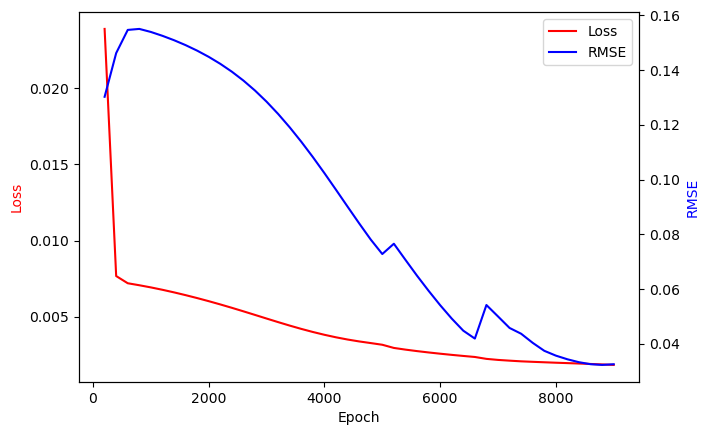

In [2494]:
loss_plot(epoch_list, loss_list, rms_list)

1400/1400 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.09170207188159941
Root Mean Square Error:  0.0682851625179043


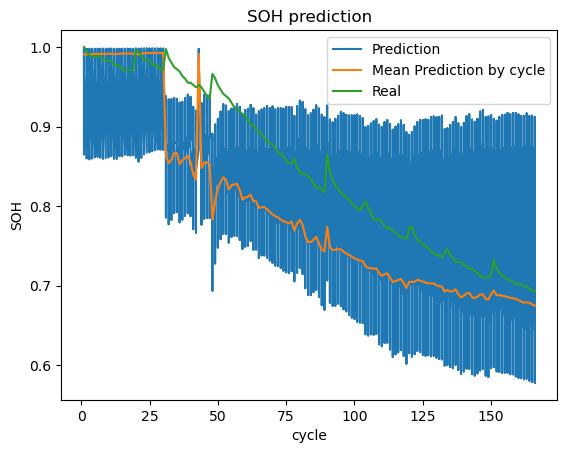

In [2497]:
my_train.validation(b5_SOH_target_cleaned, b5_validation_inputs_cleaned, b5_cycle_cleaned)

1377/1377 [==============================] - 1s 1ms/step
Root Mean Square Error:  0.06585424166219957
Root Mean Square Error:  0.032544000117055605


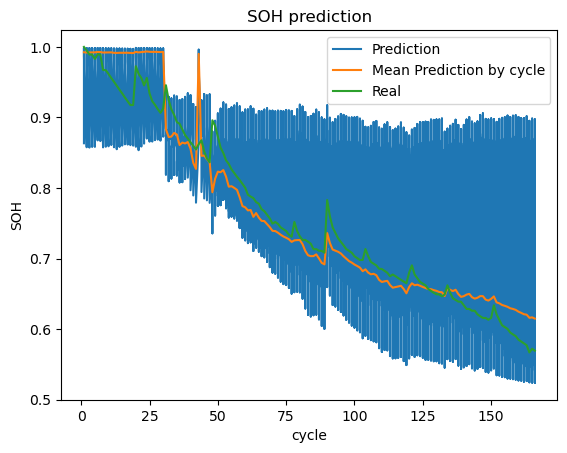

In [2573]:
my_train.validation(b6_SOH_target_cleaned, b6_validation_inputs_cleaned, b6_cycle_cleaned)

1498/1498 [==============================] - 1s 958us/step
Root Mean Square Error:  0.042976294187731856
Root Mean Square Error:  0.02985041336922523


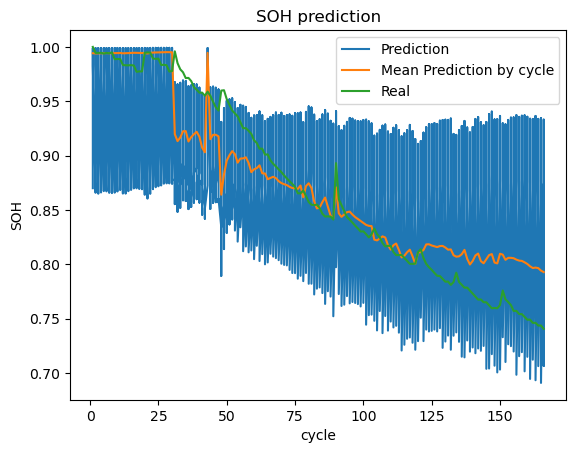

In [2574]:
my_train.validation(b7_SOH_target_cleaned, b7_validation_inputs_cleaned, b7_cycle_cleaned)

988/988 [==============================] - 1s 1ms/step
Root Mean Square Error:  0.14670911408265652
Root Mean Square Error:  0.15865523145595425


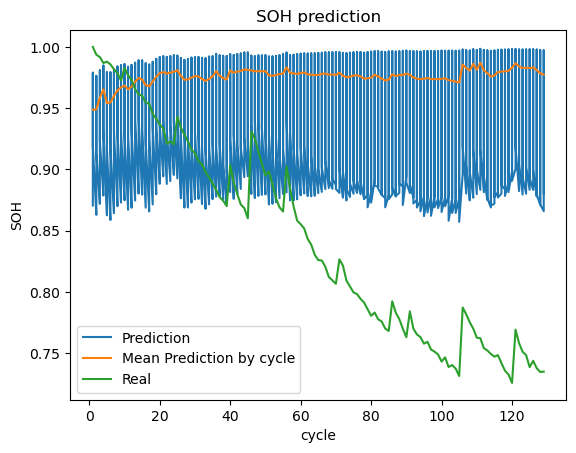

In [2575]:
my_train.validation(b18_SOH_target_cleaned, b18_validation_inputs_cleaned, b18_cycle_cleaned)

# H1 is finally rejected since there is no significant difference in sime ANN model test

# FNN(b7) + hidden(relu) + output(relu)
optimizer=Adam, loss=MSE, Metrics=MAE, validation with b6 during training

In [2343]:
loss_list_m2 = []
epoch_list_m2 = []

input_layer_m2 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_m2 = keras.layers.Dense(10, activation='relu', kernel_initializer = 'random_normal')(input_layer_m2)
output_layer_m2 = keras.layers.Dense(1, activation='relu', kernel_initializer = 'random_normal')(hidden_layer_m2)
model2 = keras.Model(input_layer_m2, output_layer_m2)
optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model.summary()

Model: "model_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_132 (InputLayer)      [(None, 5)]               0         
                                                                 
 dense_441 (Dense)           (None, 10)                60        
                                                                 
 dense_442 (Dense)           (None, 1)                 11        
                                                                 
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


In [2344]:
my_train_m2 = custom_train(model2, optimizer, loss_function, metric)

In [2345]:
loss_list_m2, epoch_list_m2 = my_train_m2.train_validation(b7_train_inputs, b7_train_SOH, b6_cycle, b6_validation_inputs, b6_SOH_target, 1000, 200, 0.001, 0.03)

epoch: 200 Training acc: 0.8657 Training loss at step 200: 0.7559 Time taken: 3.02s 
1385/1385 [==============================] - 2s 1ms/step
Prediction: realtime RMSE 0.7674 cycle RMSE 0.7709 Time taken: 2.20s 
overfitting candidates []
epoch: 400 Training acc: 0.8657 Training loss at step 400: 0.7559 Time taken: 8.17s 
1385/1385 [==============================] - 2s 1ms/step
Prediction: realtime RMSE 0.7674 cycle RMSE 0.7709 Time taken: 2.34s 
overfitting candidates [400]
epoch: 600 Training acc: 0.8657 Training loss at step 600: 0.7559 Time taken: 13.61s 
1385/1385 [==============================] - 2s 1ms/step
Prediction: realtime RMSE 0.7674 cycle RMSE 0.7709 Time taken: 2.07s 
overfitting candidates [400, 600]
epoch: 800 Training acc: 0.8657 Training loss at step 800: 0.7559 Time taken: 18.65s 
1385/1385 [==============================] - 2s 1ms/step
Prediction: realtime RMSE 0.7674 cycle RMSE 0.7709 Time taken: 2.10s 
overfitting candidates [400, 600, 800]
epoch: 1000 Training a

In [2346]:
loss_list, epoch_list, overfitting_epoch, best_rms, rms_list = my_train_m2.get_log()
print(overfitting_epoch)

[400, 600, 800, 1000]


In [2349]:
def loss_plot(epoch_list, loss_list, rms_list):
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1)

    rms_ax = ax.twinx()

    p1, = ax.plot(epoch_list, loss_list, "r-", label="Loss")
    p2, = rms_ax.plot(epoch_list, rms_list, "b-", label="RMSE")

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    rms_ax.set_ylabel("RMSE")

    ax.yaxis.label.set_color(p1.get_color())
    rms_ax.yaxis.label.set_color(p2.get_color())

    ax.legend(handles=[p1, p2])

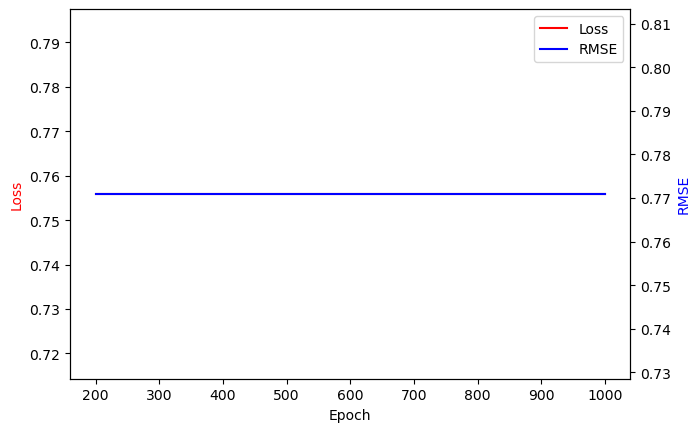

In [2350]:
loss_plot(epoch_list, loss_list, rms_list)

1506/1506 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.8694235096262397
Root Mean Square Error:  0.8743600851544843


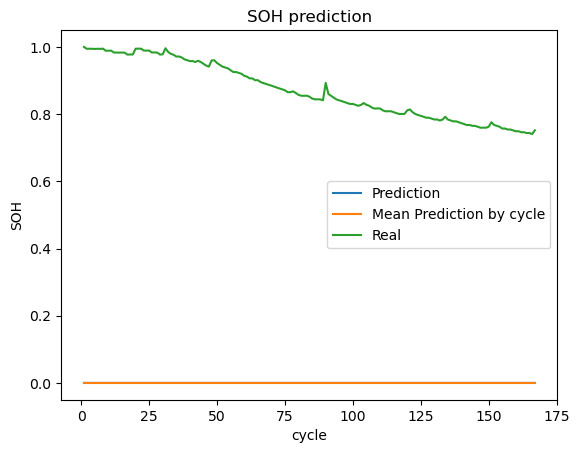

In [2352]:
my_train_m2.validation(b7_SOH_target, b7_validation_inputs, b7_cycle)

In [2438]:
loss_list_m2 = []
epoch_list_m2 = []

input_layer_m2 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_m2 = keras.layers.Dense(10, activation='relu', kernel_initializer = 'random_normal')(input_layer_m2)
output_layer_m2 = keras.layers.Dense(1, activation='relu', kernel_initializer = 'random_normal')(hidden_layer_m2)
model2 = keras.Model(input_layer_m2, output_layer_m2)
optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model.summary()

Model: "model_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_140 (InputLayer)      [(None, 5)]               0         
                                                                 
 dense_457 (Dense)           (None, 10)                60        
                                                                 
 dense_458 (Dense)           (None, 1)                 11        
                                                                 
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


In [2439]:
my_train_m2 = custom_train(model2, optimizer, loss_function, metric)

In [2449]:
loss_list_m2, epoch_list_m2 = my_train_m2.train_validation(b5_train_inputs, b5_train_SOH, b6_cycle, b6_validation_inputs, b6_SOH_target, 2000, 200, 0.001, 0.03)

epoch: 8200 Training acc: 0.0467 Training loss at step 200: 0.0035 Time taken: 2.96s 
1385/1385 [==============================] - 2s 1ms/step
Prediction: realtime RMSE 0.0935 cycle RMSE 0.0849 Time taken: 2.20s 
overfitting candidates [400, 600, 5800, 6000, 6200, 6400, 6600, 6800, 7000, 7200, 7400, 7600, 7800, 8000, 8200]
epoch: 8400 Training acc: 0.0467 Training loss at step 400: 0.0035 Time taken: 8.04s 
1385/1385 [==============================] - 1s 1ms/step
Prediction: realtime RMSE 0.0935 cycle RMSE 0.0849 Time taken: 2.03s 
overfitting candidates [400, 600, 5800, 6000, 6200, 6400, 6600, 6800, 7000, 7200, 7400, 7600, 7800, 8000, 8200, 8400]
epoch: 8600 Training acc: 0.0467 Training loss at step 600: 0.0035 Time taken: 13.06s 
1385/1385 [==============================] - 2s 1ms/step
Prediction: realtime RMSE 0.0936 cycle RMSE 0.0849 Time taken: 2.56s 
overfitting candidates [400, 600, 5800, 6000, 6200, 6400, 6600, 6800, 7000, 7200, 7400, 7600, 7800, 8000, 8200, 8400, 8600]
epoch:

In [2456]:
loss_list, epoch_list, overfitting_epoch, best_rms, rms_list = my_train_m2.get_log()
print(epoch_list[-1], overfitting_epoch)

10000 [400, 600, 5800, 6000, 6200, 6400, 6600, 6800, 7000, 7200, 7400, 7600, 7800, 8000, 8200, 8400, 8600, 8800, 9000, 9200, 9400, 9600, 9800, 10000]


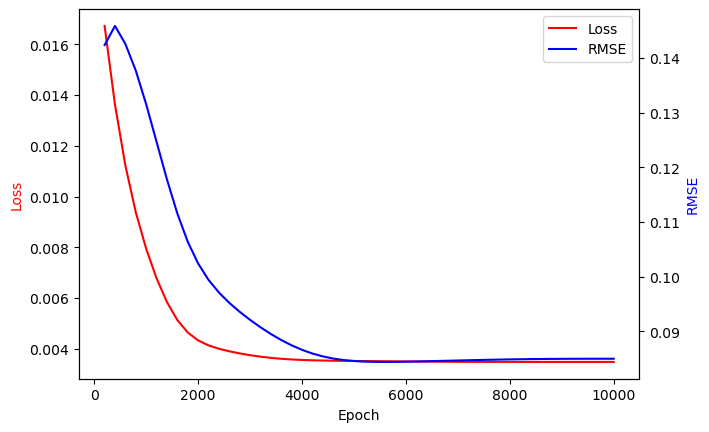

In [2451]:
loss_plot(epoch_list, loss_list, rms_list)

1408/1408 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.059016538673645924
Root Mean Square Error:  0.040190614335500356


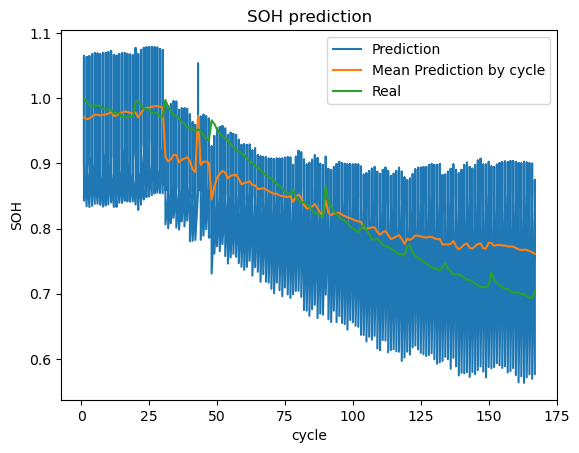

In [2453]:
my_train_m2.validation(b5_SOH_target, b5_validation_inputs, b5_cycle)

1385/1385 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.0935898657802837
Root Mean Square Error:  0.08497842635558402


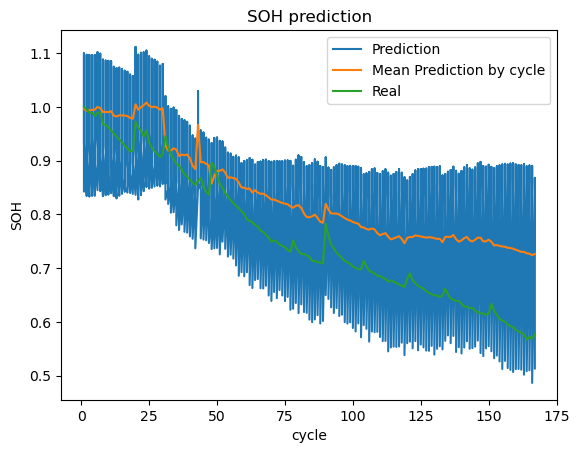

In [2452]:
my_train_m2.validation(b6_SOH_target, b6_validation_inputs, b6_cycle)

1506/1506 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.07249926236820602
Root Mean Square Error:  0.05753571714123315


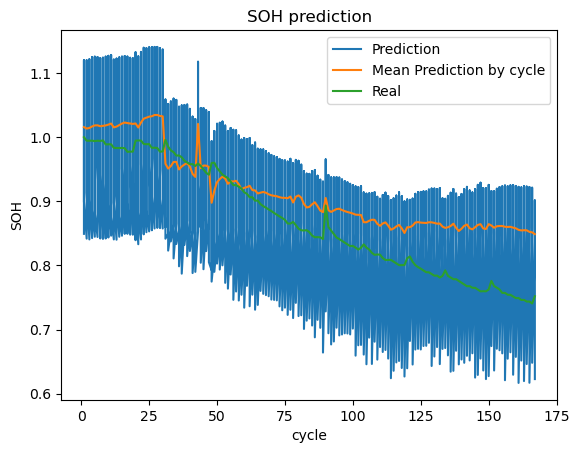

In [2454]:
my_train_m2.validation(b7_SOH_target, b7_validation_inputs, b7_cycle)

993/993 [==============================] - 1s 1ms/step
Root Mean Square Error:  0.10052192148801006
Root Mean Square Error:  0.10068587152492937


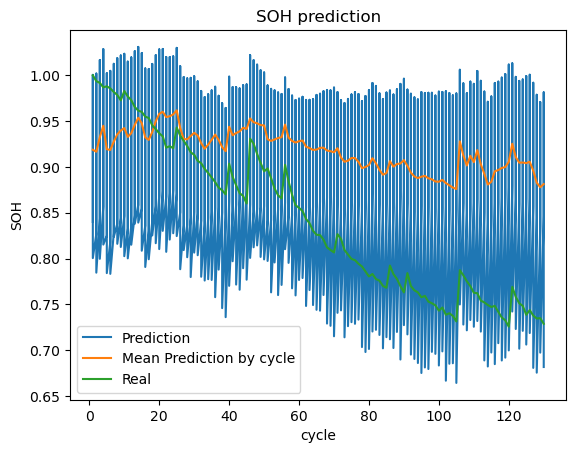

In [2455]:
my_train_m2.validation(b18_SOH_target, b18_validation_inputs, b18_cycle)

# the number of hidden layers and node? </br>
There is no universal method </br>
A reference: http://dstath.users.uth.gr/papers/IJRS2009_Stathakis.pdf </br>
The number of neurons in two hidden layer case $ 2\sqrt{(m+2)N}$ </br>
specifically, first node: $ \sqrt{(m+2)N}+\ 2\sqrt{N/(m+2)}$ </br>
second node: $ m\sqrt{N/(m+2)}$ </br>
**However, the methods are come from specific experimental results with specific problems** </br>
Thus, it may not work if problems will not the same as that in previous studies.

In [950]:
loss_list = []
epoch_list = []

input_layer_b7 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7 = keras.layers.Dense(10, activation='relu')(input_layer_b7)
output_layer_b7 = keras.layers.Dense(1, activation='sigmoid')(hidden_layer_b7)
model_b7 = keras.Model(input_layer_b7, output_layer_b7)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
my_train_b7 = custom_train(model_b7, optimizer, loss_function, metric)
model_b7.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_54 (Dense)            (None, 10)                60        
                                                                 
 dense_55 (Dense)            (None, 1)                 11        
                                                                 
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


In [990]:
loss_list, epoch_list = my_train_b7.train(b7_train_inputs, b7_train_SOH, 10000, 200, 0.0001)

Training acc over epoch: 0.0300 Training loss (for one batch) at step 0: 0.0018 Time taken: 0.01s 
Training acc over epoch: 0.0297 Training loss (for one batch) at step 200: 0.0018 Time taken: 2.83s 
Training acc over epoch: 0.0295 Training loss (for one batch) at step 400: 0.0017 Time taken: 5.60s 
Training acc over epoch: 0.0292 Training loss (for one batch) at step 600: 0.0017 Time taken: 8.44s 
Training acc over epoch: 0.0290 Training loss (for one batch) at step 800: 0.0017 Time taken: 11.18s 
Training acc over epoch: 0.0288 Training loss (for one batch) at step 1000: 0.0017 Time taken: 13.91s 
Training acc over epoch: 0.0287 Training loss (for one batch) at step 1200: 0.0016 Time taken: 16.63s 
Training acc over epoch: 0.0285 Training loss (for one batch) at step 1400: 0.0016 Time taken: 19.41s 
Training acc over epoch: 0.0284 Training loss (for one batch) at step 1600: 0.0016 Time taken: 22.24s 
Training acc over epoch: 0.0283 Training loss (for one batch) at step 1800: 0.0016 T

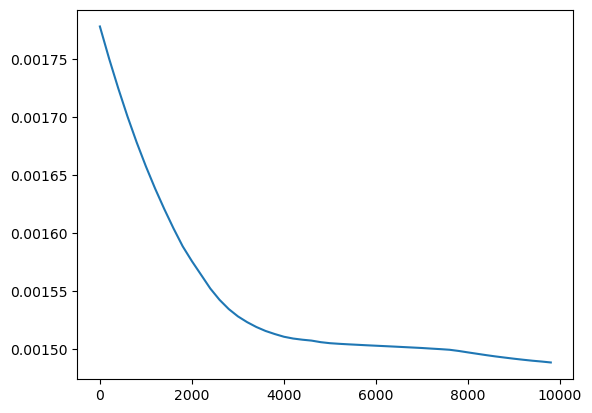

In [991]:
plt.plot(epoch_list, loss_list)

In [992]:
b6_SOH_target, b6_inputs = inout_dataframe(b6_discharge, 2.5)

b6_validation_inputs = b6_inputs[input_attributes]
b6_validation_inputs  = scale.fit_transform(b6_validation_inputs)
print(b6_SOH_target.shape,b6_inputs.shape, b6_validation_inputs.shape)

(44291, 1) (44291, 6) (44291, 5)


1385/1385 [==============================] - 1s 946us/step
Root Mean Square Error:  0.12607889423369528


Text(0.5, 1.0, 'SOH real-time prediction')

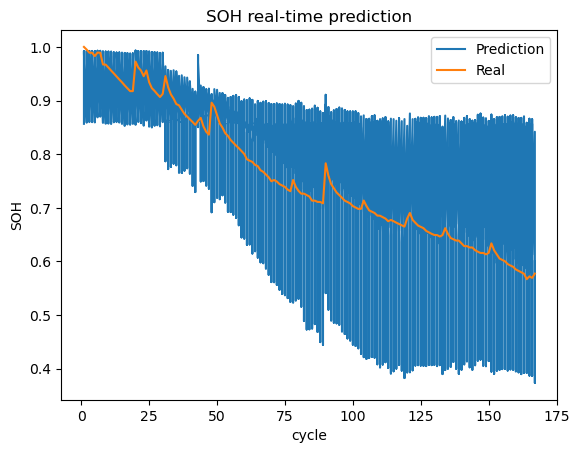

In [993]:
b6_SOH_predict = model_b7.predict(b6_validation_inputs)


b6_SOH_validation = b6_inputs.loc[(b6_inputs['cycle'] >= 1), ['cycle']]
b6_SOH_validation['SOH_predict'] = b6_SOH_predict
b6_SOH_validation['SOH_target'] = b6_SOH_target.to_numpy()
b6_SOH_validation
rms = np.sqrt(mean_squared_error(b6_SOH_validation['SOH_predict'], b6_SOH_validation['SOH_target']))
print('Root Mean Square Error: ', rms)

plt.plot(b6_SOH_validation['cycle'], b6_SOH_validation['SOH_predict'])
plt.plot(b6_SOH_validation['cycle'], b6_SOH_validation['SOH_target'])
plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['Prediction', 'Real'])
plt.title('SOH real-time prediction')

Root Mean Square Error:  0.09642640790376765


Text(0.5, 1.0, 'SOH real-time prediction')

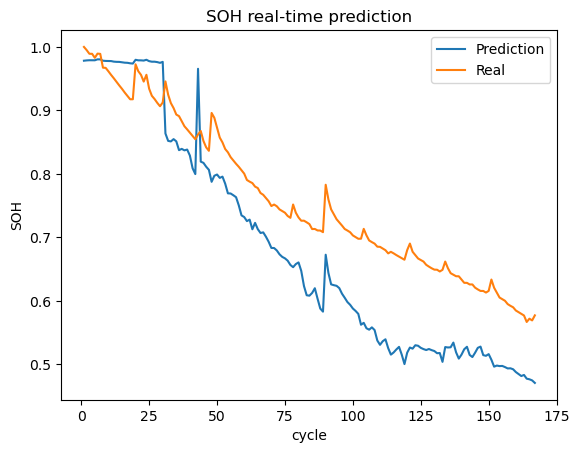

In [994]:
b6_SOH_validation_mean = b6_SOH_validation.groupby(['cycle']).mean().reset_index()
b6_SOH_validation_mean
rms = np.sqrt(mean_squared_error(b6_SOH_validation_mean['SOH_predict'], b6_SOH_validation_mean['SOH_target']))

print('Root Mean Square Error: ', rms)
plt.plot(b6_SOH_validation_mean['cycle'], b6_SOH_validation_mean['SOH_predict'])
plt.plot(b6_SOH_validation_mean['cycle'], b6_SOH_validation_mean['SOH_target'])
plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['Prediction', 'Real'])
plt.title('SOH real-time prediction')

In [995]:
b7_SOH_predict = model_b7.predict(b7_validation_inputs)

1499/1499 [==============================] - 1s 905us/step


Root Mean Square Error:  0.10160740895662564
Root Mean Square Error:  0.07731907604177506


Text(0.5, 1.0, 'SOH real-time prediction')

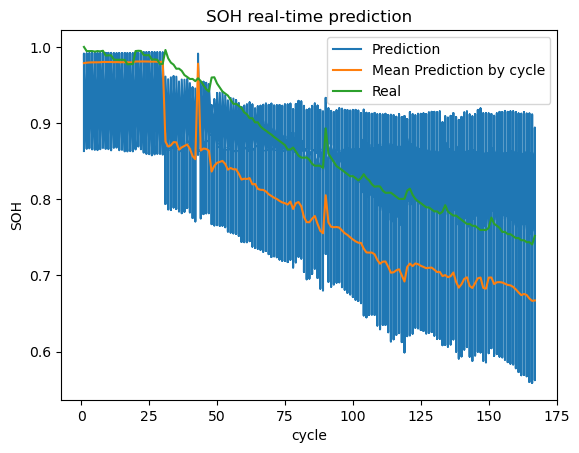

In [1014]:
b7_SOH_validation = b7_inputs.loc[(b7_inputs['cycle'] >= 1), ['cycle']]
b7_SOH_validation['SOH_predict'] = b7_SOH_predict
b7_SOH_validation['SOH_target'] = b7_SOH_target.to_numpy()
b7_SOH_validation
rms = np.sqrt(mean_squared_error(b7_SOH_validation['SOH_predict'], b7_SOH_validation['SOH_target']))
print('Root Mean Square Error: ', rms)

b7_SOH_validation_mean = b7_SOH_validation.groupby(['cycle']).mean().reset_index()
rms = np.sqrt(mean_squared_error(b7_SOH_validation_mean['SOH_predict'], b7_SOH_validation_mean['SOH_target']))
print('Root Mean Square Error: ', rms)


plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_predict'])
plt.plot(b7_SOH_validation_mean['cycle'], b7_SOH_validation_mean['SOH_predict'])
plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_target'])

plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['Prediction', 'Mean Prediction by cycle', 'Real'])
plt.title('SOH real-time prediction')

In [1015]:
b7_SOH_target, b7_inputs = inout_dataframe(b7_discharge, 2.5)

b7_validation_inputs = b7_inputs[input_attributes]
b7_validation_inputs  = scale.fit_transform(b7_validation_inputs)

Root Mean Square Error:  0.09642640790376765


Text(0.5, 1.0, 'SOH real-time prediction')

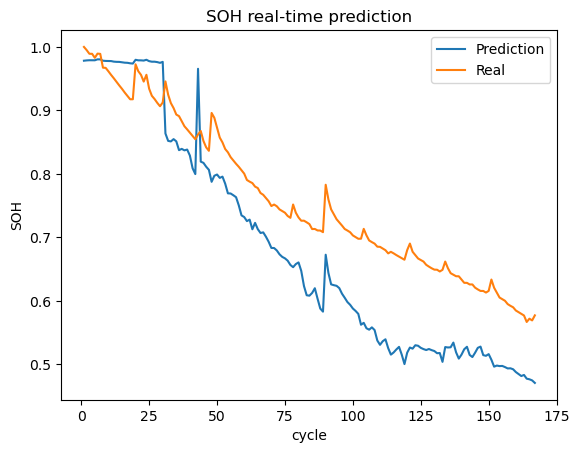

In [1016]:
b7_SOH_validation_mean = b7_SOH_validation.groupby(['cycle']).mean().reset_index()
b7_SOH_validation_mean
rms = np.sqrt(mean_squared_error(b6_SOH_validation_mean['SOH_predict'], b6_SOH_validation_mean['SOH_target']))

print('Root Mean Square Error: ', rms)
plt.plot(b6_SOH_validation_mean['cycle'], b6_SOH_validation_mean['SOH_predict'])
plt.plot(b6_SOH_validation_mean['cycle'], b6_SOH_validation_mean['SOH_target'])
plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['Prediction', 'Real'])
plt.title('SOH real-time prediction')

# Two hidden layer

In [1039]:
input_layer_b7_2h = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_2h = keras.layers.Dense(10, activation='relu')(input_layer_b7_2h)
hidden_layer2_b7_2h = keras.layers.Dense(10, activation='relu')(hidden_layer_b7_2h)
output_layer_b7_2h = keras.layers.Dense(1, activation='sigmoid')(hidden_layer2_b7_2h)
model_b7_2h = keras.Model(input_layer_b7_2h, output_layer_b7_2h)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
my_train_b7_2h = custom_train(model_b7_2h, optimizer, loss_function, metric)
model_b7_2h.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_66 (Dense)            (None, 10)                60        
                                                                 
 dense_67 (Dense)            (None, 10)                110       
                                                                 
 dense_68 (Dense)            (None, 1)                 11        
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [1044]:
loss_list, epoch_list = my_train_b7_2h.train(b7_train_inputs, b7_train_SOH, 5000, 200, 0.0001)

Training acc over epoch: 0.0118 Training loss (for one batch) at step 0: 0.0004 Time taken: 0.02s 
Training acc over epoch: 0.0117 Training loss (for one batch) at step 200: 0.0004 Time taken: 2.84s 
Training acc over epoch: 0.0116 Training loss (for one batch) at step 400: 0.0004 Time taken: 5.75s 
Training acc over epoch: 0.0116 Training loss (for one batch) at step 600: 0.0004 Time taken: 8.53s 
Training acc over epoch: 0.0113 Training loss (for one batch) at step 800: 0.0004 Time taken: 11.25s 
Training acc over epoch: 0.0112 Training loss (for one batch) at step 1000: 0.0004 Time taken: 14.03s 
Training acc over epoch: 0.0111 Training loss (for one batch) at step 1200: 0.0003 Time taken: 16.78s 
Training acc over epoch: 0.0111 Training loss (for one batch) at step 1400: 0.0003 Time taken: 19.64s 
Training acc over epoch: 0.0111 Training loss (for one batch) at step 1600: 0.0003 Time taken: 22.51s 
Training acc over epoch: 0.0111 Training loss (for one batch) at step 1800: 0.0003 T

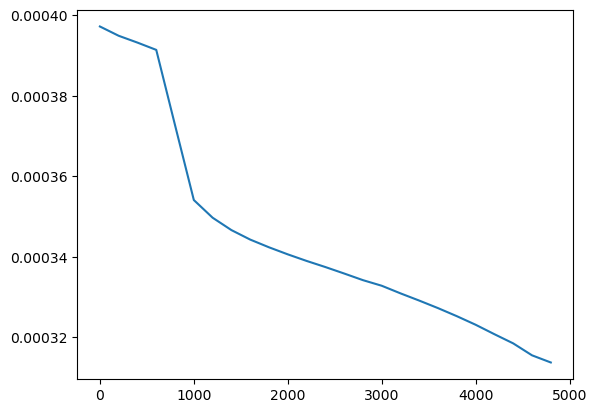

In [1045]:
plt.plot(epoch_list, loss_list)

1499/1499 [==============================] - 1s 971us/step
Root Mean Square Error:  0.11754614806030399
Root Mean Square Error:  0.09985035099040623


Text(0.5, 1.0, 'SOH real-time prediction')

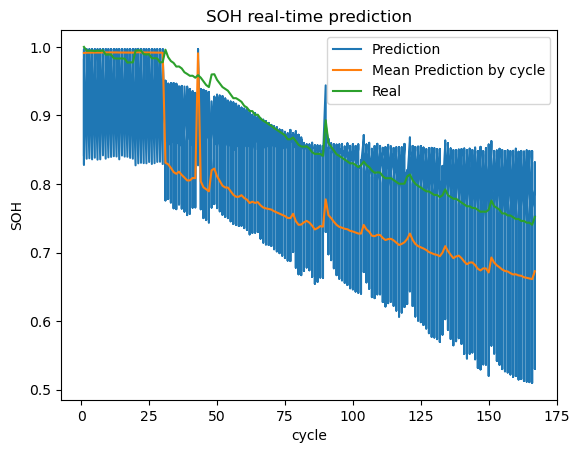

In [1046]:
b7_SOH_predict = model_b7_2h.predict(b7_validation_inputs)

b7_SOH_validation = b7_inputs.loc[(b7_inputs['cycle'] >= 1), ['cycle']]
b7_SOH_validation['SOH_predict'] = b7_SOH_predict
b7_SOH_validation['SOH_target'] = b7_SOH_target.to_numpy()

rms = np.sqrt(mean_squared_error(b7_SOH_validation['SOH_predict'], b7_SOH_validation['SOH_target']))
print('Root Mean Square Error: ', rms)

b7_SOH_validation_mean = b7_SOH_validation.groupby(['cycle']).mean().reset_index()
rms = np.sqrt(mean_squared_error(b7_SOH_validation_mean['SOH_predict'], b7_SOH_validation_mean['SOH_target']))
print('Root Mean Square Error: ', rms)


plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_predict'])
plt.plot(b7_SOH_validation_mean['cycle'], b7_SOH_validation_mean['SOH_predict'])
plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_target'])

plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['Prediction', 'Mean Prediction by cycle', 'Real'])
plt.title('SOH real-time prediction')

# Three hidden layer

In [1047]:
input_layer_b7_h3 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3 = keras.layers.Dense(10, activation='relu')(input_layer_b7_h3)
hidden_layer2_b7_h3 = keras.layers.Dense(10, activation='relu')(hidden_layer_b7_h3)
hidden_layer3_b7_h3 = keras.layers.Dense(10, activation='relu')(hidden_layer2_b7_h3)
output_layer_b7_h3 = keras.layers.Dense(1, activation='sigmoid')(hidden_layer3_b7_h3)
model_b7_h3 = keras.Model(input_layer_b7_h3, output_layer_b7_h3)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
my_train_b7_h3 = custom_train(model_b7_h3, optimizer, loss_function, metric)
model_b7_h3.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_69 (Dense)            (None, 10)                60        
                                                                 
 dense_70 (Dense)            (None, 10)                110       
                                                                 
 dense_71 (Dense)            (None, 10)                110       
                                                                 
 dense_72 (Dense)            (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [1051]:
loss_list, epoch_list = my_train_b7_h3.train(b7_train_inputs, b7_train_SOH, 5000, 200, 0.0001)

Training acc over epoch: 0.0132 Training loss (for one batch) at step 0: 0.0004 Time taken: 0.02s 
Training acc over epoch: 0.0138 Training loss (for one batch) at step 200: 0.0005 Time taken: 3.04s 
Training acc over epoch: 0.0131 Training loss (for one batch) at step 400: 0.0004 Time taken: 5.97s 
Training acc over epoch: 0.0130 Training loss (for one batch) at step 600: 0.0004 Time taken: 8.88s 
Training acc over epoch: 0.0129 Training loss (for one batch) at step 800: 0.0004 Time taken: 11.85s 
Training acc over epoch: 0.0129 Training loss (for one batch) at step 1000: 0.0004 Time taken: 14.64s 
Training acc over epoch: 0.0128 Training loss (for one batch) at step 1200: 0.0004 Time taken: 17.49s 
Training acc over epoch: 0.0127 Training loss (for one batch) at step 1400: 0.0004 Time taken: 20.31s 
Training acc over epoch: 0.0127 Training loss (for one batch) at step 1600: 0.0004 Time taken: 23.16s 
Training acc over epoch: 0.0126 Training loss (for one batch) at step 1800: 0.0004 T

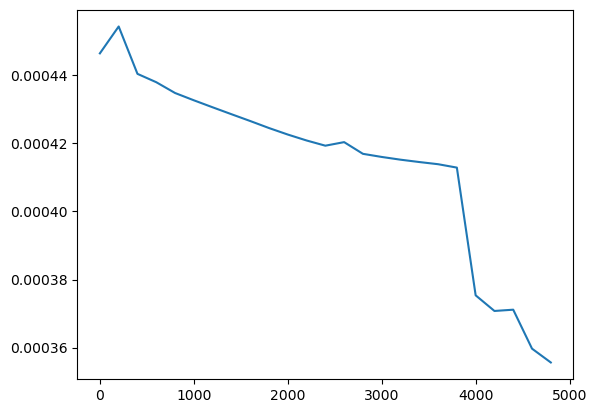

In [1052]:
plt.plot(epoch_list, loss_list)

1499/1499 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.10164405070847275
Root Mean Square Error:  0.08715742082527035


Text(0.5, 1.0, 'SOH real-time prediction')

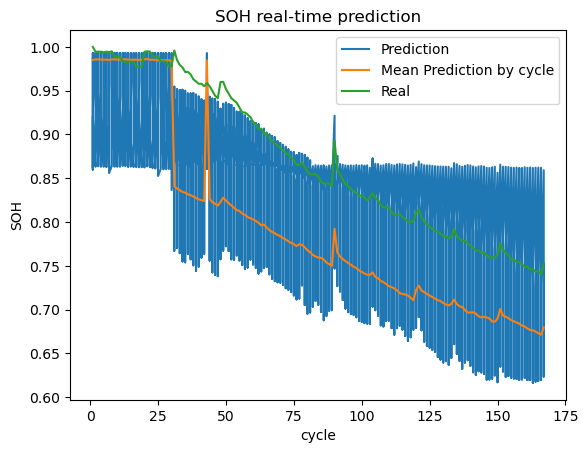

In [1092]:
b7_SOH_predict = model_b7_h3.predict(b7_validation_inputs)

b7_SOH_validation = b7_inputs.loc[(b7_inputs['cycle'] >= 1), ['cycle']]
b7_SOH_validation['SOH_predict'] = b7_SOH_predict
b7_SOH_validation['SOH_target'] = b7_SOH_target.to_numpy()
b7_SOH_validation
rms = np.sqrt(mean_squared_error(b7_SOH_validation['SOH_predict'], b7_SOH_validation['SOH_target']))
print('Root Mean Square Error: ', rms)

b7_SOH_validation_mean = b7_SOH_validation.groupby(['cycle']).mean().reset_index()
rms = np.sqrt(mean_squared_error(b7_SOH_validation_mean['SOH_predict'], b7_SOH_validation_mean['SOH_target']))
print('Root Mean Square Error: ', rms)


plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_predict'])
plt.plot(b7_SOH_validation_mean['cycle'], b7_SOH_validation_mean['SOH_predict'])
plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_target'])

plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['Prediction', 'Mean Prediction by cycle', 'Real'])
plt.title('SOH real-time prediction')

# Four hidden layer

In [1056]:
input_layer_b7_h4 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h4 = keras.layers.Dense(10, activation='relu')(input_layer_b7_h4)
hidden_layer2_b7_h4 = keras.layers.Dense(10, activation='relu')(hidden_layer_b7_h4)
hidden_layer3_b7_h4 = keras.layers.Dense(10, activation='relu')(hidden_layer2_b7_h4)
hidden_layer4_b7_h4 = keras.layers.Dense(10, activation='relu')(hidden_layer3_b7_h4)
output_layer_b7_h4 = keras.layers.Dense(1, activation='sigmoid')(hidden_layer4_b7_h4)
model_b7_h4 = keras.Model(input_layer_b7_h4, output_layer_b7_h4)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
my_train_b7_h4 = custom_train(model_b7_h4, optimizer, loss_function, metric)
model_b7_h4.summary()

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_83 (Dense)            (None, 10)                60        
                                                                 
 dense_84 (Dense)            (None, 10)                110       
                                                                 
 dense_85 (Dense)            (None, 10)                110       
                                                                 
 dense_86 (Dense)            (None, 10)                110       
                                                                 
 dense_87 (Dense)            (None, 1)                 11        
                                                                 
Total params: 401
Trainable params: 401
Non-trainable para

In [1111]:
loss_list, epoch_list = my_train_b7_h4.train(b7_train_inputs, b7_train_SOH, 100000, 200, 0.00001)

Training acc over epoch: 0.0095 Training loss (for one batch) at step 0: 0.0002 Time taken: 0.02s 
Training acc over epoch: 0.0091 Training loss (for one batch) at step 200: 0.0002 Time taken: 3.25s 
Training acc over epoch: 0.0091 Training loss (for one batch) at step 400: 0.0002 Time taken: 6.32s 
Training acc over epoch: 0.0094 Training loss (for one batch) at step 600: 0.0002 Time taken: 9.41s 
Training acc over epoch: 0.0090 Training loss (for one batch) at step 800: 0.0002 Time taken: 12.55s 
Training acc over epoch: 0.0090 Training loss (for one batch) at step 1000: 0.0002 Time taken: 15.78s 
Training acc over epoch: 0.0091 Training loss (for one batch) at step 1200: 0.0002 Time taken: 18.92s 
Training acc over epoch: 0.0090 Training loss (for one batch) at step 1400: 0.0002 Time taken: 22.05s 
Training acc over epoch: 0.0090 Training loss (for one batch) at step 1600: 0.0002 Time taken: 25.13s 
Training acc over epoch: 0.0090 Training loss (for one batch) at step 1800: 0.0002 T

Training acc over epoch: 0.0078 Training loss (for one batch) at step 15800: 0.0002 Time taken: 245.25s 
Training acc over epoch: 0.0076 Training loss (for one batch) at step 16000: 0.0002 Time taken: 248.33s 
Training acc over epoch: 0.0076 Training loss (for one batch) at step 16200: 0.0002 Time taken: 251.56s 
Training acc over epoch: 0.0076 Training loss (for one batch) at step 16400: 0.0002 Time taken: 254.75s 
Training acc over epoch: 0.0076 Training loss (for one batch) at step 16600: 0.0002 Time taken: 257.87s 
Training acc over epoch: 0.0083 Training loss (for one batch) at step 16800: 0.0002 Time taken: 260.91s 
Training acc over epoch: 0.0076 Training loss (for one batch) at step 17000: 0.0002 Time taken: 263.98s 
Training acc over epoch: 0.0081 Training loss (for one batch) at step 17200: 0.0002 Time taken: 267.06s 
Training acc over epoch: 0.0076 Training loss (for one batch) at step 17400: 0.0002 Time taken: 270.17s 
Training acc over epoch: 0.0076 Training loss (for one 

Training acc over epoch: 0.0074 Training loss (for one batch) at step 31600: 0.0001 Time taken: 489.80s 
Training acc over epoch: 0.0074 Training loss (for one batch) at step 31800: 0.0001 Time taken: 492.91s 
Training acc over epoch: 0.0075 Training loss (for one batch) at step 32000: 0.0002 Time taken: 496.12s 
Training acc over epoch: 0.0074 Training loss (for one batch) at step 32200: 0.0001 Time taken: 499.21s 
Training acc over epoch: 0.0074 Training loss (for one batch) at step 32400: 0.0001 Time taken: 502.24s 
Training acc over epoch: 0.0075 Training loss (for one batch) at step 32600: 0.0002 Time taken: 505.34s 
Training acc over epoch: 0.0074 Training loss (for one batch) at step 32800: 0.0001 Time taken: 508.39s 
Training acc over epoch: 0.0074 Training loss (for one batch) at step 33000: 0.0001 Time taken: 511.60s 
Training acc over epoch: 0.0073 Training loss (for one batch) at step 33200: 0.0001 Time taken: 514.76s 
Training acc over epoch: 0.0074 Training loss (for one 

Training acc over epoch: 0.0070 Training loss (for one batch) at step 47400: 0.0001 Time taken: 735.30s 
Training acc over epoch: 0.0071 Training loss (for one batch) at step 47600: 0.0001 Time taken: 738.31s 
Training acc over epoch: 0.0069 Training loss (for one batch) at step 47800: 0.0001 Time taken: 741.38s 
Training acc over epoch: 0.0070 Training loss (for one batch) at step 48000: 0.0001 Time taken: 744.42s 
Training acc over epoch: 0.0070 Training loss (for one batch) at step 48200: 0.0001 Time taken: 747.47s 
Training acc over epoch: 0.0070 Training loss (for one batch) at step 48400: 0.0001 Time taken: 750.67s 
Training acc over epoch: 0.0072 Training loss (for one batch) at step 48600: 0.0001 Time taken: 753.76s 
Training acc over epoch: 0.0071 Training loss (for one batch) at step 48800: 0.0001 Time taken: 756.80s 
Training acc over epoch: 0.0076 Training loss (for one batch) at step 49000: 0.0001 Time taken: 759.88s 
Training acc over epoch: 0.0069 Training loss (for one 

Training acc over epoch: 0.0068 Training loss (for one batch) at step 63200: 0.0001 Time taken: 981.20s 
Training acc over epoch: 0.0070 Training loss (for one batch) at step 63400: 0.0001 Time taken: 984.25s 
Training acc over epoch: 0.0070 Training loss (for one batch) at step 63600: 0.0001 Time taken: 987.35s 
Training acc over epoch: 0.0068 Training loss (for one batch) at step 63800: 0.0001 Time taken: 990.50s 
Training acc over epoch: 0.0068 Training loss (for one batch) at step 64000: 0.0001 Time taken: 993.60s 
Training acc over epoch: 0.0068 Training loss (for one batch) at step 64200: 0.0001 Time taken: 996.69s 
Training acc over epoch: 0.0070 Training loss (for one batch) at step 64400: 0.0001 Time taken: 999.71s 
Training acc over epoch: 0.0070 Training loss (for one batch) at step 64600: 0.0001 Time taken: 1002.76s 
Training acc over epoch: 0.0069 Training loss (for one batch) at step 64800: 0.0001 Time taken: 1005.83s 
Training acc over epoch: 0.0070 Training loss (for on

Training acc over epoch: 0.0069 Training loss (for one batch) at step 78800: 0.0001 Time taken: 1222.25s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 79000: 0.0001 Time taken: 1225.29s 
Training acc over epoch: 0.0067 Training loss (for one batch) at step 79200: 0.0001 Time taken: 1228.34s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 79400: 0.0001 Time taken: 1231.53s 
Training acc over epoch: 0.0067 Training loss (for one batch) at step 79600: 0.0001 Time taken: 1234.58s 
Training acc over epoch: 0.0067 Training loss (for one batch) at step 79800: 0.0001 Time taken: 1237.62s 
Training acc over epoch: 0.0067 Training loss (for one batch) at step 80000: 0.0001 Time taken: 1240.65s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 80200: 0.0001 Time taken: 1243.76s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 80400: 0.0001 Time taken: 1246.97s 
Training acc over epoch: 0.0067 Training loss 

Training acc over epoch: 0.0071 Training loss (for one batch) at step 94400: 0.0001 Time taken: 1463.86s 
Training acc over epoch: 0.0064 Training loss (for one batch) at step 94600: 0.0001 Time taken: 1466.89s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 94800: 0.0001 Time taken: 1470.06s 
Training acc over epoch: 0.0064 Training loss (for one batch) at step 95000: 0.0001 Time taken: 1473.19s 
Training acc over epoch: 0.0065 Training loss (for one batch) at step 95200: 0.0001 Time taken: 1476.21s 
Training acc over epoch: 0.0064 Training loss (for one batch) at step 95400: 0.0001 Time taken: 1479.30s 
Training acc over epoch: 0.0065 Training loss (for one batch) at step 95600: 0.0001 Time taken: 1482.33s 
Training acc over epoch: 0.0065 Training loss (for one batch) at step 95800: 0.0001 Time taken: 1485.41s 
Training acc over epoch: 0.0064 Training loss (for one batch) at step 96000: 0.0001 Time taken: 1488.58s 
Training acc over epoch: 0.0066 Training loss 

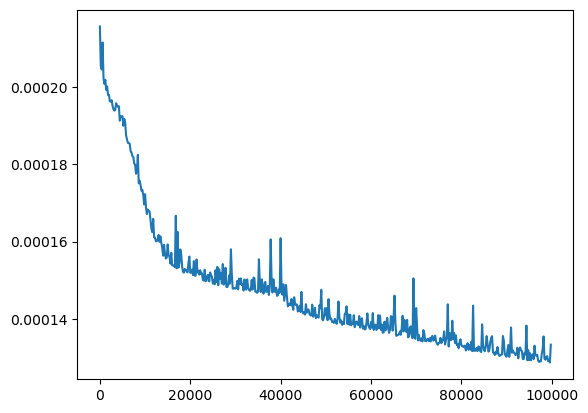

In [1112]:
plt.plot(epoch_list, loss_list)

1499/1499 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.13146664569523128
Root Mean Square Error:  0.11427644986739582


Text(0.5, 1.0, 'SOH real-time prediction')

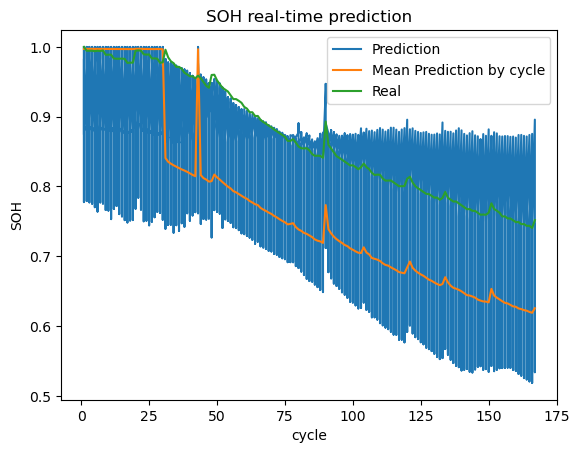

In [1113]:
b7_SOH_predict = model_b7_h4.predict(b7_validation_inputs)

b7_SOH_validation = b7_inputs.loc[(b7_inputs['cycle'] >= 1), ['cycle']]
b7_SOH_validation['SOH_predict'] = b7_SOH_predict
b7_SOH_validation['SOH_target'] = b7_SOH_target.to_numpy()
b7_SOH_validation
rms = np.sqrt(mean_squared_error(b7_SOH_validation['SOH_predict'], b7_SOH_validation['SOH_target']))
print('Root Mean Square Error: ', rms)

b7_SOH_validation_mean = b7_SOH_validation.groupby(['cycle']).mean().reset_index()
rms = np.sqrt(mean_squared_error(b7_SOH_validation_mean['SOH_predict'], b7_SOH_validation_mean['SOH_target']))
print('Root Mean Square Error: ', rms)


plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_predict'])
plt.plot(b7_SOH_validation_mean['cycle'], b7_SOH_validation_mean['SOH_predict'])
plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_target'])

plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['Prediction', 'Mean Prediction by cycle', 'Real'])
plt.title('SOH real-time prediction')

# three hidden layer, 20 dense

In [1064]:
input_layer_b7_h3_t20 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_t20 = keras.layers.Dense(20, activation='relu')(input_layer_b7_h3_t20)
hidden_layer2_b7_h3_t20 = keras.layers.Dense(20, activation='relu')(hidden_layer_b7_h3_t20)
hidden_layer3_b7_h3_t20 = keras.layers.Dense(20, activation='relu')(hidden_layer2_b7_h3_t20)
output_layer_b7_h3_t20 = keras.layers.Dense(1, activation='sigmoid')(hidden_layer3_b7_h3_t20)
model_b7_h3_t20 = keras.Model(input_layer_b7_h3_t20, output_layer_b7_h3_t20)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
my_train_b7_h3_t20 = custom_train(model_b7_h3_t20, optimizer, loss_function, metric)
model_b7_h3_t20.summary()

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_96 (Dense)            (None, 20)                120       
                                                                 
 dense_97 (Dense)            (None, 20)                420       
                                                                 
 dense_98 (Dense)            (None, 20)                420       
                                                                 
 dense_99 (Dense)            (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [1105]:
loss_list, epoch_list = my_train_b7_h3_t20.train(b7_train_inputs, b7_train_SOH, 10000, 200, 0.0001)

Training acc over epoch: 0.0075 Training loss (for one batch) at step 0: 0.0002 Time taken: 0.02s 
Training acc over epoch: 0.0075 Training loss (for one batch) at step 200: 0.0001 Time taken: 3.12s 
Training acc over epoch: 0.0073 Training loss (for one batch) at step 400: 0.0001 Time taken: 6.08s 
Training acc over epoch: 0.0073 Training loss (for one batch) at step 600: 0.0001 Time taken: 8.98s 
Training acc over epoch: 0.0075 Training loss (for one batch) at step 800: 0.0001 Time taken: 11.97s 
Training acc over epoch: 0.0073 Training loss (for one batch) at step 1000: 0.0001 Time taken: 14.83s 
Training acc over epoch: 0.0073 Training loss (for one batch) at step 1200: 0.0001 Time taken: 17.67s 
Training acc over epoch: 0.0072 Training loss (for one batch) at step 1400: 0.0001 Time taken: 20.72s 
Training acc over epoch: 0.0078 Training loss (for one batch) at step 1600: 0.0002 Time taken: 23.57s 
Training acc over epoch: 0.0072 Training loss (for one batch) at step 1800: 0.0001 T

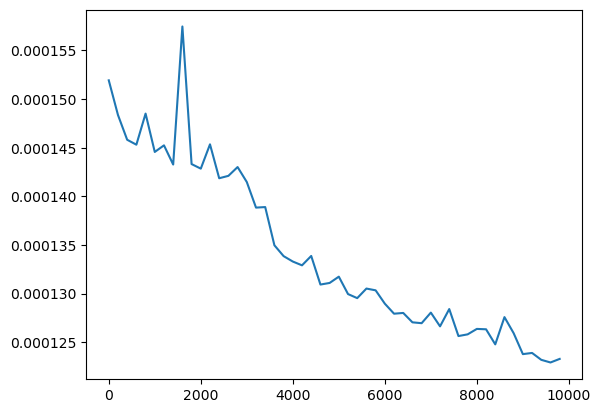

In [1106]:
plt.plot(epoch_list, loss_list)

1499/1499 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.1389613911037613
Root Mean Square Error:  0.12254133816429609


Text(0.5, 1.0, 'SOH real-time prediction')

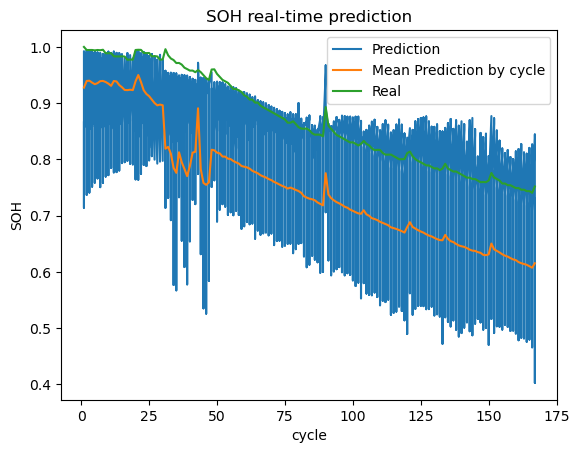

In [1107]:
b7_SOH_predict = model_b7_h3_t20.predict(b7_validation_inputs)

b7_SOH_validation = b7_inputs.loc[(b7_inputs['cycle'] >= 1), ['cycle']]
b7_SOH_validation['SOH_predict'] = b7_SOH_predict
b7_SOH_validation['SOH_target'] = b7_SOH_target.to_numpy()
b7_SOH_validation
rms = np.sqrt(mean_squared_error(b7_SOH_validation['SOH_predict'], b7_SOH_validation['SOH_target']))
print('Root Mean Square Error: ', rms)

b7_SOH_validation_mean = b7_SOH_validation.groupby(['cycle']).mean().reset_index()
rms = np.sqrt(mean_squared_error(b7_SOH_validation_mean['SOH_predict'], b7_SOH_validation_mean['SOH_target']))
print('Root Mean Square Error: ', rms)


plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_predict'])
plt.plot(b7_SOH_validation_mean['cycle'], b7_SOH_validation_mean['SOH_predict'])
plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_target'])

plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['Prediction', 'Mean Prediction by cycle', 'Real'])
plt.title('SOH real-time prediction')

# three hidden, 10 dense, sigmoid

In [1071]:
input_layer_b7_h3_sig = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_sig = keras.layers.Dense(10, activation='sigmoid')(input_layer_b7_h3_sig)
hidden_layer2_b7_h3_sig = keras.layers.Dense(10, activation='sigmoid')(hidden_layer_b7_h3_sig)
hidden_layer3_b7_h3_sig = keras.layers.Dense(10, activation='sigmoid')(hidden_layer2_b7_h3_sig)
output_layer_b7_h3_sig = keras.layers.Dense(1, activation='sigmoid')(hidden_layer3_b7_h3_sig)
model_b7_h3_sig = keras.Model(input_layer_b7_h3_sig, output_layer_b7_h3_sig)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
my_train_b7_h3_sig = custom_train(model_b7_h3_sig, optimizer, loss_function, metric)
model_b7_h3_sig.summary()

Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_100 (Dense)           (None, 10)                60        
                                                                 
 dense_101 (Dense)           (None, 10)                110       
                                                                 
 dense_102 (Dense)           (None, 10)                110       
                                                                 
 dense_103 (Dense)           (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [1079]:
loss_list, epoch_list = my_train_b7_h3_sig.train(b7_train_inputs, b7_train_SOH, 5000, 200, 0.0001)

Training acc over epoch: 0.0083 Training loss (for one batch) at step 0: 0.0002 Time taken: 0.02s 
Training acc over epoch: 0.0082 Training loss (for one batch) at step 200: 0.0002 Time taken: 3.04s 
Training acc over epoch: 0.0080 Training loss (for one batch) at step 400: 0.0002 Time taken: 6.11s 
Training acc over epoch: 0.0079 Training loss (for one batch) at step 600: 0.0002 Time taken: 9.26s 
Training acc over epoch: 0.0078 Training loss (for one batch) at step 800: 0.0002 Time taken: 12.11s 
Training acc over epoch: 0.0076 Training loss (for one batch) at step 1000: 0.0002 Time taken: 14.98s 
Training acc over epoch: 0.0075 Training loss (for one batch) at step 1200: 0.0002 Time taken: 17.80s 
Training acc over epoch: 0.0074 Training loss (for one batch) at step 1400: 0.0002 Time taken: 20.65s 
Training acc over epoch: 0.0073 Training loss (for one batch) at step 1600: 0.0002 Time taken: 23.52s 
Training acc over epoch: 0.0072 Training loss (for one batch) at step 1800: 0.0002 T

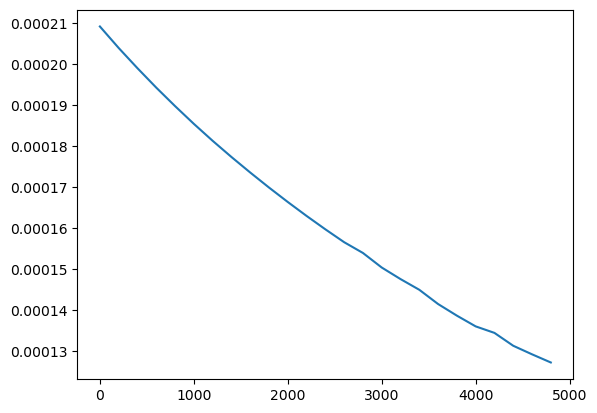

In [1080]:
plt.plot(epoch_list, loss_list)

1499/1499 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.12259336812253398
Root Mean Square Error:  0.11194377646674657


Text(0.5, 1.0, 'SOH real-time prediction')

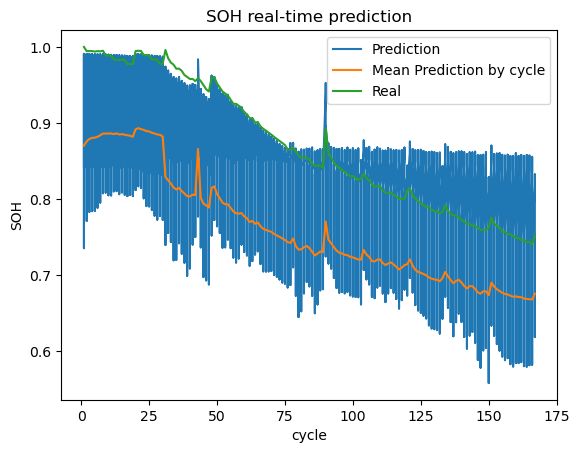

In [1089]:
b7_SOH_predict = model_b7_h3_sig.predict(b7_validation_inputs)

b7_SOH_validation = b7_inputs.loc[(b7_inputs['cycle'] >= 1), ['cycle']]
b7_SOH_validation['SOH_predict'] = b7_SOH_predict
b7_SOH_validation['SOH_target'] = b7_SOH_target.to_numpy()
b7_SOH_validation
rms = np.sqrt(mean_squared_error(b7_SOH_validation['SOH_predict'], b7_SOH_validation['SOH_target']))
print('Root Mean Square Error: ', rms)

b7_SOH_validation_mean = b7_SOH_validation.groupby(['cycle']).mean().reset_index()
rms = np.sqrt(mean_squared_error(b7_SOH_validation_mean['SOH_predict'], b7_SOH_validation_mean['SOH_target']))
print('Root Mean Square Error: ', rms)


plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_predict'])
plt.plot(b7_SOH_validation_mean['cycle'], b7_SOH_validation_mean['SOH_predict'])
plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_target'])

plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['Prediction', 'Mean Prediction by cycle', 'Real'])
plt.title('SOH real-time prediction')

In [1082]:
input_layer_b7_h3_no = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_no = keras.layers.Dense(10)(input_layer_b7_h3_no)
hidden_layer2_b7_h3_no = keras.layers.Dense(10)(hidden_layer_b7_h3_no)
hidden_layer3_b7_h3_no = keras.layers.Dense(10)(hidden_layer2_b7_h3_no)
output_layer_b7_h3_no = keras.layers.Dense(1, activation='sigmoid')(hidden_layer3_b7_h3_no)
model_b7_h3_no = keras.Model(input_layer_b7_h3_no, output_layer_b7_h3_no)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
my_train_b7_h3_no = custom_train(model_b7_h3_no, optimizer, loss_function, metric)
model_b7_h3_no.summary()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_104 (Dense)           (None, 10)                60        
                                                                 
 dense_105 (Dense)           (None, 10)                110       
                                                                 
 dense_106 (Dense)           (None, 10)                110       
                                                                 
 dense_107 (Dense)           (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [1093]:
loss_list, epoch_list = my_train_b7_h3_no.train(b7_train_inputs, b7_train_SOH, 1000, 200, 0.0001)

Training acc over epoch: 0.0392 Training loss (for one batch) at step 0: 0.0028 Time taken: 0.02s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 200: 0.0028 Time taken: 3.10s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 400: 0.0028 Time taken: 6.09s 
Training acc over epoch: 0.0391 Training loss (for one batch) at step 600: 0.0028 Time taken: 9.02s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 800: 0.0028 Time taken: 12.05s 


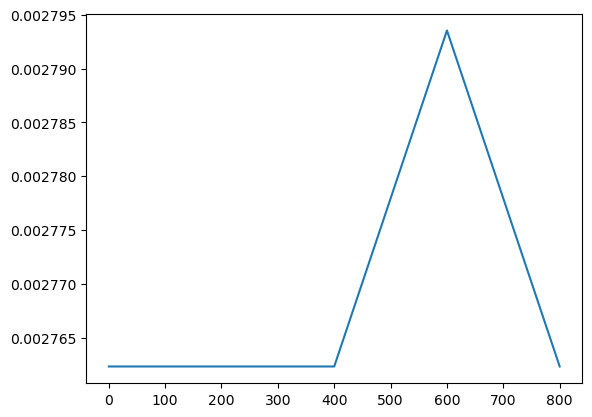

In [1094]:
plt.plot(epoch_list, loss_list)

1499/1499 [==============================] - 2s 990us/step
Root Mean Square Error:  0.05337036152133276
Root Mean Square Error:  0.04170778257748152


Text(0.5, 1.0, 'SOH real-time prediction')

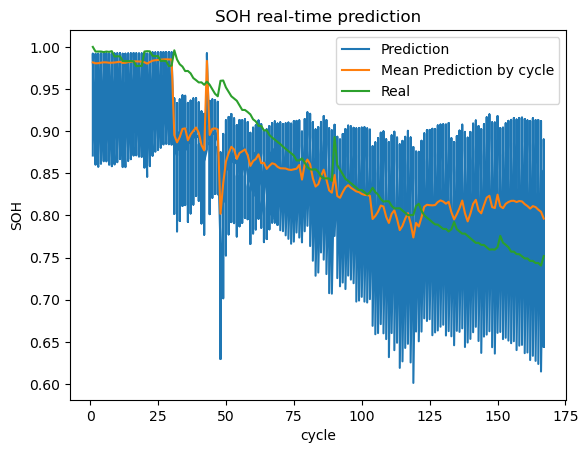

In [1095]:
b7_SOH_predict = model_b7_h3_no.predict(b7_validation_inputs)

b7_SOH_validation = b7_inputs.loc[(b7_inputs['cycle'] >= 1), ['cycle']]
b7_SOH_validation['SOH_predict'] = b7_SOH_predict
b7_SOH_validation['SOH_target'] = b7_SOH_target.to_numpy()
b7_SOH_validation
rms = np.sqrt(mean_squared_error(b7_SOH_validation['SOH_predict'], b7_SOH_validation['SOH_target']))
print('Root Mean Square Error: ', rms)

b7_SOH_validation_mean = b7_SOH_validation.groupby(['cycle']).mean().reset_index()
rms = np.sqrt(mean_squared_error(b7_SOH_validation_mean['SOH_predict'], b7_SOH_validation_mean['SOH_target']))
print('Root Mean Square Error: ', rms)


plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_predict'])
plt.plot(b7_SOH_validation_mean['cycle'], b7_SOH_validation_mean['SOH_predict'])
plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_target'])

plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['Prediction', 'Mean Prediction by cycle', 'Real'])
plt.title('SOH real-time prediction')

# four hidden layer, no activation

In [1097]:
input_layer_b7_h4_no = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h4_no = keras.layers.Dense(10)(input_layer_b7_h4_no)
hidden_layer2_b7_h4_no = keras.layers.Dense(10)(hidden_layer_b7_h4_no)
hidden_layer3_b7_h4_no = keras.layers.Dense(10)(hidden_layer2_b7_h4_no)
hidden_layer4_b7_h4_no = keras.layers.Dense(10)(hidden_layer3_b7_h4_no)
output_layer_b7_h4_no = keras.layers.Dense(1, activation='sigmoid')(hidden_layer4_b7_h4_no)
model_b7_h4_no = keras.Model(input_layer_b7_h4_no, output_layer_b7_h4_no)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
my_train_b7_h4_no = custom_train(model_b7_h4_no, optimizer, loss_function, metric)
model_b7_h4_no.summary()

Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_108 (Dense)           (None, 10)                60        
                                                                 
 dense_109 (Dense)           (None, 10)                110       
                                                                 
 dense_110 (Dense)           (None, 10)                110       
                                                                 
 dense_111 (Dense)           (None, 10)                110       
                                                                 
 dense_112 (Dense)           (None, 1)                 11        
                                                                 
Total params: 401
Trainable params: 401
Non-trainable para

In [1114]:
loss_list, epoch_list = my_train_b7_h4_no.train(b7_train_inputs, b7_train_SOH, 100000, 200, 0.00001)

Training acc over epoch: 0.0392 Training loss (for one batch) at step 0: 0.0028 Time taken: 0.02s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 200: 0.0028 Time taken: 3.18s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 400: 0.0028 Time taken: 6.20s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 600: 0.0028 Time taken: 9.35s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 800: 0.0028 Time taken: 12.34s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 1000: 0.0028 Time taken: 15.29s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 1200: 0.0028 Time taken: 18.26s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 1400: 0.0028 Time taken: 21.24s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 1600: 0.0028 Time taken: 24.24s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 1800: 0.0028 T

Training acc over epoch: 0.0392 Training loss (for one batch) at step 15800: 0.0028 Time taken: 237.31s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 16000: 0.0028 Time taken: 240.25s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 16200: 0.0028 Time taken: 243.47s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 16400: 0.0028 Time taken: 246.42s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 16600: 0.0028 Time taken: 249.56s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 16800: 0.0028 Time taken: 252.49s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 17000: 0.0028 Time taken: 255.47s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 17200: 0.0028 Time taken: 258.39s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 17400: 0.0028 Time taken: 261.35s 
Training acc over epoch: 0.0392 Training loss (for one 

Training acc over epoch: 0.0392 Training loss (for one batch) at step 31600: 0.0028 Time taken: 474.13s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 31800: 0.0028 Time taken: 477.09s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 32000: 0.0028 Time taken: 480.04s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 32200: 0.0028 Time taken: 482.99s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 32400: 0.0028 Time taken: 485.93s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 32600: 0.0028 Time taken: 489.02s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 32800: 0.0028 Time taken: 492.05s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 33000: 0.0028 Time taken: 494.98s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 33200: 0.0028 Time taken: 497.93s 
Training acc over epoch: 0.0392 Training loss (for one 

Training acc over epoch: 0.0392 Training loss (for one batch) at step 47400: 0.0028 Time taken: 710.49s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 47600: 0.0028 Time taken: 713.60s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 47800: 0.0028 Time taken: 716.57s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 48000: 0.0028 Time taken: 719.52s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 48200: 0.0028 Time taken: 722.59s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 48400: 0.0028 Time taken: 725.89s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 48600: 0.0028 Time taken: 729.17s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 48800: 0.0028 Time taken: 732.40s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 49000: 0.0028 Time taken: 735.48s 
Training acc over epoch: 0.0392 Training loss (for one 

Training acc over epoch: 0.0392 Training loss (for one batch) at step 63200: 0.0028 Time taken: 948.84s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 63400: 0.0028 Time taken: 951.81s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 63600: 0.0028 Time taken: 954.89s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 63800: 0.0028 Time taken: 957.83s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 64000: 0.0028 Time taken: 960.78s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 64200: 0.0028 Time taken: 963.76s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 64400: 0.0028 Time taken: 966.70s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 64600: 0.0028 Time taken: 970.14s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 64800: 0.0028 Time taken: 973.19s 
Training acc over epoch: 0.0392 Training loss (for one 

Training acc over epoch: 0.0392 Training loss (for one batch) at step 78800: 0.0028 Time taken: 1182.65s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 79000: 0.0028 Time taken: 1185.60s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 79200: 0.0028 Time taken: 1188.53s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 79400: 0.0028 Time taken: 1191.54s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 79600: 0.0028 Time taken: 1194.60s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 79800: 0.0028 Time taken: 1197.63s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 80000: 0.0028 Time taken: 1200.68s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 80200: 0.0028 Time taken: 1203.67s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 80400: 0.0028 Time taken: 1206.60s 
Training acc over epoch: 0.0392 Training loss 

Training acc over epoch: 0.0392 Training loss (for one batch) at step 94400: 0.0028 Time taken: 1416.55s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 94600: 0.0028 Time taken: 1419.57s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 94800: 0.0028 Time taken: 1422.57s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 95000: 0.0028 Time taken: 1425.53s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 95200: 0.0028 Time taken: 1428.59s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 95400: 0.0028 Time taken: 1431.58s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 95600: 0.0028 Time taken: 1434.64s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 95800: 0.0028 Time taken: 1437.59s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 96000: 0.0028 Time taken: 1440.53s 
Training acc over epoch: 0.0392 Training loss 

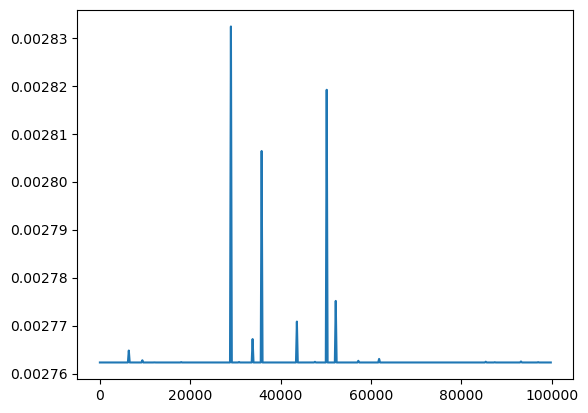

In [1115]:
plt.plot(epoch_list, loss_list)

1499/1499 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.05337036664225371
Root Mean Square Error:  0.041707769910136534


Text(0.5, 1.0, 'SOH real-time prediction')

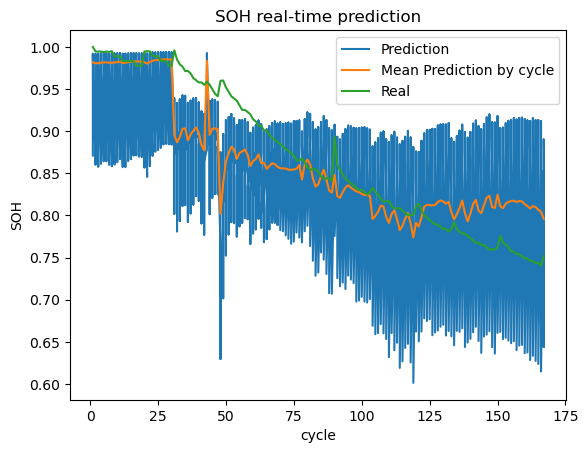

In [1116]:
b7_SOH_predict = model_b7_h4_no.predict(b7_validation_inputs)

b7_SOH_validation = b7_inputs.loc[(b7_inputs['cycle'] >= 1), ['cycle']]
b7_SOH_validation['SOH_predict'] = b7_SOH_predict
b7_SOH_validation['SOH_target'] = b7_SOH_target.to_numpy()
b7_SOH_validation
rms = np.sqrt(mean_squared_error(b7_SOH_validation['SOH_predict'], b7_SOH_validation['SOH_target']))
print('Root Mean Square Error: ', rms)

b7_SOH_validation_mean = b7_SOH_validation.groupby(['cycle']).mean().reset_index()
rms = np.sqrt(mean_squared_error(b7_SOH_validation_mean['SOH_predict'], b7_SOH_validation_mean['SOH_target']))
print('Root Mean Square Error: ', rms)


plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_predict'])
plt.plot(b7_SOH_validation_mean['cycle'], b7_SOH_validation_mean['SOH_predict'])
plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_target'])

plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['Prediction', 'Mean Prediction by cycle', 'Real'])
plt.title('SOH real-time prediction')

In [1117]:
input_layer_b7_h3_no_noo = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_no_noo = keras.layers.Dense(10)(input_layer_b7_h3_no_noo)
hidden_layer2_b7_h3_no_noo = keras.layers.Dense(10)(hidden_layer_b7_h3_no_noo)
hidden_layer3_b7_h3_no_noo = keras.layers.Dense(10)(hidden_layer2_b7_h3_no_noo)
output_layer_b7_h3_no_noo = keras.layers.Dense(1)(hidden_layer3_b7_h3_no_noo)
model_b7_h3_no_noo = keras.Model(input_layer_b7_h3_no_noo, output_layer_b7_h3_no_noo)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
my_train_b7_h3_no_noo = custom_train(model_b7_h3_no_noo, optimizer, loss_function, metric)
model_b7_h3_no_noo.summary()

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_113 (Dense)           (None, 10)                60        
                                                                 
 dense_114 (Dense)           (None, 10)                110       
                                                                 
 dense_115 (Dense)           (None, 10)                110       
                                                                 
 dense_116 (Dense)           (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [1118]:
loss_list, epoch_list = my_train_b7_h3_no_noo.train(b7_train_inputs, b7_train_SOH, 100000, 200, 0.00001)

Training acc over epoch: 0.2493 Training loss (for one batch) at step 0: 0.0748 Time taken: 0.03s 
Training acc over epoch: 0.0704 Training loss (for one batch) at step 200: 0.0067 Time taken: 3.08s 
Training acc over epoch: 0.0606 Training loss (for one batch) at step 400: 0.0048 Time taken: 6.00s 
Training acc over epoch: 0.0516 Training loss (for one batch) at step 600: 0.0037 Time taken: 9.00s 
Training acc over epoch: 0.0461 Training loss (for one batch) at step 800: 0.0033 Time taken: 11.92s 
Training acc over epoch: 0.0435 Training loss (for one batch) at step 1000: 0.0030 Time taken: 15.27s 
Training acc over epoch: 0.0422 Training loss (for one batch) at step 1200: 0.0029 Time taken: 18.21s 
Training acc over epoch: 0.0412 Training loss (for one batch) at step 1400: 0.0029 Time taken: 21.04s 
Training acc over epoch: 0.0404 Training loss (for one batch) at step 1600: 0.0028 Time taken: 23.86s 
Training acc over epoch: 0.0398 Training loss (for one batch) at step 1800: 0.0028 T

Training acc over epoch: 0.0392 Training loss (for one batch) at step 15800: 0.0028 Time taken: 234.79s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 16000: 0.0028 Time taken: 237.78s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 16200: 0.0028 Time taken: 240.77s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 16400: 0.0028 Time taken: 243.73s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 16600: 0.0028 Time taken: 246.60s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 16800: 0.0028 Time taken: 249.49s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 17000: 0.0028 Time taken: 252.43s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 17200: 0.0028 Time taken: 255.49s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 17400: 0.0028 Time taken: 258.41s 
Training acc over epoch: 0.0392 Training loss (for one 

Training acc over epoch: 0.0392 Training loss (for one batch) at step 31600: 0.0028 Time taken: 468.46s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 31800: 0.0028 Time taken: 471.37s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 32000: 0.0028 Time taken: 474.28s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 32200: 0.0028 Time taken: 477.21s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 32400: 0.0028 Time taken: 480.30s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 32600: 0.0028 Time taken: 483.21s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 32800: 0.0028 Time taken: 486.12s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 33000: 0.0028 Time taken: 489.09s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 33200: 0.0028 Time taken: 492.00s 
Training acc over epoch: 0.0392 Training loss (for one 

Training acc over epoch: 0.0392 Training loss (for one batch) at step 47400: 0.0028 Time taken: 703.72s 
Training acc over epoch: 0.0391 Training loss (for one batch) at step 47600: 0.0028 Time taken: 706.63s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 47800: 0.0028 Time taken: 709.54s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 48000: 0.0028 Time taken: 712.42s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 48200: 0.0028 Time taken: 715.40s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 48400: 0.0028 Time taken: 718.40s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 48600: 0.0028 Time taken: 721.37s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 48800: 0.0028 Time taken: 724.28s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 49000: 0.0028 Time taken: 727.20s 
Training acc over epoch: 0.0392 Training loss (for one 

Training acc over epoch: 0.0392 Training loss (for one batch) at step 63200: 0.0028 Time taken: 937.28s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 63400: 0.0028 Time taken: 940.16s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 63600: 0.0028 Time taken: 943.27s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 63800: 0.0028 Time taken: 946.18s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 64000: 0.0028 Time taken: 949.06s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 64200: 0.0028 Time taken: 951.99s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 64400: 0.0028 Time taken: 954.91s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 64600: 0.0028 Time taken: 957.87s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 64800: 0.0028 Time taken: 960.86s 
Training acc over epoch: 0.0392 Training loss (for one 

Training acc over epoch: 0.0392 Training loss (for one batch) at step 78800: 0.0028 Time taken: 1167.27s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 79000: 0.0028 Time taken: 1170.23s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 79200: 0.0028 Time taken: 1173.13s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 79400: 0.0028 Time taken: 1176.01s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 79600: 0.0028 Time taken: 1178.97s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 79800: 0.0028 Time taken: 1182.42s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 80000: 0.0028 Time taken: 1185.49s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 80200: 0.0028 Time taken: 1188.37s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 80400: 0.0028 Time taken: 1191.28s 
Training acc over epoch: 0.0392 Training loss 

Training acc over epoch: 0.0392 Training loss (for one batch) at step 94400: 0.0028 Time taken: 1398.16s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 94600: 0.0028 Time taken: 1401.04s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 94800: 0.0028 Time taken: 1404.01s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 95000: 0.0028 Time taken: 1407.12s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 95200: 0.0028 Time taken: 1410.05s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 95400: 0.0028 Time taken: 1412.97s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 95600: 0.0028 Time taken: 1415.90s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 95800: 0.0028 Time taken: 1418.81s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 96000: 0.0028 Time taken: 1421.78s 
Training acc over epoch: 0.0392 Training loss 

1499/1499 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.05337036513907171
Root Mean Square Error:  0.0417077710657892


Text(0.5, 1.0, 'SOH real-time prediction')

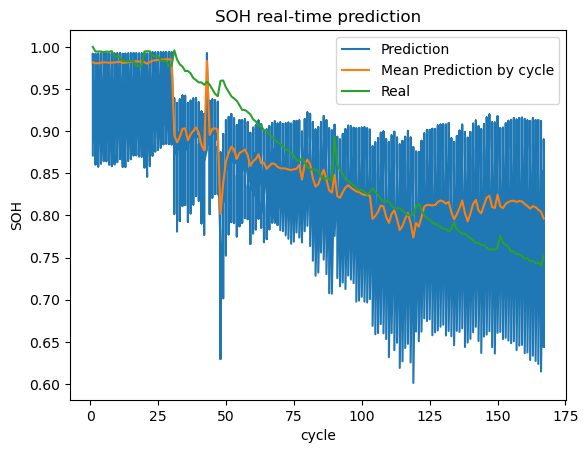

In [1119]:
b7_SOH_predict = model_b7_h3_no_noo.predict(b7_validation_inputs)

b7_SOH_validation = b7_inputs.loc[(b7_inputs['cycle'] >= 1), ['cycle']]
b7_SOH_validation['SOH_predict'] = b7_SOH_predict
b7_SOH_validation['SOH_target'] = b7_SOH_target.to_numpy()
b7_SOH_validation
rms = np.sqrt(mean_squared_error(b7_SOH_validation['SOH_predict'], b7_SOH_validation['SOH_target']))
print('Root Mean Square Error: ', rms)

b7_SOH_validation_mean = b7_SOH_validation.groupby(['cycle']).mean().reset_index()
rms = np.sqrt(mean_squared_error(b7_SOH_validation_mean['SOH_predict'], b7_SOH_validation_mean['SOH_target']))
print('Root Mean Square Error: ', rms)


plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_predict'])
plt.plot(b7_SOH_validation_mean['cycle'], b7_SOH_validation_mean['SOH_predict'])
plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_target'])

plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['Prediction', 'Mean Prediction by cycle', 'Real'])
plt.title('SOH real-time prediction')

In [1123]:
input_layer_b7_h3_mixed1 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_mixed1 = keras.layers.Dense(10, activation='relu')(input_layer_b7_h3_mixed1)
hidden_layer2_b7_h3_mixed1 = keras.layers.Dense(10, activation='relu')(hidden_layer_b7_h3_mixed1)
hidden_layer3_b7_h3_mixed1 = keras.layers.Dense(10, activation='relu')(hidden_layer2_b7_h3_mixed1)
output_layer_b7_h3_mixed1 = keras.layers.Dense(1)(hidden_layer3_b7_h3_mixed1)
model_b7_h3_mixed1 = keras.Model(input_layer_b7_h3_mixed1, output_layer_b7_h3_mixed1)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed1.summary()

Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_121 (Dense)           (None, 10)                60        
                                                                 
 dense_122 (Dense)           (None, 10)                110       
                                                                 
 dense_123 (Dense)           (None, 10)                110       
                                                                 
 dense_124 (Dense)           (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [1124]:
my_train_b7_h3_mixed1 = custom_train(model_b7_h3_mixed1, optimizer, loss_function, metric)
loss_list, epoch_list = my_train_b7_h3_mixed1.train(b7_train_inputs, b7_train_SOH, 100000, 200, 0.00001)

Training acc over epoch: 1.1177 Training loss (for one batch) at step 0: 1.2652 Time taken: 0.03s 
Training acc over epoch: 0.0646 Training loss (for one batch) at step 200: 0.0058 Time taken: 3.10s 
Training acc over epoch: 0.0514 Training loss (for one batch) at step 400: 0.0039 Time taken: 5.97s 
Training acc over epoch: 0.0483 Training loss (for one batch) at step 600: 0.0035 Time taken: 8.78s 
Training acc over epoch: 0.0455 Training loss (for one batch) at step 800: 0.0032 Time taken: 11.79s 
Training acc over epoch: 0.0427 Training loss (for one batch) at step 1000: 0.0029 Time taken: 14.62s 
Training acc over epoch: 0.0403 Training loss (for one batch) at step 1200: 0.0026 Time taken: 17.47s 
Training acc over epoch: 0.0385 Training loss (for one batch) at step 1400: 0.0024 Time taken: 20.28s 
Training acc over epoch: 0.0371 Training loss (for one batch) at step 1600: 0.0023 Time taken: 23.15s 
Training acc over epoch: 0.0360 Training loss (for one batch) at step 1800: 0.0022 T

Training acc over epoch: 0.0078 Training loss (for one batch) at step 15800: 0.0002 Time taken: 230.51s 
Training acc over epoch: 0.0078 Training loss (for one batch) at step 16000: 0.0002 Time taken: 233.45s 
Training acc over epoch: 0.0077 Training loss (for one batch) at step 16200: 0.0002 Time taken: 236.61s 
Training acc over epoch: 0.0077 Training loss (for one batch) at step 16400: 0.0002 Time taken: 239.46s 
Training acc over epoch: 0.0077 Training loss (for one batch) at step 16600: 0.0002 Time taken: 242.30s 
Training acc over epoch: 0.0076 Training loss (for one batch) at step 16800: 0.0002 Time taken: 245.14s 
Training acc over epoch: 0.0078 Training loss (for one batch) at step 17000: 0.0002 Time taken: 247.99s 
Training acc over epoch: 0.0077 Training loss (for one batch) at step 17200: 0.0002 Time taken: 250.97s 
Training acc over epoch: 0.0076 Training loss (for one batch) at step 17400: 0.0002 Time taken: 253.91s 
Training acc over epoch: 0.0076 Training loss (for one 

Training acc over epoch: 0.0068 Training loss (for one batch) at step 31600: 0.0001 Time taken: 461.32s 
Training acc over epoch: 0.0069 Training loss (for one batch) at step 31800: 0.0001 Time taken: 464.27s 
Training acc over epoch: 0.0068 Training loss (for one batch) at step 32000: 0.0001 Time taken: 467.20s 
Training acc over epoch: 0.0070 Training loss (for one batch) at step 32200: 0.0001 Time taken: 470.21s 
Training acc over epoch: 0.0069 Training loss (for one batch) at step 32400: 0.0001 Time taken: 473.06s 
Training acc over epoch: 0.0072 Training loss (for one batch) at step 32600: 0.0001 Time taken: 476.06s 
Training acc over epoch: 0.0068 Training loss (for one batch) at step 32800: 0.0001 Time taken: 478.90s 
Training acc over epoch: 0.0079 Training loss (for one batch) at step 33000: 0.0002 Time taken: 481.78s 
Training acc over epoch: 0.0067 Training loss (for one batch) at step 33200: 0.0001 Time taken: 484.69s 
Training acc over epoch: 0.0069 Training loss (for one 

Training acc over epoch: 0.0065 Training loss (for one batch) at step 47400: 0.0001 Time taken: 692.12s 
Training acc over epoch: 0.0065 Training loss (for one batch) at step 47600: 0.0001 Time taken: 695.02s 
Training acc over epoch: 0.0065 Training loss (for one batch) at step 47800: 0.0001 Time taken: 698.08s 
Training acc over epoch: 0.0067 Training loss (for one batch) at step 48000: 0.0001 Time taken: 701.18s 
Training acc over epoch: 0.0065 Training loss (for one batch) at step 48200: 0.0001 Time taken: 704.20s 
Training acc over epoch: 0.0064 Training loss (for one batch) at step 48400: 0.0001 Time taken: 707.07s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 48600: 0.0001 Time taken: 709.93s 
Training acc over epoch: 0.0064 Training loss (for one batch) at step 48800: 0.0001 Time taken: 712.74s 
Training acc over epoch: 0.0069 Training loss (for one batch) at step 49000: 0.0001 Time taken: 715.89s 
Training acc over epoch: 0.0064 Training loss (for one 

Training acc over epoch: 0.0071 Training loss (for one batch) at step 63200: 0.0001 Time taken: 922.86s 
Training acc over epoch: 0.0063 Training loss (for one batch) at step 63400: 0.0001 Time taken: 925.82s 
Training acc over epoch: 0.0063 Training loss (for one batch) at step 63600: 0.0001 Time taken: 928.83s 
Training acc over epoch: 0.0063 Training loss (for one batch) at step 63800: 0.0001 Time taken: 931.75s 
Training acc over epoch: 0.0063 Training loss (for one batch) at step 64000: 0.0001 Time taken: 934.64s 
Training acc over epoch: 0.0064 Training loss (for one batch) at step 64200: 0.0001 Time taken: 937.53s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 64400: 0.0001 Time taken: 940.56s 
Training acc over epoch: 0.0063 Training loss (for one batch) at step 64600: 0.0001 Time taken: 943.49s 
Training acc over epoch: 0.0065 Training loss (for one batch) at step 64800: 0.0001 Time taken: 946.31s 
Training acc over epoch: 0.0067 Training loss (for one 

Training acc over epoch: 0.0067 Training loss (for one batch) at step 78800: 0.0001 Time taken: 1156.80s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 79000: 0.0001 Time taken: 1159.69s 
Training acc over epoch: 0.0064 Training loss (for one batch) at step 79200: 0.0001 Time taken: 1162.69s 
Training acc over epoch: 0.0063 Training loss (for one batch) at step 79400: 0.0001 Time taken: 1165.77s 
Training acc over epoch: 0.0063 Training loss (for one batch) at step 79600: 0.0001 Time taken: 1168.78s 
Training acc over epoch: 0.0063 Training loss (for one batch) at step 79800: 0.0001 Time taken: 1171.80s 
Training acc over epoch: 0.0063 Training loss (for one batch) at step 80000: 0.0001 Time taken: 1174.88s 
Training acc over epoch: 0.0064 Training loss (for one batch) at step 80200: 0.0001 Time taken: 1177.94s 
Training acc over epoch: 0.0063 Training loss (for one batch) at step 80400: 0.0001 Time taken: 1181.03s 
Training acc over epoch: 0.0063 Training loss 

Training acc over epoch: 0.0063 Training loss (for one batch) at step 94400: 0.0001 Time taken: 1389.78s 
Training acc over epoch: 0.0064 Training loss (for one batch) at step 94600: 0.0001 Time taken: 1392.65s 
Training acc over epoch: 0.0063 Training loss (for one batch) at step 94800: 0.0001 Time taken: 1395.66s 
Training acc over epoch: 0.0063 Training loss (for one batch) at step 95000: 0.0001 Time taken: 1398.63s 
Training acc over epoch: 0.0067 Training loss (for one batch) at step 95200: 0.0001 Time taken: 1401.68s 
Training acc over epoch: 0.0063 Training loss (for one batch) at step 95400: 0.0001 Time taken: 1404.84s 
Training acc over epoch: 0.0067 Training loss (for one batch) at step 95600: 0.0001 Time taken: 1407.83s 
Training acc over epoch: 0.0062 Training loss (for one batch) at step 95800: 0.0001 Time taken: 1410.80s 
Training acc over epoch: 0.0062 Training loss (for one batch) at step 96000: 0.0001 Time taken: 1414.00s 
Training acc over epoch: 0.0062 Training loss 

1499/1499 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.12350849751352579
Root Mean Square Error:  0.10856476793880826


Text(0.5, 1.0, 'SOH real-time prediction')

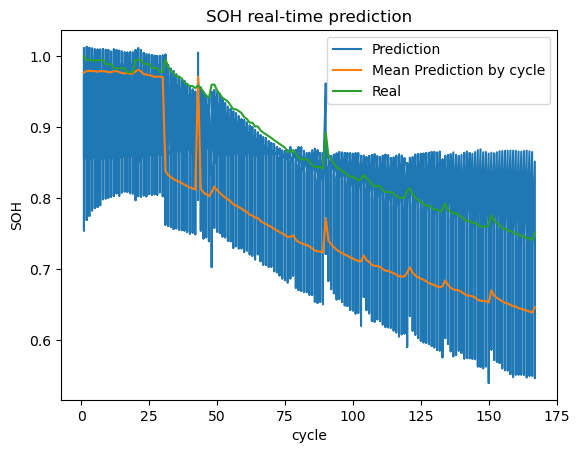

In [1125]:
b7_SOH_predict = model_b7_h3_mixed1.predict(b7_validation_inputs)

b7_SOH_validation = b7_inputs.loc[(b7_inputs['cycle'] >= 1), ['cycle']]
b7_SOH_validation['SOH_predict'] = b7_SOH_predict
b7_SOH_validation['SOH_target'] = b7_SOH_target.to_numpy()
b7_SOH_validation
rms = np.sqrt(mean_squared_error(b7_SOH_validation['SOH_predict'], b7_SOH_validation['SOH_target']))
print('Root Mean Square Error: ', rms)

b7_SOH_validation_mean = b7_SOH_validation.groupby(['cycle']).mean().reset_index()
rms = np.sqrt(mean_squared_error(b7_SOH_validation_mean['SOH_predict'], b7_SOH_validation_mean['SOH_target']))
print('Root Mean Square Error: ', rms)


plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_predict'])
plt.plot(b7_SOH_validation_mean['cycle'], b7_SOH_validation_mean['SOH_predict'])
plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_target'])

plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['Prediction', 'Mean Prediction by cycle', 'Real'])
plt.title('SOH real-time prediction')

In [1127]:
input_layer_b7_h3_mixed2 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_mixed2 = keras.layers.Dense(10)(input_layer_b7_h3_mixed2)
hidden_layer2_b7_h3_mixed2 = keras.layers.Dense(10, activation='tanh')(hidden_layer_b7_h3_mixed2)
hidden_layer3_b7_h3_mixed2 = keras.layers.Dense(10, activation='relu')(hidden_layer2_b7_h3_mixed2)
output_layer_b7_h3_mixed2 = keras.layers.Dense(1)(hidden_layer3_b7_h3_mixed2)
model_b7_h3_mixed2 = keras.Model(input_layer_b7_h3_mixed2, output_layer_b7_h3_mixed2)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed2.summary()

Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_129 (Dense)           (None, 10)                60        
                                                                 
 dense_130 (Dense)           (None, 10)                110       
                                                                 
 dense_131 (Dense)           (None, 10)                110       
                                                                 
 dense_132 (Dense)           (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [1130]:
my_train_b7_h3_mixed2 = custom_train(model_b7_h3_mixed2, optimizer, loss_function, metric)
loss_list, epoch_list = my_train_b7_h3_mixed2.train(b7_train_inputs, b7_train_SOH, 100000, 200, 0.00001)

Training acc over epoch: 0.8171 Training loss (for one batch) at step 0: 0.6858 Time taken: 0.03s 
Training acc over epoch: 0.0696 Training loss (for one batch) at step 200: 0.0063 Time taken: 3.04s 
Training acc over epoch: 0.0464 Training loss (for one batch) at step 400: 0.0031 Time taken: 5.96s 
Training acc over epoch: 0.0408 Training loss (for one batch) at step 600: 0.0027 Time taken: 8.93s 
Training acc over epoch: 0.0390 Training loss (for one batch) at step 800: 0.0025 Time taken: 11.83s 
Training acc over epoch: 0.0378 Training loss (for one batch) at step 1000: 0.0024 Time taken: 14.74s 
Training acc over epoch: 0.0362 Training loss (for one batch) at step 1200: 0.0023 Time taken: 17.81s 
Training acc over epoch: 0.0341 Training loss (for one batch) at step 1400: 0.0021 Time taken: 20.83s 
Training acc over epoch: 0.0324 Training loss (for one batch) at step 1600: 0.0019 Time taken: 23.88s 
Training acc over epoch: 0.0310 Training loss (for one batch) at step 1800: 0.0018 T

Training acc over epoch: 0.0084 Training loss (for one batch) at step 15800: 0.0002 Time taken: 236.05s 
Training acc over epoch: 0.0089 Training loss (for one batch) at step 16000: 0.0002 Time taken: 239.03s 
Training acc over epoch: 0.0084 Training loss (for one batch) at step 16200: 0.0002 Time taken: 242.12s 
Training acc over epoch: 0.0091 Training loss (for one batch) at step 16400: 0.0002 Time taken: 245.10s 
Training acc over epoch: 0.0083 Training loss (for one batch) at step 16600: 0.0002 Time taken: 248.28s 
Training acc over epoch: 0.0090 Training loss (for one batch) at step 16800: 0.0002 Time taken: 251.23s 
Training acc over epoch: 0.0083 Training loss (for one batch) at step 17000: 0.0002 Time taken: 254.17s 
Training acc over epoch: 0.0083 Training loss (for one batch) at step 17200: 0.0002 Time taken: 257.14s 
Training acc over epoch: 0.0083 Training loss (for one batch) at step 17400: 0.0002 Time taken: 260.10s 
Training acc over epoch: 0.0089 Training loss (for one 

Training acc over epoch: 0.0074 Training loss (for one batch) at step 31600: 0.0001 Time taken: 472.81s 
Training acc over epoch: 0.0076 Training loss (for one batch) at step 31800: 0.0001 Time taken: 475.76s 
Training acc over epoch: 0.0078 Training loss (for one batch) at step 32000: 0.0001 Time taken: 478.76s 
Training acc over epoch: 0.0074 Training loss (for one batch) at step 32200: 0.0001 Time taken: 481.70s 
Training acc over epoch: 0.0074 Training loss (for one batch) at step 32400: 0.0001 Time taken: 484.68s 
Training acc over epoch: 0.0079 Training loss (for one batch) at step 32600: 0.0001 Time taken: 487.80s 
Training acc over epoch: 0.0104 Training loss (for one batch) at step 32800: 0.0002 Time taken: 490.79s 
Training acc over epoch: 0.0074 Training loss (for one batch) at step 33000: 0.0001 Time taken: 493.81s 
Training acc over epoch: 0.0075 Training loss (for one batch) at step 33200: 0.0001 Time taken: 496.81s 
Training acc over epoch: 0.0074 Training loss (for one 

Training acc over epoch: 0.0073 Training loss (for one batch) at step 47400: 0.0001 Time taken: 710.50s 
Training acc over epoch: 0.0072 Training loss (for one batch) at step 47600: 0.0001 Time taken: 713.71s 
Training acc over epoch: 0.0072 Training loss (for one batch) at step 47800: 0.0001 Time taken: 716.70s 
Training acc over epoch: 0.0102 Training loss (for one batch) at step 48000: 0.0002 Time taken: 719.79s 
Training acc over epoch: 0.0078 Training loss (for one batch) at step 48200: 0.0001 Time taken: 722.75s 
Training acc over epoch: 0.0071 Training loss (for one batch) at step 48400: 0.0001 Time taken: 725.77s 
Training acc over epoch: 0.0101 Training loss (for one batch) at step 48600: 0.0002 Time taken: 728.85s 
Training acc over epoch: 0.0071 Training loss (for one batch) at step 48800: 0.0001 Time taken: 731.85s 
Training acc over epoch: 0.0071 Training loss (for one batch) at step 49000: 0.0001 Time taken: 734.80s 
Training acc over epoch: 0.0071 Training loss (for one 

Training acc over epoch: 0.0074 Training loss (for one batch) at step 63200: 0.0001 Time taken: 948.17s 
Training acc over epoch: 0.0068 Training loss (for one batch) at step 63400: 0.0001 Time taken: 951.76s 
Training acc over epoch: 0.0088 Training loss (for one batch) at step 63600: 0.0002 Time taken: 954.67s 
Training acc over epoch: 0.0068 Training loss (for one batch) at step 63800: 0.0001 Time taken: 957.53s 
Training acc over epoch: 0.0069 Training loss (for one batch) at step 64000: 0.0001 Time taken: 960.48s 
Training acc over epoch: 0.0088 Training loss (for one batch) at step 64200: 0.0002 Time taken: 963.42s 
Training acc over epoch: 0.0069 Training loss (for one batch) at step 64400: 0.0001 Time taken: 966.60s 
Training acc over epoch: 0.0069 Training loss (for one batch) at step 64600: 0.0001 Time taken: 969.58s 
Training acc over epoch: 0.0068 Training loss (for one batch) at step 64800: 0.0001 Time taken: 972.58s 
Training acc over epoch: 0.0068 Training loss (for one 

Training acc over epoch: 0.0066 Training loss (for one batch) at step 78800: 0.0001 Time taken: 1185.81s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 79000: 0.0001 Time taken: 1188.65s 
Training acc over epoch: 0.0067 Training loss (for one batch) at step 79200: 0.0001 Time taken: 1191.62s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 79400: 0.0001 Time taken: 1194.47s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 79600: 0.0001 Time taken: 1197.43s 
Training acc over epoch: 0.0071 Training loss (for one batch) at step 79800: 0.0001 Time taken: 1200.39s 
Training acc over epoch: 0.0073 Training loss (for one batch) at step 80000: 0.0001 Time taken: 1203.35s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 80200: 0.0001 Time taken: 1206.42s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 80400: 0.0001 Time taken: 1209.42s 
Training acc over epoch: 0.0066 Training loss 

Training acc over epoch: 0.0063 Training loss (for one batch) at step 94400: 0.0001 Time taken: 1419.14s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 94600: 0.0001 Time taken: 1422.07s 
Training acc over epoch: 0.0061 Training loss (for one batch) at step 94800: 0.0001 Time taken: 1425.04s 
Training acc over epoch: 0.0062 Training loss (for one batch) at step 95000: 0.0001 Time taken: 1428.12s 
Training acc over epoch: 0.0069 Training loss (for one batch) at step 95200: 0.0001 Time taken: 1431.26s 
Training acc over epoch: 0.0060 Training loss (for one batch) at step 95400: 0.0001 Time taken: 1434.22s 
Training acc over epoch: 0.0060 Training loss (for one batch) at step 95600: 0.0001 Time taken: 1437.15s 
Training acc over epoch: 0.0060 Training loss (for one batch) at step 95800: 0.0001 Time taken: 1440.16s 
Training acc over epoch: 0.0061 Training loss (for one batch) at step 96000: 0.0001 Time taken: 1443.07s 
Training acc over epoch: 0.0062 Training loss 

1499/1499 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.13463409910873694
Root Mean Square Error:  0.12106584508399248


Text(0.5, 1.0, 'SOH real-time prediction')

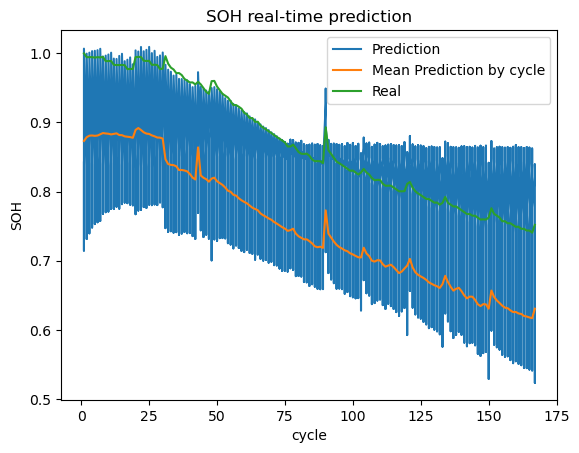

In [1134]:
b7_SOH_predict = model_b7_h3_mixed2.predict(b7_validation_inputs)

b7_SOH_validation = b7_inputs.loc[(b7_inputs['cycle'] >= 1), ['cycle']]
b7_SOH_validation['SOH_predict'] = b7_SOH_predict
b7_SOH_validation['SOH_target'] = b7_SOH_target.to_numpy()
b7_SOH_validation
rms = np.sqrt(mean_squared_error(b7_SOH_validation['SOH_predict'], b7_SOH_validation['SOH_target']))
print('Root Mean Square Error: ', rms)

b7_SOH_validation_mean = b7_SOH_validation.groupby(['cycle']).mean().reset_index()
rms = np.sqrt(mean_squared_error(b7_SOH_validation_mean['SOH_predict'], b7_SOH_validation_mean['SOH_target']))
print('Root Mean Square Error: ', rms)


plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_predict'])
plt.plot(b7_SOH_validation_mean['cycle'], b7_SOH_validation_mean['SOH_predict'])
plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_target'])

plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['Prediction', 'Mean Prediction by cycle', 'Real'])
plt.title('SOH real-time prediction')

In [1136]:
input_layer_b7_h3_mixed3 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_mixed3 = keras.layers.Dense(10)(input_layer_b7_h3_mixed3)
hidden_layer2_b7_h3_mixed3 = keras.layers.Dense(10, activation='tanh')(hidden_layer_b7_h3_mixed3)
#hidden_layer3_b7_h3_mixed3 = keras.layers.Dense(10, activation='relu')(hidden_layer2_b7_h3_mixed3)
hidden_layer3_b7_h3_mixed3 = keras.layers.Dense(10)(hidden_layer2_b7_h3_mixed3)
output_layer_b7_h3_mixed3 = keras.layers.Dense(1)(hidden_layer3_b7_h3_mixed3)
model_b7_h3_mixed3 = keras.Model(input_layer_b7_h3_mixed3, output_layer_b7_h3_mixed3)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed3.summary()

Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_137 (Dense)           (None, 10)                60        
                                                                 
 dense_138 (Dense)           (None, 10)                110       
                                                                 
 dense_139 (Dense)           (None, 10)                110       
                                                                 
 dense_140 (Dense)           (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [1137]:
my_train_b7_h3_mixed3 = custom_train(model_b7_h3_mixed3, optimizer, loss_function, metric)
loss_list, epoch_list = my_train_b7_h3_mixed3.train(b7_train_inputs, b7_train_SOH, 100000, 200, 0.0001)

Training acc over epoch: 1.0767 Training loss (for one batch) at step 0: 1.1649 Time taken: 0.03s 
Training acc over epoch: 0.0664 Training loss (for one batch) at step 200: 0.0076 Time taken: 3.12s 
Training acc over epoch: 0.0475 Training loss (for one batch) at step 400: 0.0036 Time taken: 6.05s 
Training acc over epoch: 0.0448 Training loss (for one batch) at step 600: 0.0032 Time taken: 9.17s 
Training acc over epoch: 0.0446 Training loss (for one batch) at step 800: 0.0032 Time taken: 12.22s 
Training acc over epoch: 0.0444 Training loss (for one batch) at step 1000: 0.0032 Time taken: 15.10s 
Training acc over epoch: 0.0443 Training loss (for one batch) at step 1200: 0.0031 Time taken: 17.98s 
Training acc over epoch: 0.0442 Training loss (for one batch) at step 1400: 0.0031 Time taken: 20.76s 
Training acc over epoch: 0.0441 Training loss (for one batch) at step 1600: 0.0031 Time taken: 23.63s 
Training acc over epoch: 0.0439 Training loss (for one batch) at step 1800: 0.0031 T

Training acc over epoch: 0.0100 Training loss (for one batch) at step 15800: 0.0003 Time taken: 235.41s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 16000: 0.0003 Time taken: 238.39s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 16200: 0.0003 Time taken: 241.36s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 16400: 0.0003 Time taken: 244.28s 
Training acc over epoch: 0.0099 Training loss (for one batch) at step 16600: 0.0003 Time taken: 247.18s 
Training acc over epoch: 0.0099 Training loss (for one batch) at step 16800: 0.0003 Time taken: 250.25s 
Training acc over epoch: 0.0099 Training loss (for one batch) at step 17000: 0.0003 Time taken: 253.18s 
Training acc over epoch: 0.0099 Training loss (for one batch) at step 17200: 0.0003 Time taken: 256.11s 
Training acc over epoch: 0.0099 Training loss (for one batch) at step 17400: 0.0003 Time taken: 259.05s 
Training acc over epoch: 0.0098 Training loss (for one 

Training acc over epoch: 0.0091 Training loss (for one batch) at step 31600: 0.0002 Time taken: 469.63s 
Training acc over epoch: 0.0091 Training loss (for one batch) at step 31800: 0.0002 Time taken: 472.57s 
Training acc over epoch: 0.0092 Training loss (for one batch) at step 32000: 0.0002 Time taken: 475.66s 
Training acc over epoch: 0.0091 Training loss (for one batch) at step 32200: 0.0002 Time taken: 478.53s 
Training acc over epoch: 0.0091 Training loss (for one batch) at step 32400: 0.0002 Time taken: 481.46s 
Training acc over epoch: 0.0091 Training loss (for one batch) at step 32600: 0.0002 Time taken: 484.42s 
Training acc over epoch: 0.0093 Training loss (for one batch) at step 32800: 0.0002 Time taken: 487.39s 
Training acc over epoch: 0.0091 Training loss (for one batch) at step 33000: 0.0002 Time taken: 490.51s 
Training acc over epoch: 0.0091 Training loss (for one batch) at step 33200: 0.0002 Time taken: 493.42s 
Training acc over epoch: 0.0091 Training loss (for one 

Training acc over epoch: 0.0089 Training loss (for one batch) at step 47400: 0.0002 Time taken: 703.69s 
Training acc over epoch: 0.0088 Training loss (for one batch) at step 47600: 0.0002 Time taken: 706.59s 
Training acc over epoch: 0.0089 Training loss (for one batch) at step 47800: 0.0002 Time taken: 709.53s 
Training acc over epoch: 0.0089 Training loss (for one batch) at step 48000: 0.0002 Time taken: 712.58s 
Training acc over epoch: 0.0088 Training loss (for one batch) at step 48200: 0.0002 Time taken: 715.63s 
Training acc over epoch: 0.0097 Training loss (for one batch) at step 48400: 0.0003 Time taken: 718.54s 
Training acc over epoch: 0.0104 Training loss (for one batch) at step 48600: 0.0003 Time taken: 721.48s 
Training acc over epoch: 0.0088 Training loss (for one batch) at step 48800: 0.0002 Time taken: 724.37s 
Training acc over epoch: 0.0088 Training loss (for one batch) at step 49000: 0.0002 Time taken: 727.26s 
Training acc over epoch: 0.0089 Training loss (for one 

Training acc over epoch: 0.0087 Training loss (for one batch) at step 63200: 0.0002 Time taken: 938.56s 
Training acc over epoch: 0.0087 Training loss (for one batch) at step 63400: 0.0002 Time taken: 941.38s 
Training acc over epoch: 0.0089 Training loss (for one batch) at step 63600: 0.0002 Time taken: 944.31s 
Training acc over epoch: 0.0087 Training loss (for one batch) at step 63800: 0.0002 Time taken: 947.28s 
Training acc over epoch: 0.0087 Training loss (for one batch) at step 64000: 0.0002 Time taken: 950.20s 
Training acc over epoch: 0.0087 Training loss (for one batch) at step 64200: 0.0002 Time taken: 953.17s 
Training acc over epoch: 0.0087 Training loss (for one batch) at step 64400: 0.0002 Time taken: 956.23s 
Training acc over epoch: 0.0087 Training loss (for one batch) at step 64600: 0.0002 Time taken: 959.16s 
Training acc over epoch: 0.0087 Training loss (for one batch) at step 64800: 0.0002 Time taken: 962.18s 
Training acc over epoch: 0.0087 Training loss (for one 

Training acc over epoch: 0.0086 Training loss (for one batch) at step 78800: 0.0002 Time taken: 1169.66s 
Training acc over epoch: 0.0086 Training loss (for one batch) at step 79000: 0.0002 Time taken: 1172.56s 
Training acc over epoch: 0.0086 Training loss (for one batch) at step 79200: 0.0002 Time taken: 1175.52s 
Training acc over epoch: 0.0106 Training loss (for one batch) at step 79400: 0.0003 Time taken: 1178.57s 
Training acc over epoch: 0.0085 Training loss (for one batch) at step 79600: 0.0002 Time taken: 1181.50s 
Training acc over epoch: 0.0085 Training loss (for one batch) at step 79800: 0.0002 Time taken: 1184.45s 
Training acc over epoch: 0.0085 Training loss (for one batch) at step 80000: 0.0002 Time taken: 1187.38s 
Training acc over epoch: 0.0085 Training loss (for one batch) at step 80200: 0.0002 Time taken: 1190.32s 
Training acc over epoch: 0.0086 Training loss (for one batch) at step 80400: 0.0002 Time taken: 1193.32s 
Training acc over epoch: 0.0088 Training loss 

Training acc over epoch: 0.0078 Training loss (for one batch) at step 94400: 0.0002 Time taken: 1401.40s 
Training acc over epoch: 0.0078 Training loss (for one batch) at step 94600: 0.0002 Time taken: 1404.38s 
Training acc over epoch: 0.0082 Training loss (for one batch) at step 94800: 0.0002 Time taken: 1407.29s 
Training acc over epoch: 0.0077 Training loss (for one batch) at step 95000: 0.0002 Time taken: 1410.29s 
Training acc over epoch: 0.0076 Training loss (for one batch) at step 95200: 0.0002 Time taken: 1413.19s 
Training acc over epoch: 0.0076 Training loss (for one batch) at step 95400: 0.0002 Time taken: 1416.12s 
Training acc over epoch: 0.0075 Training loss (for one batch) at step 95600: 0.0002 Time taken: 1419.19s 
Training acc over epoch: 0.0075 Training loss (for one batch) at step 95800: 0.0002 Time taken: 1422.19s 
Training acc over epoch: 0.0075 Training loss (for one batch) at step 96000: 0.0002 Time taken: 1425.10s 
Training acc over epoch: 0.0079 Training loss 

1499/1499 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.1360043705330126
Root Mean Square Error:  0.12236347410006958


Text(0.5, 1.0, 'SOH real-time prediction')

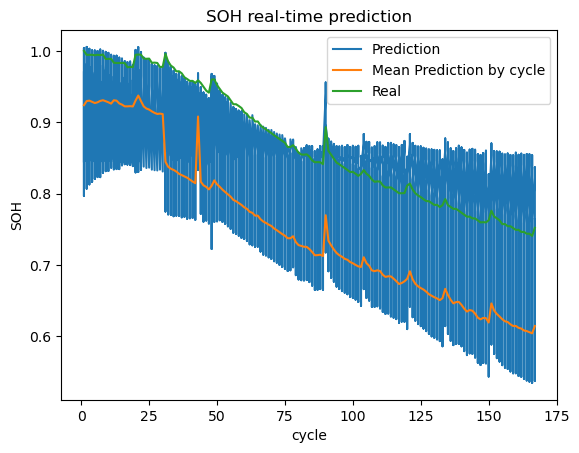

In [1138]:
b7_SOH_predict = model_b7_h3_mixed3.predict(b7_validation_inputs)

b7_SOH_validation = b7_inputs.loc[(b7_inputs['cycle'] >= 1), ['cycle']]
b7_SOH_validation['SOH_predict'] = b7_SOH_predict
b7_SOH_validation['SOH_target'] = b7_SOH_target.to_numpy()
b7_SOH_validation
rms = np.sqrt(mean_squared_error(b7_SOH_validation['SOH_predict'], b7_SOH_validation['SOH_target']))
print('Root Mean Square Error: ', rms)

b7_SOH_validation_mean = b7_SOH_validation.groupby(['cycle']).mean().reset_index()
rms = np.sqrt(mean_squared_error(b7_SOH_validation_mean['SOH_predict'], b7_SOH_validation_mean['SOH_target']))
print('Root Mean Square Error: ', rms)


plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_predict'])
plt.plot(b7_SOH_validation_mean['cycle'], b7_SOH_validation_mean['SOH_predict'])
plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_target'])

plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['Prediction', 'Mean Prediction by cycle', 'Real'])
plt.title('SOH real-time prediction')

In [1140]:
input_layer_b7_h3_mixed4 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_mixed4 = keras.layers.Dense(10)(input_layer_b7_h3_mixed4)
hidden_layer2_b7_h3_mixed4 = keras.layers.Dense(10)(hidden_layer_b7_h3_mixed4)
hidden_layer3_b7_h3_mixed4 = keras.layers.Dense(10, activation='relu')(hidden_layer2_b7_h3_mixed4)
output_layer_b7_h3_mixed4 = keras.layers.Dense(1)(hidden_layer3_b7_h3_mixed4)
model_b7_h3_mixed4 = keras.Model(input_layer_b7_h3_mixed4, output_layer_b7_h3_mixed4)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed4.summary()

Model: "model_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_145 (Dense)           (None, 10)                60        
                                                                 
 dense_146 (Dense)           (None, 10)                110       
                                                                 
 dense_147 (Dense)           (None, 10)                110       
                                                                 
 dense_148 (Dense)           (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [1141]:
my_train_b7_h3_mixed4 = custom_train(model_b7_h3_mixed4, optimizer, loss_function, metric)
loss_list, epoch_list = my_train_b7_h3_mixed4.train(b7_train_inputs, b7_train_SOH, 100000, 200, 0.0001)

Training acc over epoch: 0.5206 Training loss (for one batch) at step 0: 0.2782 Time taken: 0.03s 
Training acc over epoch: 0.0509 Training loss (for one batch) at step 200: 0.0038 Time taken: 3.04s 
Training acc over epoch: 0.0397 Training loss (for one batch) at step 400: 0.0025 Time taken: 5.97s 
Training acc over epoch: 0.0352 Training loss (for one batch) at step 600: 0.0021 Time taken: 8.91s 
Training acc over epoch: 0.0322 Training loss (for one batch) at step 800: 0.0019 Time taken: 11.92s 
Training acc over epoch: 0.0305 Training loss (for one batch) at step 1000: 0.0017 Time taken: 15.02s 
Training acc over epoch: 0.0280 Training loss (for one batch) at step 1200: 0.0015 Time taken: 17.99s 
Training acc over epoch: 0.0240 Training loss (for one batch) at step 1400: 0.0012 Time taken: 20.86s 
Training acc over epoch: 0.0218 Training loss (for one batch) at step 1600: 0.0010 Time taken: 23.73s 
Training acc over epoch: 0.0208 Training loss (for one batch) at step 1800: 0.0010 T

Training acc over epoch: 0.0104 Training loss (for one batch) at step 15800: 0.0003 Time taken: 229.32s 
Training acc over epoch: 0.0107 Training loss (for one batch) at step 16000: 0.0003 Time taken: 232.14s 
Training acc over epoch: 0.0104 Training loss (for one batch) at step 16200: 0.0003 Time taken: 235.11s 
Training acc over epoch: 0.0105 Training loss (for one batch) at step 16400: 0.0003 Time taken: 238.23s 
Training acc over epoch: 0.0104 Training loss (for one batch) at step 16600: 0.0003 Time taken: 241.32s 
Training acc over epoch: 0.0104 Training loss (for one batch) at step 16800: 0.0003 Time taken: 244.29s 
Training acc over epoch: 0.0104 Training loss (for one batch) at step 17000: 0.0003 Time taken: 247.24s 
Training acc over epoch: 0.0104 Training loss (for one batch) at step 17200: 0.0003 Time taken: 250.20s 
Training acc over epoch: 0.0104 Training loss (for one batch) at step 17400: 0.0003 Time taken: 253.32s 
Training acc over epoch: 0.0104 Training loss (for one 

Training acc over epoch: 0.0102 Training loss (for one batch) at step 31600: 0.0002 Time taken: 464.34s 
Training acc over epoch: 0.0107 Training loss (for one batch) at step 31800: 0.0003 Time taken: 467.28s 
Training acc over epoch: 0.0102 Training loss (for one batch) at step 32000: 0.0002 Time taken: 470.24s 
Training acc over epoch: 0.0102 Training loss (for one batch) at step 32200: 0.0002 Time taken: 473.21s 
Training acc over epoch: 0.0102 Training loss (for one batch) at step 32400: 0.0002 Time taken: 476.23s 
Training acc over epoch: 0.0102 Training loss (for one batch) at step 32600: 0.0002 Time taken: 479.24s 
Training acc over epoch: 0.0102 Training loss (for one batch) at step 32800: 0.0002 Time taken: 482.16s 
Training acc over epoch: 0.0102 Training loss (for one batch) at step 33000: 0.0002 Time taken: 485.06s 
Training acc over epoch: 0.0114 Training loss (for one batch) at step 33200: 0.0003 Time taken: 487.98s 
Training acc over epoch: 0.0102 Training loss (for one 

Training acc over epoch: 0.0101 Training loss (for one batch) at step 47400: 0.0002 Time taken: 698.29s 
Training acc over epoch: 0.0111 Training loss (for one batch) at step 47600: 0.0003 Time taken: 701.31s 
Training acc over epoch: 0.0101 Training loss (for one batch) at step 47800: 0.0002 Time taken: 704.25s 
Training acc over epoch: 0.0104 Training loss (for one batch) at step 48000: 0.0002 Time taken: 707.08s 
Training acc over epoch: 0.0101 Training loss (for one batch) at step 48200: 0.0002 Time taken: 709.95s 
Training acc over epoch: 0.0101 Training loss (for one batch) at step 48400: 0.0002 Time taken: 712.91s 
Training acc over epoch: 0.0101 Training loss (for one batch) at step 48600: 0.0002 Time taken: 715.90s 
Training acc over epoch: 0.0101 Training loss (for one batch) at step 48800: 0.0002 Time taken: 718.76s 
Training acc over epoch: 0.0106 Training loss (for one batch) at step 49000: 0.0002 Time taken: 721.59s 
Training acc over epoch: 0.0101 Training loss (for one 

Training acc over epoch: 0.0101 Training loss (for one batch) at step 63200: 0.0002 Time taken: 928.43s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 63400: 0.0002 Time taken: 931.42s 
Training acc over epoch: 0.0104 Training loss (for one batch) at step 63600: 0.0002 Time taken: 934.44s 
Training acc over epoch: 0.0101 Training loss (for one batch) at step 63800: 0.0002 Time taken: 937.29s 
Training acc over epoch: 0.0104 Training loss (for one batch) at step 64000: 0.0002 Time taken: 940.39s 
Training acc over epoch: 0.0101 Training loss (for one batch) at step 64200: 0.0002 Time taken: 943.36s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 64400: 0.0002 Time taken: 946.22s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 64600: 0.0002 Time taken: 948.99s 
Training acc over epoch: 0.0103 Training loss (for one batch) at step 64800: 0.0002 Time taken: 951.82s 
Training acc over epoch: 0.0100 Training loss (for one 

Training acc over epoch: 0.0100 Training loss (for one batch) at step 78800: 0.0002 Time taken: 1158.99s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 79000: 0.0002 Time taken: 1161.97s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 79200: 0.0002 Time taken: 1165.05s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 79400: 0.0002 Time taken: 1167.98s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 79600: 0.0002 Time taken: 1170.89s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 79800: 0.0002 Time taken: 1173.79s 
Training acc over epoch: 0.0101 Training loss (for one batch) at step 80000: 0.0002 Time taken: 1176.67s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 80200: 0.0002 Time taken: 1179.67s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 80400: 0.0002 Time taken: 1182.68s 
Training acc over epoch: 0.0100 Training loss 

Training acc over epoch: 0.0100 Training loss (for one batch) at step 94400: 0.0002 Time taken: 1390.87s 
Training acc over epoch: 0.0106 Training loss (for one batch) at step 94600: 0.0003 Time taken: 1393.87s 
Training acc over epoch: 0.0099 Training loss (for one batch) at step 94800: 0.0002 Time taken: 1396.79s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 95000: 0.0002 Time taken: 1399.71s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 95200: 0.0002 Time taken: 1402.60s 
Training acc over epoch: 0.0099 Training loss (for one batch) at step 95400: 0.0002 Time taken: 1405.70s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 95600: 0.0002 Time taken: 1408.61s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 95800: 0.0002 Time taken: 1411.53s 
Training acc over epoch: 0.0100 Training loss (for one batch) at step 96000: 0.0002 Time taken: 1414.46s 
Training acc over epoch: 0.0105 Training loss 

1499/1499 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.1298418770843318
Root Mean Square Error:  0.10567231885636033


Text(0.5, 1.0, 'SOH real-time prediction')

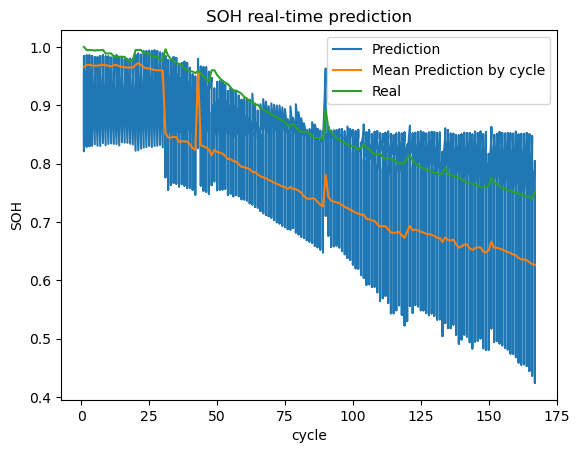

In [1142]:
b7_SOH_predict = model_b7_h3_mixed4.predict(b7_validation_inputs)

b7_SOH_validation = b7_inputs.loc[(b7_inputs['cycle'] >= 1), ['cycle']]
b7_SOH_validation['SOH_predict'] = b7_SOH_predict
b7_SOH_validation['SOH_target'] = b7_SOH_target.to_numpy()
b7_SOH_validation
rms = np.sqrt(mean_squared_error(b7_SOH_validation['SOH_predict'], b7_SOH_validation['SOH_target']))
print('Root Mean Square Error: ', rms)

b7_SOH_validation_mean = b7_SOH_validation.groupby(['cycle']).mean().reset_index()
rms = np.sqrt(mean_squared_error(b7_SOH_validation_mean['SOH_predict'], b7_SOH_validation_mean['SOH_target']))
print('Root Mean Square Error: ', rms)


plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_predict'])
plt.plot(b7_SOH_validation_mean['cycle'], b7_SOH_validation_mean['SOH_predict'])
plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_target'])

plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['Prediction', 'Mean Prediction by cycle', 'Real'])
plt.title('SOH real-time prediction')

In [1150]:
input_layer_b7_h3_mixed5 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_mixed5 = keras.layers.Dense(10, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(input_layer_b7_h3_mixed5)
hidden_layer2_b7_h3_mixed5 = keras.layers.Dense(10, activation='tanh', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer_b7_h3_mixed5)
hidden_layer3_b7_h3_mixed5 = keras.layers.Dense(10, activation='relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer2_b7_h3_mixed5)
output_layer_b7_h3_mixed5 = keras.layers.Dense(1, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer3_b7_h3_mixed5)
model_b7_h3_mixed5 = keras.Model(input_layer_b7_h3_mixed5, output_layer_b7_h3_mixed5)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed5.summary()

Model: "model_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_161 (Dense)           (None, 10)                60        
                                                                 
 dense_162 (Dense)           (None, 10)                110       
                                                                 
 dense_163 (Dense)           (None, 10)                110       
                                                                 
 dense_164 (Dense)           (None, 1)                 11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [1153]:
my_train_b7_h3_mixed5 = custom_train(model_b7_h3_mixed5, optimizer, loss_function, metric)
loss_list, epoch_list = my_train_b7_h3_mixed5.train(b7_train_inputs, b7_train_SOH, 100000, 200, 0.0001)

Training acc over epoch: 0.0398 Training loss (for one batch) at step 0: 0.0027 Time taken: 0.02s 
Training acc over epoch: 0.0392 Training loss (for one batch) at step 200: 0.0027 Time taken: 3.22s 
Training acc over epoch: 0.0389 Training loss (for one batch) at step 400: 0.0027 Time taken: 6.09s 
Training acc over epoch: 0.0387 Training loss (for one batch) at step 600: 0.0027 Time taken: 9.01s 
Training acc over epoch: 0.0385 Training loss (for one batch) at step 800: 0.0027 Time taken: 11.86s 
Training acc over epoch: 0.0385 Training loss (for one batch) at step 1000: 0.0026 Time taken: 14.75s 
Training acc over epoch: 0.0384 Training loss (for one batch) at step 1200: 0.0026 Time taken: 17.75s 
Training acc over epoch: 0.0384 Training loss (for one batch) at step 1400: 0.0026 Time taken: 20.86s 
Training acc over epoch: 0.0384 Training loss (for one batch) at step 1600: 0.0026 Time taken: 23.85s 
Training acc over epoch: 0.0385 Training loss (for one batch) at step 1800: 0.0026 T

Training acc over epoch: 0.0091 Training loss (for one batch) at step 15800: 0.0003 Time taken: 235.41s 
Training acc over epoch: 0.0090 Training loss (for one batch) at step 16000: 0.0002 Time taken: 238.23s 
Training acc over epoch: 0.0090 Training loss (for one batch) at step 16200: 0.0002 Time taken: 241.22s 
Training acc over epoch: 0.0090 Training loss (for one batch) at step 16400: 0.0002 Time taken: 244.40s 
Training acc over epoch: 0.0090 Training loss (for one batch) at step 16600: 0.0002 Time taken: 247.43s 
Training acc over epoch: 0.0090 Training loss (for one batch) at step 16800: 0.0002 Time taken: 250.44s 
Training acc over epoch: 0.0089 Training loss (for one batch) at step 17000: 0.0002 Time taken: 253.44s 
Training acc over epoch: 0.0089 Training loss (for one batch) at step 17200: 0.0002 Time taken: 256.48s 
Training acc over epoch: 0.0089 Training loss (for one batch) at step 17400: 0.0002 Time taken: 259.70s 
Training acc over epoch: 0.0122 Training loss (for one 

Training acc over epoch: 0.0066 Training loss (for one batch) at step 31600: 0.0002 Time taken: 474.26s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 31800: 0.0002 Time taken: 477.09s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 32000: 0.0002 Time taken: 479.89s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 32200: 0.0002 Time taken: 482.82s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 32400: 0.0002 Time taken: 485.70s 
Training acc over epoch: 0.0066 Training loss (for one batch) at step 32600: 0.0002 Time taken: 488.59s 
Training acc over epoch: 0.0065 Training loss (for one batch) at step 32800: 0.0002 Time taken: 491.44s 
Training acc over epoch: 0.0065 Training loss (for one batch) at step 33000: 0.0002 Time taken: 494.30s 
Training acc over epoch: 0.0065 Training loss (for one batch) at step 33200: 0.0002 Time taken: 497.46s 
Training acc over epoch: 0.0065 Training loss (for one 

Training acc over epoch: 0.0059 Training loss (for one batch) at step 47400: 0.0001 Time taken: 711.47s 
Training acc over epoch: 0.0059 Training loss (for one batch) at step 47600: 0.0001 Time taken: 714.33s 
Training acc over epoch: 0.0059 Training loss (for one batch) at step 47800: 0.0001 Time taken: 717.24s 
Training acc over epoch: 0.0063 Training loss (for one batch) at step 48000: 0.0001 Time taken: 720.30s 
Training acc over epoch: 0.0059 Training loss (for one batch) at step 48200: 0.0001 Time taken: 723.59s 
Training acc over epoch: 0.0059 Training loss (for one batch) at step 48400: 0.0001 Time taken: 726.72s 
Training acc over epoch: 0.0059 Training loss (for one batch) at step 48600: 0.0001 Time taken: 729.72s 
Training acc over epoch: 0.0058 Training loss (for one batch) at step 48800: 0.0001 Time taken: 732.65s 
Training acc over epoch: 0.0102 Training loss (for one batch) at step 49000: 0.0002 Time taken: 735.49s 
Training acc over epoch: 0.0059 Training loss (for one 

Training acc over epoch: 0.0057 Training loss (for one batch) at step 63200: 0.0001 Time taken: 944.76s 
Training acc over epoch: 0.0056 Training loss (for one batch) at step 63400: 0.0001 Time taken: 947.93s 
Training acc over epoch: 0.0057 Training loss (for one batch) at step 63600: 0.0001 Time taken: 950.87s 
Training acc over epoch: 0.0057 Training loss (for one batch) at step 63800: 0.0001 Time taken: 953.87s 
Training acc over epoch: 0.0056 Training loss (for one batch) at step 64000: 0.0001 Time taken: 956.86s 
Training acc over epoch: 0.0096 Training loss (for one batch) at step 64200: 0.0002 Time taken: 959.80s 
Training acc over epoch: 0.0057 Training loss (for one batch) at step 64400: 0.0001 Time taken: 962.87s 
Training acc over epoch: 0.0057 Training loss (for one batch) at step 64600: 0.0001 Time taken: 965.90s 
Training acc over epoch: 0.0056 Training loss (for one batch) at step 64800: 0.0001 Time taken: 968.87s 
Training acc over epoch: 0.0056 Training loss (for one 

Training acc over epoch: 0.0055 Training loss (for one batch) at step 78800: 0.0001 Time taken: 1177.34s 
Training acc over epoch: 0.0055 Training loss (for one batch) at step 79000: 0.0001 Time taken: 1180.32s 
Training acc over epoch: 0.0055 Training loss (for one batch) at step 79200: 0.0001 Time taken: 1183.38s 
Training acc over epoch: 0.0055 Training loss (for one batch) at step 79400: 0.0001 Time taken: 1186.42s 
Training acc over epoch: 0.0055 Training loss (for one batch) at step 79600: 0.0001 Time taken: 1189.48s 
Training acc over epoch: 0.0075 Training loss (for one batch) at step 79800: 0.0001 Time taken: 1192.43s 
Training acc over epoch: 0.0055 Training loss (for one batch) at step 80000: 0.0001 Time taken: 1195.41s 
Training acc over epoch: 0.0055 Training loss (for one batch) at step 80200: 0.0001 Time taken: 1198.28s 
Training acc over epoch: 0.0055 Training loss (for one batch) at step 80400: 0.0001 Time taken: 1201.12s 
Training acc over epoch: 0.0055 Training loss 

Training acc over epoch: 0.0054 Training loss (for one batch) at step 94400: 0.0001 Time taken: 1410.65s 
Training acc over epoch: 0.0054 Training loss (for one batch) at step 94600: 0.0001 Time taken: 1413.76s 
Training acc over epoch: 0.0054 Training loss (for one batch) at step 94800: 0.0001 Time taken: 1416.74s 
Training acc over epoch: 0.0054 Training loss (for one batch) at step 95000: 0.0001 Time taken: 1419.70s 
Training acc over epoch: 0.0054 Training loss (for one batch) at step 95200: 0.0001 Time taken: 1422.64s 
Training acc over epoch: 0.0059 Training loss (for one batch) at step 95400: 0.0001 Time taken: 1425.61s 
Training acc over epoch: 0.0054 Training loss (for one batch) at step 95600: 0.0001 Time taken: 1428.70s 
Training acc over epoch: 0.0054 Training loss (for one batch) at step 95800: 0.0001 Time taken: 1431.68s 
Training acc over epoch: 0.0054 Training loss (for one batch) at step 96000: 0.0001 Time taken: 1434.63s 
Training acc over epoch: 0.0054 Training loss 

1499/1499 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.1438477803184207
Root Mean Square Error:  0.13368848529986507


Text(0.5, 1.0, 'SOH real-time prediction')

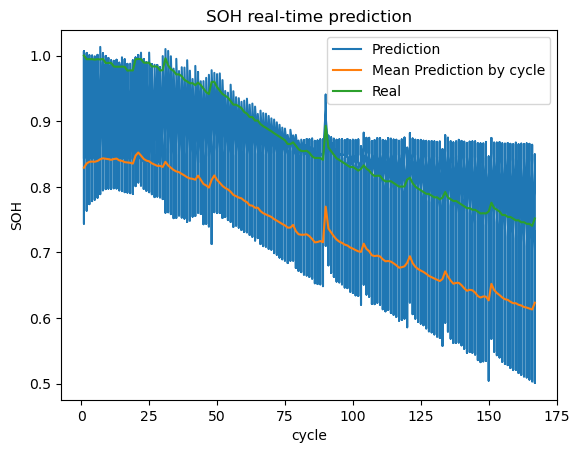

In [1154]:
b7_SOH_predict = model_b7_h3_mixed5.predict(b7_validation_inputs)

b7_SOH_validation = b7_inputs.loc[(b7_inputs['cycle'] >= 1), ['cycle']]
b7_SOH_validation['SOH_predict'] = b7_SOH_predict
b7_SOH_validation['SOH_target'] = b7_SOH_target.to_numpy()
b7_SOH_validation
rms = np.sqrt(mean_squared_error(b7_SOH_validation['SOH_predict'], b7_SOH_validation['SOH_target']))
print('Root Mean Square Error: ', rms)

b7_SOH_validation_mean = b7_SOH_validation.groupby(['cycle']).mean().reset_index()
rms = np.sqrt(mean_squared_error(b7_SOH_validation_mean['SOH_predict'], b7_SOH_validation_mean['SOH_target']))
print('Root Mean Square Error: ', rms)


plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_predict'])
plt.plot(b7_SOH_validation_mean['cycle'], b7_SOH_validation_mean['SOH_predict'])
plt.plot(b7_SOH_validation['cycle'], b7_SOH_validation['SOH_target'])

plt.xlabel("cycle")
plt.ylabel("SOH")
plt.legend(['Prediction', 'Mean Prediction by cycle', 'Real'])
plt.title('SOH real-time prediction')

In [1159]:
def custom_validation(model, SOH_target, validation_inputs, inputs):
    SOH_predict = model.predict(validation_inputs)

    SOH_validation = inputs.loc[(inputs['cycle'] >= 1), ['cycle']]
    SOH_validation['SOH_predict'] = SOH_predict
    SOH_validation['SOH_target'] = SOH_target.to_numpy()
    
    rms = np.sqrt(mean_squared_error(SOH_validation['SOH_predict'], SOH_validation['SOH_target']))
    print('Root Mean Square Error: ', rms)

    SOH_validation_mean = SOH_validation.groupby(['cycle']).mean().reset_index()
    rms = np.sqrt(mean_squared_error(SOH_validation_mean['SOH_predict'], SOH_validation_mean['SOH_target']))
    print('Root Mean Square Error: ', rms)


    plt.plot(SOH_validation['cycle'], SOH_validation['SOH_predict'])
    plt.plot(SOH_validation_mean['cycle'], SOH_validation_mean['SOH_predict'])
    plt.plot(SOH_validation['cycle'], SOH_validation['SOH_target'])

    plt.xlabel("cycle")
    plt.ylabel("SOH")
    plt.legend(['Prediction', 'Mean Prediction by cycle', 'Real'])
    plt.title('SOH real-time prediction')

1385/1385 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.08745470194121677
Root Mean Square Error:  0.06487952856447952


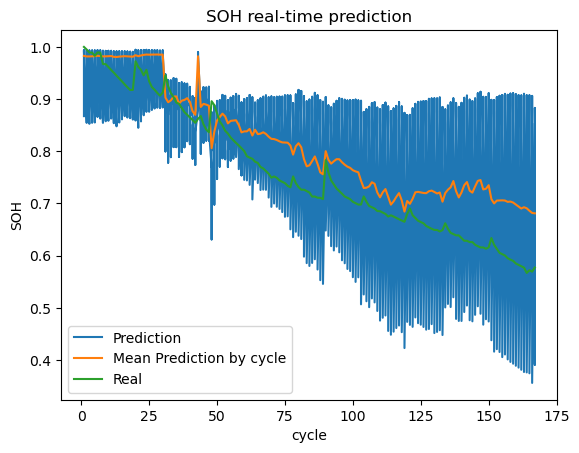

In [1167]:
custom_validation(model_b7_h3_mixed5, b6_SOH_target, b6_validation_inputs, b6_inputs)

In [1168]:
input_layer_b7_h3_mixed6 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_mixed6 = keras.layers.Dense(20, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(input_layer_b7_h3_mixed6)
hidden_layer2_b7_h3_mixed6 = keras.layers.Dense(20, activation='tanh', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer_b7_h3_mixed6)
hidden_layer3_b7_h3_mixed6 = keras.layers.Dense(20, activation='relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer2_b7_h3_mixed6)
output_layer_b7_h3_mixed6 = keras.layers.Dense(1, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer3_b7_h3_mixed6)
model_b7_h3_mixed6 = keras.Model(input_layer_b7_h3_mixed6, output_layer_b7_h3_mixed6)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed6.summary()

Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_56 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_165 (Dense)           (None, 20)                120       
                                                                 
 dense_166 (Dense)           (None, 20)                420       
                                                                 
 dense_167 (Dense)           (None, 20)                420       
                                                                 
 dense_168 (Dense)           (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [1187]:
my_train_b7_h3_mixed6 = custom_train(model_b7_h3_mixed6, optimizer, loss_function, metric)
loss_list, epoch_list = my_train_b7_h3_mixed6.train(b7_train_inputs, b7_train_SOH, 10000, 200, 0.001)

Training acc over epoch: 0.0221 Training loss (for one batch) at step 0: 0.0010 Time taken: 0.02s 
Training acc over epoch: 0.0188 Training loss (for one batch) at step 200: 0.0008 Time taken: 2.98s 
Training acc over epoch: 0.0169 Training loss (for one batch) at step 400: 0.0006 Time taken: 5.90s 
Training acc over epoch: 0.0157 Training loss (for one batch) at step 600: 0.0005 Time taken: 8.70s 


1385/1385 [==============================] - 1s 976us/step
Root Mean Square Error:  0.19634151458146057
Root Mean Square Error:  0.1810498213091659


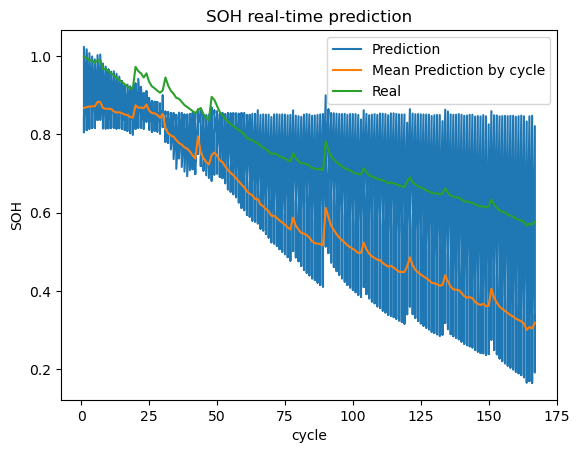

In [1188]:
custom_validation(model_b7_h3_mixed6, b6_SOH_target, b6_validation_inputs, b6_inputs)

In [1190]:
input_layer_b7_h3_mixed7 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_mixed7 = keras.layers.Dense(20, activation='tanh', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(input_layer_b7_h3_mixed7)
hidden_layer2_b7_h3_mixed7 = keras.layers.Dense(20, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer_b7_h3_mixed7)
hidden_layer3_b7_h3_mixed7 = keras.layers.Dense(20, activation='relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer2_b7_h3_mixed7)
output_layer_b7_h3_mixed7 = keras.layers.Dense(1, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer3_b7_h3_mixed7)
model_b7_h3_mixed7 = keras.Model(input_layer_b7_h3_mixed7, output_layer_b7_h3_mixed7)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed7.summary()

Model: "model_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_58 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_173 (Dense)           (None, 20)                120       
                                                                 
 dense_174 (Dense)           (None, 20)                420       
                                                                 
 dense_175 (Dense)           (None, 20)                420       
                                                                 
 dense_176 (Dense)           (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [1193]:
my_train_b7_h3_mixed7 = custom_train(model_b7_h3_mixed7, optimizer, loss_function, metric)
loss_list, epoch_list = my_train_b7_h3_mixed7.train(b7_train_inputs, b7_train_SOH, 10000, 200, 0.0005)

Training acc over epoch: 0.0224 Training loss (for one batch) at step 0: 0.0010 Time taken: 0.02s 
Training acc over epoch: 0.0208 Training loss (for one batch) at step 200: 0.0009 Time taken: 3.19s 
Training acc over epoch: 0.0197 Training loss (for one batch) at step 400: 0.0008 Time taken: 5.99s 
Training acc over epoch: 0.0180 Training loss (for one batch) at step 600: 0.0007 Time taken: 8.81s 
Training acc over epoch: 0.0171 Training loss (for one batch) at step 800: 0.0006 Time taken: 11.62s 
Training acc over epoch: 0.0164 Training loss (for one batch) at step 1000: 0.0006 Time taken: 14.46s 
Training acc over epoch: 0.0160 Training loss (for one batch) at step 1200: 0.0005 Time taken: 17.53s 
Training acc over epoch: 0.0160 Training loss (for one batch) at step 1400: 0.0005 Time taken: 20.46s 


1385/1385 [==============================] - 1s 968us/step
Root Mean Square Error:  0.1816187203901278
Root Mean Square Error:  0.1684723005204981


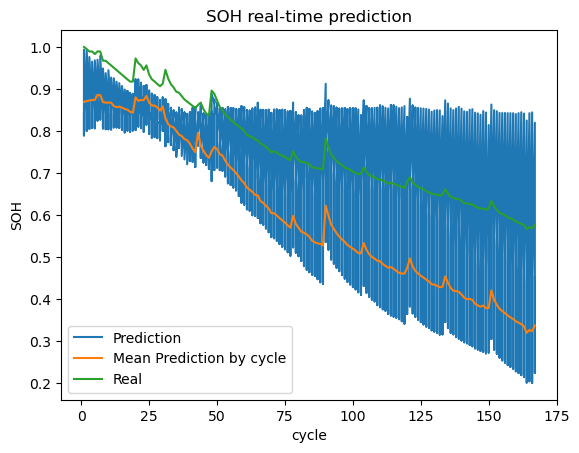

In [1194]:
custom_validation(model_b7_h3_mixed7, b6_SOH_target, b6_validation_inputs, b6_inputs)

In [1207]:
input_layer_b7_h3_mixed8 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_mixed8 = keras.layers.Dense(20, activation='tanh', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(input_layer_b7_h3_mixed8)
hidden_layer2_b7_h3_mixed8 = keras.layers.Dense(20, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer_b7_h3_mixed8)
hidden_layer3_b7_h3_mixed8 = keras.layers.Dense(20, activation='relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer2_b7_h3_mixed8)
output_layer_b7_h3_mixed8 = keras.layers.Dense(1, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer3_b7_h3_mixed8)
model_b7_h3_mixed8 = keras.Model(input_layer_b7_h3_mixed8, output_layer_b7_h3_mixed8)
#optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
optimizer = tf.keras.optimizers.Adam(epsilon=1e-08)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed8.summary()

Model: "model_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_64 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_197 (Dense)           (None, 20)                120       
                                                                 
 dense_198 (Dense)           (None, 20)                420       
                                                                 
 dense_199 (Dense)           (None, 20)                420       
                                                                 
 dense_200 (Dense)           (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [1224]:
my_train_b7_h3_mixed8 = custom_train(model_b7_h3_mixed8, optimizer, loss_function, metric)
loss_list, epoch_list = my_train_b7_h3_mixed8.train(b7_train_inputs, b7_train_SOH, 1000, 200, 0.0005)

Training acc over epoch: 0.0222 Training loss (for one batch) at step 0: 0.0010 Time taken: 0.02s 
Training acc over epoch: 0.0210 Training loss (for one batch) at step 200: 0.0009 Time taken: 3.00s 
Training acc over epoch: 0.0198 Training loss (for one batch) at step 400: 0.0008 Time taken: 5.85s 
Training acc over epoch: 0.0187 Training loss (for one batch) at step 600: 0.0007 Time taken: 8.71s 
Training acc over epoch: 0.0178 Training loss (for one batch) at step 800: 0.0007 Time taken: 11.62s 


1385/1385 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.07700760856516366
Root Mean Square Error:  0.06644274087266523


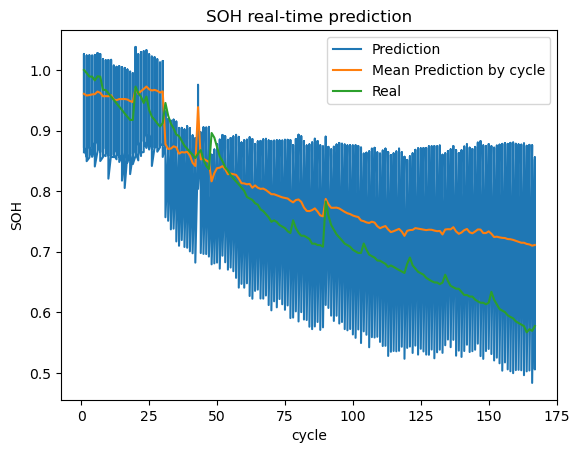

In [1211]:
custom_validation(model_b7_h3_mixed8, b6_SOH_target, b6_validation_inputs, b6_inputs)

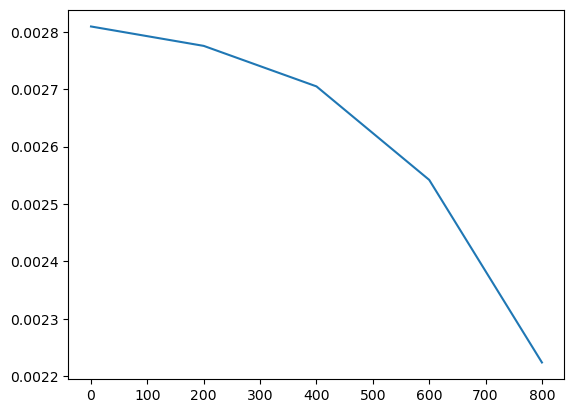

In [1219]:
plt.plot(epoch_list, loss_list)

1385/1385 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.06618757223233214
Root Mean Square Error:  0.04028234882246445


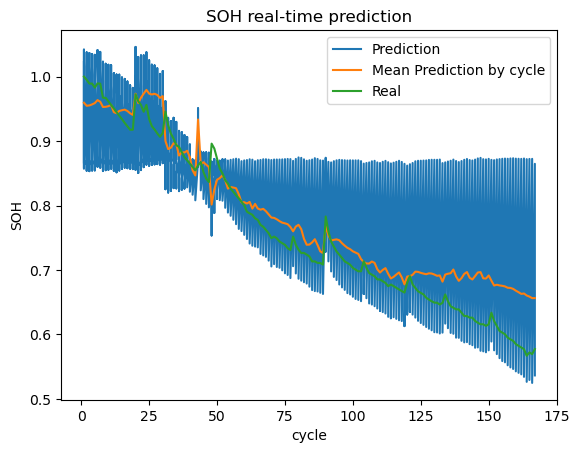

In [1217]:
custom_validation(model_b7_h3_mixed8, b6_SOH_target, b6_validation_inputs, b6_inputs)

1385/1385 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.15341556388856506
Root Mean Square Error:  0.1383621951356619


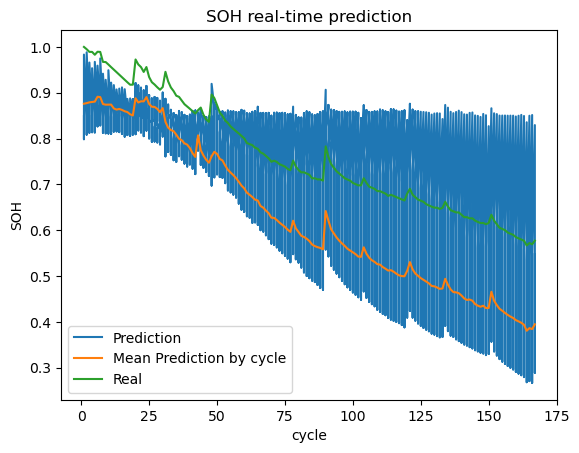

In [1225]:
custom_validation(model_b7_h3_mixed8, b6_SOH_target, b6_validation_inputs, b6_inputs)

In [1238]:
input_layer_b7_h3_mixed9 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_mixed9 = keras.layers.Dense(20, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(input_layer_b7_h3_mixed9)
hidden_layer2_b7_h3_mixed9 = keras.layers.Dense(20, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer_b7_h3_mixed9)
hidden_layer3_b7_h3_mixed9 = keras.layers.Dense(20, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer2_b7_h3_mixed9)
output_layer_b7_h3_mixed9 = keras.layers.Dense(1, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer3_b7_h3_mixed9)
model_b7_h3_mixed9 = keras.Model(input_layer_b7_h3_mixed9, output_layer_b7_h3_mixed9)
#optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
optimizer = tf.keras.optimizers.Adam(epsilon=1e-08)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed9.summary()

Model: "model_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_67 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_209 (Dense)           (None, 20)                120       
                                                                 
 dense_210 (Dense)           (None, 20)                420       
                                                                 
 dense_211 (Dense)           (None, 20)                420       
                                                                 
 dense_212 (Dense)           (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [1236]:
my_train_b7_h3_mixed9 = custom_train(model_b7_h3_mixed9, optimizer, loss_function, metric)
loss_list, epoch_list = my_train_b7_h3_mixed9.train(b7_train_inputs, b7_train_SOH, 1000, 200, 0.001)

Training acc over epoch: 0.0422 Training loss (for one batch) at step 0: 0.0029 Time taken: 0.02s 
Training acc over epoch: 0.0420 Training loss (for one batch) at step 200: 0.0029 Time taken: 2.86s 
Training acc over epoch: 0.0419 Training loss (for one batch) at step 400: 0.0029 Time taken: 5.64s 
Training acc over epoch: 0.0418 Training loss (for one batch) at step 600: 0.0029 Time taken: 8.69s 
Training acc over epoch: 0.0418 Training loss (for one batch) at step 800: 0.0029 Time taken: 11.46s 


1385/1385 [==============================] - 1s 937us/step
Root Mean Square Error:  0.09067929195432425
Root Mean Square Error:  0.08226403487511309


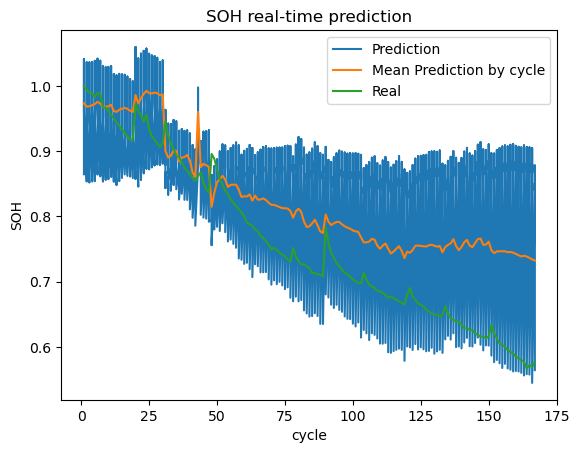

In [1237]:
custom_validation(model_b7_h3_mixed9, b6_SOH_target, b6_validation_inputs, b6_inputs)

In [1248]:

regularizer=tf.keras.regularizers.l2(0.01)

input_layer_b7_h3_mixed10 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_mixed10 = keras.layers.Dense(20, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(input_layer_b7_h3_mixed10)
hidden_layer2_b7_h3_mixed10 = keras.layers.Dense(20, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer_b7_h3_mixed10)
hidden_layer3_b7_h3_mixed10 = keras.layers.Dense(20, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer2_b7_h3_mixed10)
output_layer_b7_h3_mixed10 = keras.layers.Dense(1, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', activity_regularizer = regularizer)(hidden_layer3_b7_h3_mixed10)
model_b7_h3_mixed10 = keras.Model(input_layer_b7_h3_mixed10, output_layer_b7_h3_mixed10)
#optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
optimizer = tf.keras.optimizers.Adam(epsilon=1e-08)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed10.summary()


Model: "model_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_71 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_225 (Dense)           (None, 20)                120       
                                                                 
 dense_226 (Dense)           (None, 20)                420       
                                                                 
 dense_227 (Dense)           (None, 20)                420       
                                                                 
 dense_228 (Dense)           (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [1250]:
my_train_b7_h3_mixed10 = custom_train(model_b7_h3_mixed10, optimizer, loss_function, metric)
loss_list, epoch_list = my_train_b7_h3_mixed10.train(b7_train_inputs, b7_train_SOH, 10000, 200, 0.001)

Training acc over epoch: 0.0417 Training loss (for one batch) at step 0: 0.0029 Time taken: 0.02s 
Training acc over epoch: 0.0417 Training loss (for one batch) at step 200: 0.0029 Time taken: 3.07s 
Training acc over epoch: 0.0417 Training loss (for one batch) at step 400: 0.0029 Time taken: 6.14s 
Training acc over epoch: 0.0417 Training loss (for one batch) at step 600: 0.0029 Time taken: 9.24s 
Training acc over epoch: 0.0417 Training loss (for one batch) at step 800: 0.0029 Time taken: 12.24s 
Training acc over epoch: 0.0417 Training loss (for one batch) at step 1000: 0.0029 Time taken: 15.54s 
Training acc over epoch: 0.0417 Training loss (for one batch) at step 1200: 0.0029 Time taken: 18.70s 
Training acc over epoch: 0.0417 Training loss (for one batch) at step 1400: 0.0029 Time taken: 21.76s 
Training acc over epoch: 0.0417 Training loss (for one batch) at step 1600: 0.0029 Time taken: 24.83s 
Training acc over epoch: 0.0417 Training loss (for one batch) at step 1800: 0.0029 T

1385/1385 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.09125642137140319
Root Mean Square Error:  0.08294968406186748


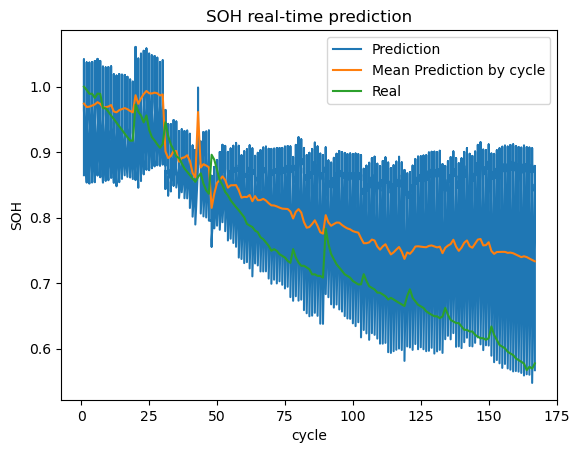

In [1252]:
custom_validation(model_b7_h3_mixed10, b6_SOH_target, b6_validation_inputs, b6_inputs)

In [1254]:
regularizer=tf.keras.regularizers.l2(0.1)


input_layer_b7_h3_mixed11 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_mixed11 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(input_layer_b7_h3_mixed11)
hidden_layer2_b7_h3_mixed11 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer_b7_h3_mixed11)
hidden_layer3_b7_h3_mixed11 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer2_b7_h3_mixed11)
output_layer_b7_h3_mixed11 = keras.layers.Dense(1, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer3_b7_h3_mixed11)
model_b7_h3_mixed11 = keras.Model(input_layer_b7_h3_mixed11, output_layer_b7_h3_mixed11)
#optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
optimizer = tf.keras.optimizers.Adam(epsilon=1e-08)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed11.summary()

Model: "model_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_73 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_233 (Dense)           (None, 20)                120       
                                                                 
 dense_234 (Dense)           (None, 20)                420       
                                                                 
 dense_235 (Dense)           (None, 20)                420       
                                                                 
 dense_236 (Dense)           (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [1261]:
my_train_b7_h3_mixed11 = custom_train(model_b7_h3_mixed11, optimizer, loss_function, metric)
loss_list, epoch_list = my_train_b7_h3_mixed11.train(b7_train_inputs, b7_train_SOH, 10000, 200, 0.0005)

Training acc over epoch: 0.0225 Training loss (for one batch) at step 0: 0.0010 Time taken: 0.03s 
Training acc over epoch: 0.0189 Training loss (for one batch) at step 200: 0.0007 Time taken: 3.17s 
Training acc over epoch: 0.0158 Training loss (for one batch) at step 400: 0.0006 Time taken: 6.15s 
Training acc over epoch: 0.0152 Training loss (for one batch) at step 600: 0.0005 Time taken: 9.07s 
Training acc over epoch: 0.0152 Training loss (for one batch) at step 800: 0.0005 Time taken: 11.96s 
Training acc over epoch: 0.0149 Training loss (for one batch) at step 1000: 0.0005 Time taken: 14.87s 
Training acc over epoch: 0.0149 Training loss (for one batch) at step 1200: 0.0005 Time taken: 17.74s 
Training acc over epoch: 0.0148 Training loss (for one batch) at step 1400: 0.0005 Time taken: 20.61s 
Training acc over epoch: 0.0147 Training loss (for one batch) at step 1600: 0.0005 Time taken: 23.72s 
Training acc over epoch: 0.0146 Training loss (for one batch) at step 1800: 0.0005 T

1385/1385 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.19287070071352116
Root Mean Square Error:  0.1655910129975995


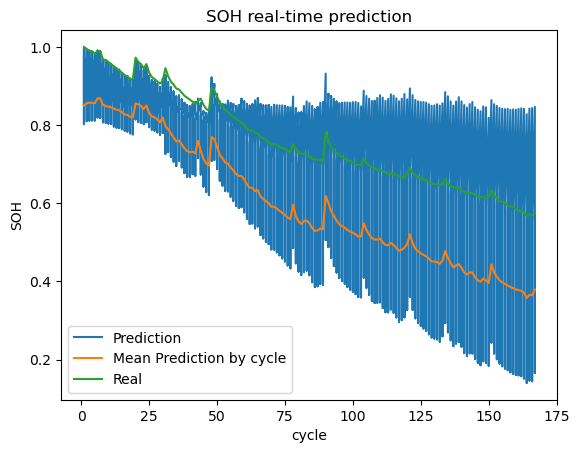

In [1262]:
custom_validation(model_b7_h3_mixed11, b6_SOH_target, b6_validation_inputs, b6_inputs)

In [1282]:
regularizer=tf.keras.regularizers.l2(0.1)


input_layer_b7_h3_mixed12 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_mixed12 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(input_layer_b7_h3_mixed12)
keras.layers.Dropout(rate=0.7)
hidden_layer2_b7_h3_mixed12 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer_b7_h3_mixed12)
keras.layers.Dropout(rate=0.7)
hidden_layer3_b7_h3_mixed12 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer2_b7_h3_mixed12)
keras.layers.Dropout(rate=0.5)
output_layer_b7_h3_mixed12 = keras.layers.Dense(1, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer3_b7_h3_mixed12)
model_b7_h3_mixed12 = keras.Model(input_layer_b7_h3_mixed12, output_layer_b7_h3_mixed12)
#optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
optimizer = tf.keras.optimizers.Adam(epsilon=1e-08)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed12.summary()

Model: "model_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_77 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_249 (Dense)           (None, 20)                120       
                                                                 
 dense_250 (Dense)           (None, 20)                420       
                                                                 
 dense_251 (Dense)           (None, 20)                420       
                                                                 
 dense_252 (Dense)           (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [1291]:
my_train_b7_h3_mixed12 = custom_train(model_b7_h3_mixed12, optimizer, loss_function, metric)
loss_list, epoch_list = my_train_b7_h3_mixed12.train(b7_train_inputs, b7_train_SOH, 10000, 200, 0.0008)

Training acc over epoch: 0.0231 Training loss (for one batch) at step 0: 0.0010 Time taken: 0.02s 


1385/1385 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.0725497655355857
Root Mean Square Error:  0.056480802279293356


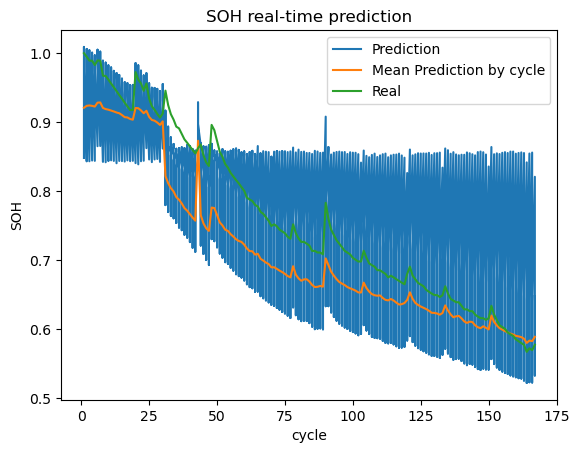

In [1292]:
custom_validation(model_b7_h3_mixed12, b6_SOH_target, b6_validation_inputs, b6_inputs)

In [1320]:
regularizer=tf.keras.regularizers.l2(0.1)


input_layer_b7_h3_mixed13 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_mixed13 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(input_layer_b7_h3_mixed13)
keras.layers.Dropout(rate=0.7)
hidden_layer2_b7_h3_mixed13 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer_b7_h3_mixed13)
keras.layers.Dropout(rate=0.7)
hidden_layer3_b7_h3_mixed13 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer2_b7_h3_mixed13)
keras.layers.Dropout(rate=0.5)
output_layer_b7_h3_mixed13 = keras.layers.Dense(1, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer3_b7_h3_mixed13)
model_b7_h3_mixed13 = keras.Model(input_layer_b7_h3_mixed13, output_layer_b7_h3_mixed13)
#optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
optimizer = tf.keras.optimizers.Adam(epsilon=1e-08)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
#loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
loss_function = tf.keras.losses.Huber()
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed13.summary()

Model: "model_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_80 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_261 (Dense)           (None, 20)                120       
                                                                 
 dense_262 (Dense)           (None, 20)                420       
                                                                 
 dense_263 (Dense)           (None, 20)                420       
                                                                 
 dense_264 (Dense)           (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [1323]:
my_train_b7_h3_mixed13 = custom_train(model_b7_h3_mixed13, optimizer, loss_function, metric)
loss_list, epoch_list = my_train_b7_h3_mixed13.train(b7_train_inputs, b7_train_SOH, 5000, 200, 0.0008)

Training acc over epoch: 0.0342 Training loss (for one batch) at step 0: 0.0010 Time taken: 0.02s 
Training acc over epoch: 0.0300 Training loss (for one batch) at step 200: 0.0008 Time taken: 3.40s 


1385/1385 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.05149505114961883
Root Mean Square Error:  0.03636460967732327


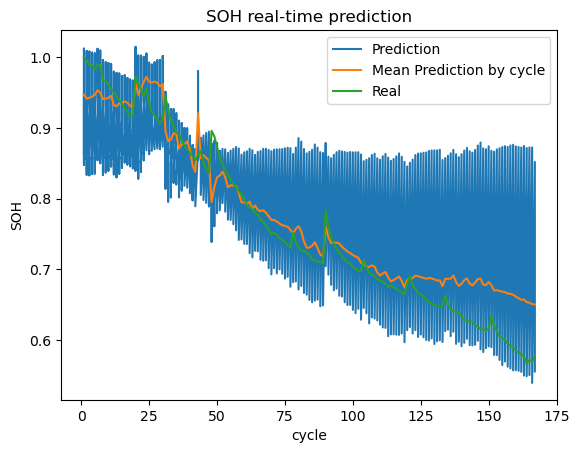

In [1327]:
custom_validation(model_b7_h3_mixed13, b6_SOH_target, b6_validation_inputs, b6_inputs)

In [1409]:
regularizer=tf.keras.regularizers.l2(0.1)


input_layer_b7_h3_mixed14 = keras.Input(shape=(b5_train_inputs.shape[1],))
keras.layers.Normalization(axis=None)
hidden_layer_b7_h3_mixed14 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(input_layer_b7_h3_mixed14)
keras.layers.Dropout(rate=0.7)
hidden_layer2_b7_h3_mixed14 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer_b7_h3_mixed14)
keras.layers.Dropout(rate=0.7)
hidden_layer3_b7_h3_mixed14 = keras.layers.Dense(20, activation = 'tanh', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer2_b7_h3_mixed14)
keras.layers.Dropout(rate=0.7)
output_layer_b7_h3_mixed14 = keras.layers.Dense(1, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer3_b7_h3_mixed14)
model_b7_h3_mixed14 = keras.Model(input_layer_b7_h3_mixed14, output_layer_b7_h3_mixed14)
#optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
optimizer = tf.keras.optimizers.Adam(epsilon=1e-08)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
#loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
loss_function = tf.keras.losses.Huber()
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed14.summary()

Model: "model_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_86 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_285 (Dense)           (None, 20)                120       
                                                                 
 dense_286 (Dense)           (None, 20)                420       
                                                                 
 dense_287 (Dense)           (None, 20)                420       
                                                                 
 dense_288 (Dense)           (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [1414]:
my_train_b7_h3_mixed14 = custom_train(model_b7_h3_mixed14, optimizer, loss_function, metric)
loss_list, epoch_list = my_train_b7_h3_mixed14.train(b7_train_inputs, b7_train_SOH, 1000, 200, 0.0004)

Training acc over epoch: 0.0287 Training loss (for one batch) at step 0: 0.0008 Time taken: 0.02s 
Training acc over epoch: 0.0283 Training loss (for one batch) at step 200: 0.0008 Time taken: 3.66s 
Training acc over epoch: 0.0283 Training loss (for one batch) at step 400: 0.0007 Time taken: 7.02s 
Training acc over epoch: 0.0281 Training loss (for one batch) at step 600: 0.0007 Time taken: 10.42s 
Training acc over epoch: 0.0279 Training loss (for one batch) at step 800: 0.0007 Time taken: 14.19s 


1385/1385 [==============================] - 1s 1ms/step
Root Mean Square Error:  0.13247930076772405
Root Mean Square Error:  0.09912538563716297


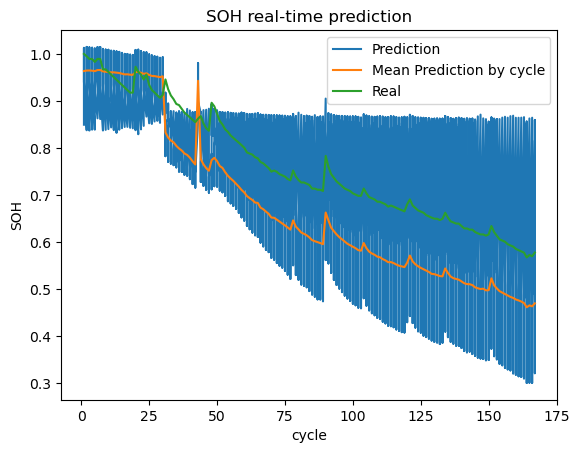

In [1415]:
custom_validation(model_b7_h3_mixed14, b6_SOH_target, b6_validation_inputs, b6_inputs)

In [1492]:
regularizer=tf.keras.regularizers.l2(0.1)


input_layer_b7_h3_mixed15 = keras.Input(shape=(b5_train_inputs.shape[1],))

hidden_layer_b7_h3_mixed15 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(input_layer_b7_h3_mixed15)
keras.layers.Dropout(rate=0.7)
hidden_layer2_b7_h3_mixed15 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer_b7_h3_mixed15)
keras.layers.Dropout(rate=0.7)
hidden_layer3_b7_h3_mixed15 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer2_b7_h3_mixed15)
keras.layers.Dropout(rate=0.5)
output_layer_b7_h3_mixed15 = keras.layers.Dense(1, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer3_b7_h3_mixed15)
model_b7_h3_mixed15 = keras.Model(input_layer_b7_h3_mixed15, output_layer_b7_h3_mixed15)
#optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
optimizer = tf.keras.optimizers.Adam(epsilon=1e-08, amsgrad = True)
#optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.01, rho=0.9, momentum = 0.9)

#loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
loss_function = tf.keras.losses.Huber()
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed15.summary()

Model: "model_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_110 (InputLayer)      [(None, 5)]               0         
                                                                 
 dense_381 (Dense)           (None, 20)                120       
                                                                 
 dense_382 (Dense)           (None, 20)                420       
                                                                 
 dense_383 (Dense)           (None, 20)                420       
                                                                 
 dense_384 (Dense)           (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [1523]:
my_train_b7_h3_mixed15 = custom_train(model_b7_h3_mixed15, optimizer, loss_function, metric)
loss_list, epoch_list = my_train_b7_h3_mixed15.train(b7_train_inputs, b7_train_SOH, 1000, 200, 0.0006)

Training acc over epoch: 0.0252 Training loss (for one batch) at step 0: 0.0006 Time taken: 0.03s 


1385/1385 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.04297606008387933
Root Mean Square Error:  0.03193998879761283


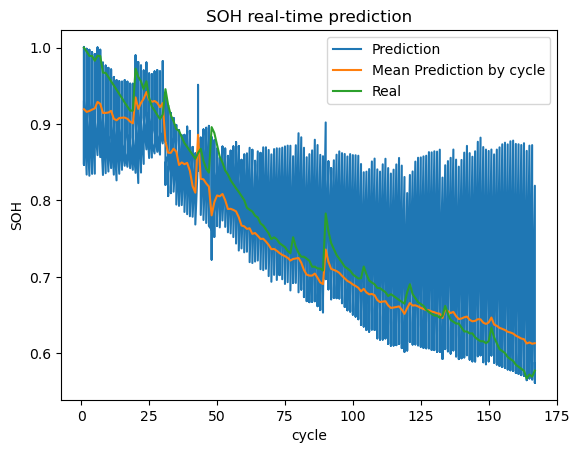

In [1524]:
custom_validation(model_b7_h3_mixed15, b6_SOH_target, b6_validation_inputs, b6_inputs)

In [1746]:
regularizer=tf.keras.regularizers.l2(1)


input_layer_b7_h3_mixed16 = keras.Input(shape=(b5_train_inputs.shape[1],))

hidden_layer_b7_h3_mixed16 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(input_layer_b7_h3_mixed16)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.7)
hidden_layer2_b7_h3_mixed16 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer_b7_h3_mixed16)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.7)
hidden_layer3_b7_h3_mixed16 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer2_b7_h3_mixed16)
keras.layers.BatchNormalization()
keras.layers.Dropout(rate=0.5)
output_layer_b7_h3_mixed16 = keras.layers.Dense(1, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer3_b7_h3_mixed16)
model_b7_h3_mixed16= keras.Model(input_layer_b7_h3_mixed16, output_layer_b7_h3_mixed16)
#optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
optimizer = tf.keras.optimizers.Adam(epsilon=1e-08, amsgrad = True)
#optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.01, rho=0.9, momentum = 0.9)

#loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
loss_function = tf.keras.losses.Huber()
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed16.summary()

Model: "model_115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_117 (InputLayer)      [(None, 5)]               0         
                                                                 
 dense_409 (Dense)           (None, 20)                120       
                                                                 
 dense_410 (Dense)           (None, 20)                420       
                                                                 
 dense_411 (Dense)           (None, 20)                420       
                                                                 
 dense_412 (Dense)           (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [1757]:
my_train_b7_h3_mixed16 = custom_train(model_b7_h3_mixed16, optimizer, loss_function, metric)
loss_list, epoch_list = my_train_b7_h3_mixed16.train(b7_train_inputs, b7_train_SOH, 1000, 200, 0.0001)

Training acc over epoch: 0.0381 Training loss (for one batch) at step 0: 0.0012 Time taken: 0.03s 
Training acc over epoch: 0.0370 Training loss (for one batch) at step 200: 0.0012 Time taken: 3.87s 
Training acc over epoch: 0.0351 Training loss (for one batch) at step 400: 0.0010 Time taken: 7.39s 
Training acc over epoch: 0.0327 Training loss (for one batch) at step 600: 0.0010 Time taken: 11.00s 
Training acc over epoch: 0.0294 Training loss (for one batch) at step 800: 0.0008 Time taken: 14.53s 


1408/1408 [==============================] - 2s 1ms/step
Root Mean Square Error:  0.08514820465871284
Root Mean Square Error:  0.07645270325638513


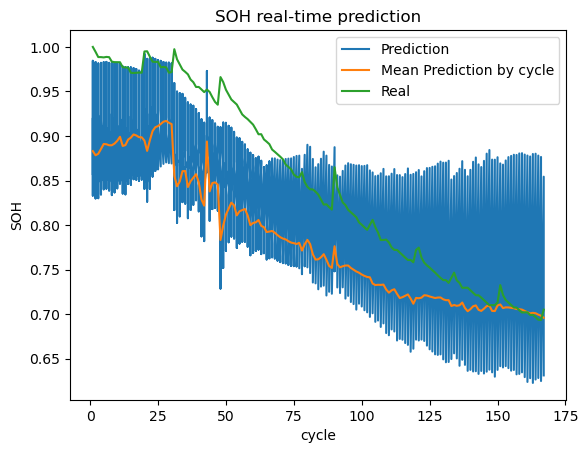

In [1758]:
custom_validation(model_b7_h3_mixed16, b5_SOH_target, b5_validation_inputs, b5_inputs)

In [ ]:
def Model(X_train, Y_train, learning_rate=0.3, num_iterations=30000, lambd=0., keep_prob=1.):
    tf.random.set_seed(2)
    initializer=tf.initializers.random_normal(0.0, 1.0, seed=1)
 
    layers_dims = [20, 3, 1]
    n_layers = len(layers_dims)
 
    # input -> linear(20) -> relu -> dropout -> linear(3) -> relu -> dropout -> output -> sigmoid 
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],))
    ])
 
    regularizer=tf.keras.regularizers.l2(lambd)
 
    for i in range(n_layers):
        if i != n_layers-1:
            model.add(tf.keras.layers.Dense(layers_dims[i],
                                             activation='relu',
                                             kernel_initializer=initializer,
                                             kernel_regularizer=regularizer))
 
            if keep_prob != 1.:
                model.add(tf.keras.layers.Dropout(1-keep_prob, seed=2))
        else:
            model.add(tf.keras.layers.Dense(layers_dims[i],
                                             activation='sigmoid',
                                             kernel_initializer=initializer,
                                             kernel_regularizer=regularizer))a

In [1247]:
regularizer=tf.keras.regularizers.l2(0.1)


input_layer_b7_h3_mixed11 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_mixed11 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(input_layer_b7_h3_mixed11)
hidden_layer2_b7_h3_mixed11 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer_b7_h3_mixed11)
hidden_layer3_b7_h3_mixed11 = keras.layers.Dense(20, activation = 'relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer2_b7_h3_mixed11)
output_layer_b7_h3_mixed11 = keras.layers.Dense(1, activity_regularizer = 'regularizer', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros', kernel_regularizer=regularizer)(hidden_layer3_b7_h3_mixed11)
model_b7_h3_mixed11 = keras.Model(input_layer_b7_h3_mixed11, output_layer_b7_h3_mixed11)
#optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
optimizer = tf.keras.optimizers.Adam(epsilon=1e-08)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed11.summary()

Model: "model_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_70 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_221 (Dense)           (None, 20)                120       
                                                                 
 dense_222 (Dense)           (None, 20)                420       
                                                                 
 dense_223 (Dense)           (None, 20)                420       
                                                                 
 dense_224 (Dense)           (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [ ]:
keras.layers.BatchNormalization

In [ ]:
loss=tf.keras.losses.KLDivergence()

In [ ]:
#my_train_b7_h3_mixed11 = custom_train(model_b7_h3_mixed10, optimizer, loss_function, metric)
#loss_list, epoch_list = my_train_b7_h3_mixed10.train(b7_train_inputs, b7_train_SOH, 10000, 200, 0.001)

In [ ]:
def Model(X_train, Y_train, X_test, Y_test, learning_rate=0.3, num_iterations=30000, lambd=0., keep_prob=1.):
    tf.random.set_seed(2)
    initializer=tf.initializers.random_normal(0.0, 1.0, seed=1)
 
    layers_dims = [20, 3, 1]
    n_layers = len(layers_dims)
 
    # input -> linear(20) -> relu -> dropout -> linear(3) -> relu -> dropout -> output -> sigmoid 
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],))
    ])
 
    regularizer=tf.keras.regularizers.l2(lambd)
 
    for i in range(n_layers):
        if i != n_layers-1:
            model.add(tf.keras.layers.Dense(layers_dims[i],
                                             activation='relu',
                                             kernel_initializer=initializer,
                                             kernel_regularizer=regularizer))
 
            if keep_prob != 1.:
                model.add(tf.keras.layers.Dropout(1-keep_prob, seed=2))
        else:
            model.add(tf.keras.layers.Dense(layers_dims[i],
                                             activation='sigmoid',
                                             kernel_initializer=initializer,
                                             kernel_regularizer=regularizer))

In [ ]:
class model_factory:
    
    def __init__(self, optimizer_fn, loss_fn, metric_fn):
        self.model
        self.train
        self.optimizer = optimizer_fn
        self.loss_fn = loss_fn
        self.metrics = metric_fn
        self.train = custom_train(model_b7_h3_mixed5, optimizer, loss_function, metric)
        
        input_layer_b7_h3_mixed5 = keras.Input(shape=(b5_train_inputs.shape[1],))
hidden_layer_b7_h3_mixed5 = keras.layers.Dense(10, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(input_layer_b7_h3_mixed5)
hidden_layer2_b7_h3_mixed5 = keras.layers.Dense(10, activation='tanh', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer_b7_h3_mixed5)
hidden_layer3_b7_h3_mixed5 = keras.layers.Dense(10, activation='relu', use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer2_b7_h3_mixed5)
output_layer_b7_h3_mixed5 = keras.layers.Dense(1, use_bias = True, kernel_initializer = 'random_normal', bias_initializer = 'zeros')(hidden_layer3_b7_h3_mixed5)
model_b7_h3_mixed5 = keras.Model(input_layer_b7_h3_mixed5, output_layer_b7_h3_mixed5)
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss_function = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metric = tf.keras.metrics.MeanAbsoluteError()
model_b7_h3_mixed5.summary()

In [1023]:
#model = Sequential()
#model.add(Dense(8, activation='relu', input_dim=train_dataset.shape[1]))
#model.add(Dense(8, activation='relu'))
#model.add(Dense(8, activation='relu'))a
#model.add(Dropout(rate=0.25))
#model.add(Dense(1))
model.summary()
model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_50 (Dense)            (None, 10)                60        
                                                                 
 dense_51 (Dense)            (None, 1)                 11        
                                                                 
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


NameError: name 'Adam' is not defined

In [1024]:
loss_list, epoch_list = my_train.train(b5_train_inputs, b5_train_SOH, 2000, 200, 0.001)

Training acc over epoch: 0.0860 Training loss (for one batch) at step 0: 0.0159 Time taken: 0.01s 
Training acc over epoch: 0.0853 Training loss (for one batch) at step 200: 0.0157 Time taken: 2.84s 
Training acc over epoch: 0.0846 Training loss (for one batch) at step 400: 0.0155 Time taken: 5.53s 
Training acc over epoch: 0.0840 Training loss (for one batch) at step 600: 0.0153 Time taken: 8.10s 
Training acc over epoch: 0.0835 Training loss (for one batch) at step 800: 0.0151 Time taken: 10.62s 
Training acc over epoch: 0.0831 Training loss (for one batch) at step 1000: 0.0150 Time taken: 13.04s 
Training acc over epoch: 0.0828 Training loss (for one batch) at step 1200: 0.0148 Time taken: 15.50s 
Training acc over epoch: 0.0824 Training loss (for one batch) at step 1400: 0.0147 Time taken: 17.93s 
Training acc over epoch: 0.0820 Training loss (for one batch) at step 1600: 0.0145 Time taken: 20.41s 
Training acc over epoch: 0.0817 Training loss (for one batch) at step 1800: 0.0144 T

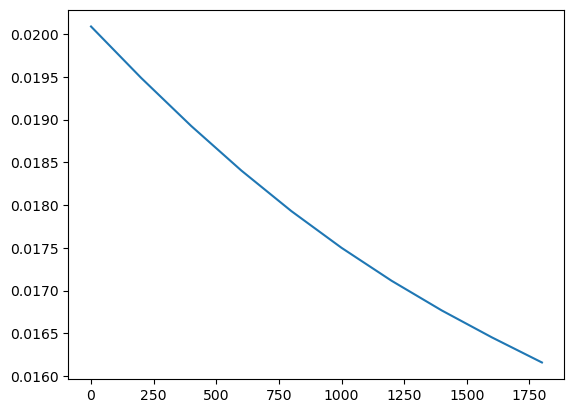

In [1006]:
plt.plot(epoch_list, loss_list)

In [ ]:
dis_ele['SoH']=(dis_ele['capacity'])/C

def load_data(battery):
  mat = loadmat('nasa_data/' + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]


In [65]:
attrib=['cycle', 'datetime', 'capacity']
capacity

cycle  ambient_temperature            datetime  capacity
0        1                   24 2008-04-02 15:25:41  1.856487
1        2                   24 2008-04-02 19:43:48  1.846327
2        3                   24 2008-04-03 00:01:06  1.835349
3        4                   24 2008-04-03 04:16:37  1.835263
4        5                   24 2008-04-03 08:33:25  1.834646
..     ...                  ...                 ...       ...
163    164                   24 2008-05-26 10:44:38  1.293464
164    165                   24 2008-05-26 15:30:43  1.288003
165    166                   24 2008-05-26 20:21:04  1.287453
166    167                   24 2008-05-27 15:52:41  1.309015
167    168                   24 2008-05-27 20:45:42  1.325079

[168 rows x 4 columns]

In [63]:
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


In [7]:
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


Similarly to what has been done previously, a graph of the SoH is made for each cycle, the horizontal line represents the threshold of 70% in which the battery already fulfills its life cycle and it is advisable to make the change.

Text(0.5, 1.0, 'Discharge B0005')

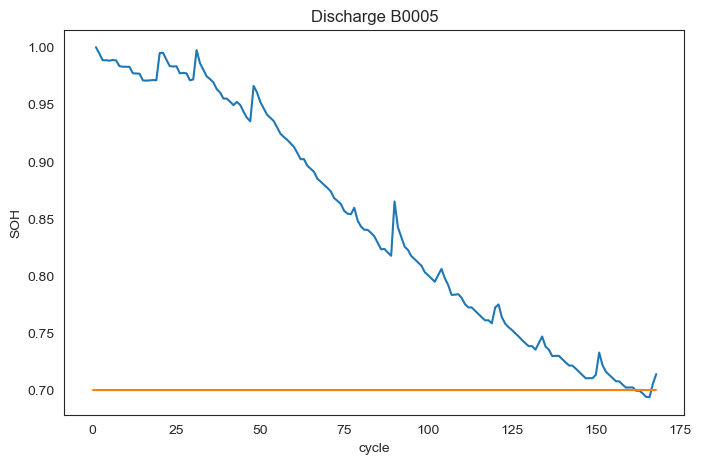

In [8]:
plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

# Training phase for calculating SoH
The dataset is prepared in such a way that it can be used by Tensorflow in the training phase, for this, two structures are created corresponding to the input and output expected to be obtained. For the input data, the relevant characteristics of the dataset are filtered, which are:

* Battery capacity
* Voltage
* Current
* Temperature
* Charging voltage
* Charging current
* Instant of time (from the start of the download)

For the output data, the SoH of the battery is calculated and in both input and output cases, the values are normalized to a range of values between [0-1].

In [9]:
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(soh.shape)

(50285, 7)
(50285, 1)


Preparation of the model, 3 dense layers are used, and the parameters are used as they are in the paper: 3 dense layers and one dropout, and one of the ADAM type is used as optimizer

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [11]:
model = Sequential()
model.add(Dense(8, activation='relu', input_dim=train_dataset.shape[1]))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(1))
model.summary()
model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 64        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________


## The model is trained, 50 epochs are used for training

In [12]:
model.fit(x=train_dataset, y=soh.to_numpy(), batch_size=25, epochs=10)

Epoch 1/10
2012/2012 [==============================] - 8s 3ms/step - loss: 0.0818
Epoch 2/10
2012/2012 [==============================] - 6s 3ms/step - loss: 0.0259
Epoch 3/10
2012/2012 [==============================] - 6s 3ms/step - loss: 0.0254
Epoch 4/10
2012/2012 [==============================] - 7s 3ms/step - loss: 0.0252
Epoch 5/10
2012/2012 [==============================] - 6s 3ms/step - loss: 0.0250
Epoch 6/10
2012/2012 [==============================] - 6s 3ms/step - loss: 0.0247
Epoch 7/10
2012/2012 [==============================] - 6s 3ms/step - loss: 0.0248
Epoch 8/10
2012/2012 [==============================] - 6s 3ms/step - loss: 0.0249
Epoch 9/10
2012/2012 [==============================] - 7s 3ms/step - loss: 0.0247
Epoch 10/10
2012/2012 [==============================] - 6s 3ms/step - loss: 0.0245


# Testing to test the SoH prediction model
To test the correctness of the model, the information of the same battery is loaded (B0006)

In [13]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.

A table is created containing the real SoH and the SoH predicted by the network and the root of the mean square error is calculated.

In [14]:
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
soh_pred = model.predict(sc.fit_transform(dataset_val[attrib]))
print(soh_pred.shape)

C = dataset_val['capacity'][0]
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH'] = soh_pred
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
print('Root Mean Square Error: ', rms)

1572/1572 [==============================] - 2s 1ms/step
(50285, 1)
   cycle       SoH    NewSoH
0      1  1.000000  0.988059
1      2  0.994990  0.984806
2      3  0.989185  0.980880
3      4  0.989165  0.980820
4      5  0.982898  0.976456
5      6  0.989467  0.980992
6      7  0.989075  0.980757
7      8  0.967304  0.965937
8      9  0.966997  0.965691
9     10  0.961625  0.961953
Root Mean Square Error:  0.07960843856272379


Finally both SoH are plotted to observe their differences

Text(0.5, 1.0, 'Discharge B0006')

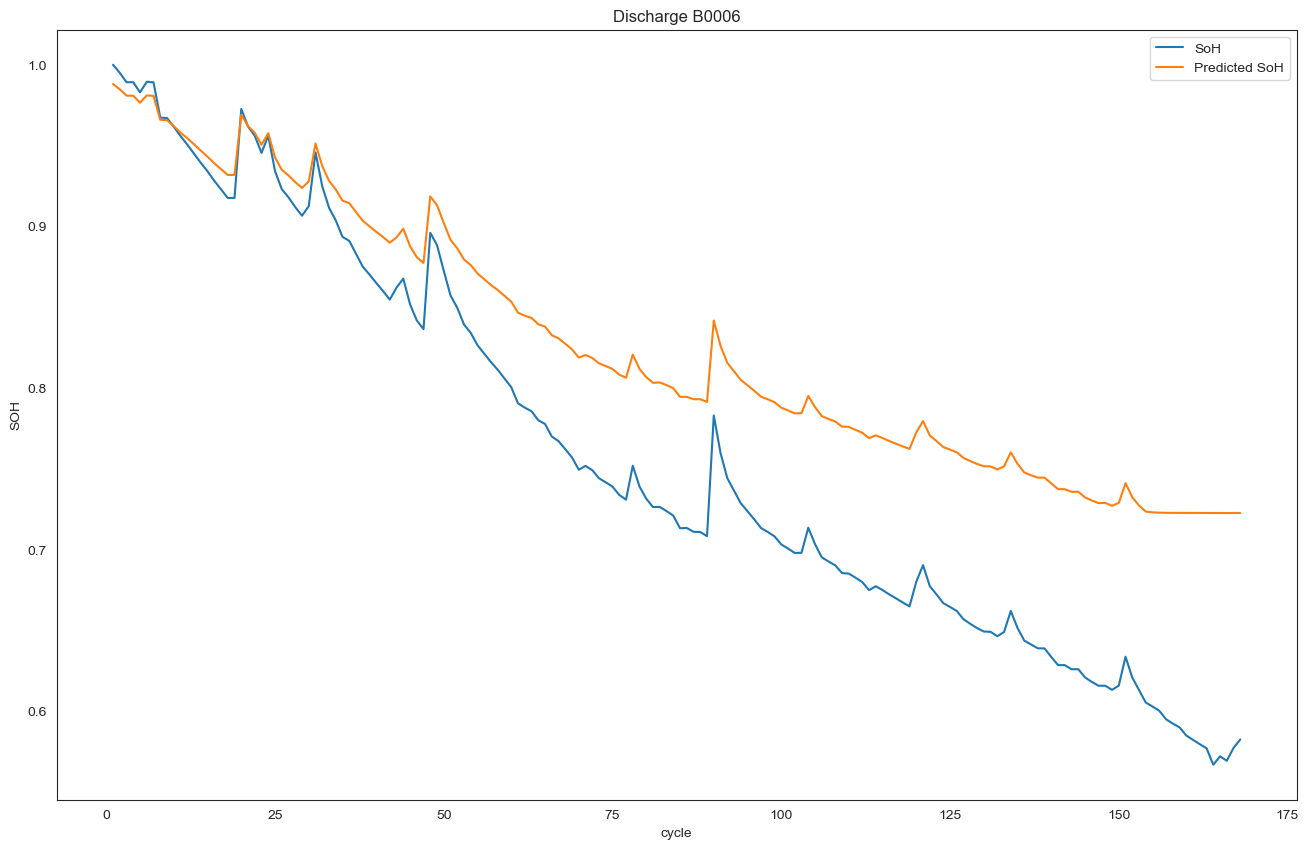

In [15]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

For the estimation of SoH, it can be seen that the data pattern is learned by the model correctly, as predicted by the theory, since the shape of the curves is almost identical. The SoH shown has the same behavior as expected in theory, which is corroborated with the root mean square error value of the graph in illustration 8, whose value of 9% is very similar to that found previously. This reaffirms the precision when making the prediction.

# RUL estimation
In the same way that was done for the estimation of SoH, the training and testing dataset is prepared, in this particular case the battery capacity data is used using the first data of the first 50 cycles to predict the capacity in the following cycles in such a way as to be able to know when the threshold of the battery is reached and estimate the remaining cycles to reach the End of Life of the battery

In [17]:
dataset_val, capacity_val = load_data('B0005')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
rows=['cycle','capacity']
dataset=dis_ele[rows]
data_train=dataset[(dataset['cycle']<50)]
data_set_train=data_train.iloc[:,1:2].values
data_test=dataset[(dataset['cycle']>=50)]
data_set_test=data_test.iloc[:,1:2].values

sc=MinMaxScaler(feature_range=(0,1))
data_set_train=sc.fit_transform(data_set_train)
data_set_test=sc.transform(data_set_test)

X_train=[]
y_train=[]
#take the last 10t to predict 10t+1
for i in range(10,49):
    X_train.append(data_set_train[i-10:i,0])
    y_train.append(data_set_train[i,0])
X_train,y_train=np.array(X_train),np.array(y_train)
 
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]


In this section the model is trained, based on the proposal of [2] and making use of LSTM-type networks instead of standard neural networks.

In [18]:
regress = Sequential()
regress.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1)))
regress.add(Dropout(0.3))
regress.add(LSTM(units=200, return_sequences=True))
regress.add(Dropout(0.3))
regress.add(LSTM(units=200, return_sequences=True))
regress.add(Dropout(0.3))
regress.add(LSTM(units=200))
regress.add(Dropout(0.3))
regress.add(Dense(units=1))
regress.compile(optimizer='adam',loss='mean_squared_error')
regress.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 200)           161600    
                                                                 
 dropout_1 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 200)           320800    
                                                                 
 dropout_2 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 200)           320800    
                                                                 
 dropout_3 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_3 (LSTM)               (None, 200)              

In [ ]:
regress.fit(X_train,y_train,epochs=200,batch_size=25)

In [19]:
print(len(data_test))
data_total=pd.concat((data_train['capacity'], data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)

119


In [20]:
X_test=[]
for i in range(10,129):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
pred=regress.predict(X_test)
print(pred.shape)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)
metrics.r2_score(tests,pred)

4/4 [==============================] - 7s 15ms/step
(119, 1)
Test RMSE: 0.293


-3.693337538672373

As can be seen, the mean RMSE is 0.05 (5%), which is very close to the values observed in the literature using this type of network.

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_17744\1198164500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['pre']=pred


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

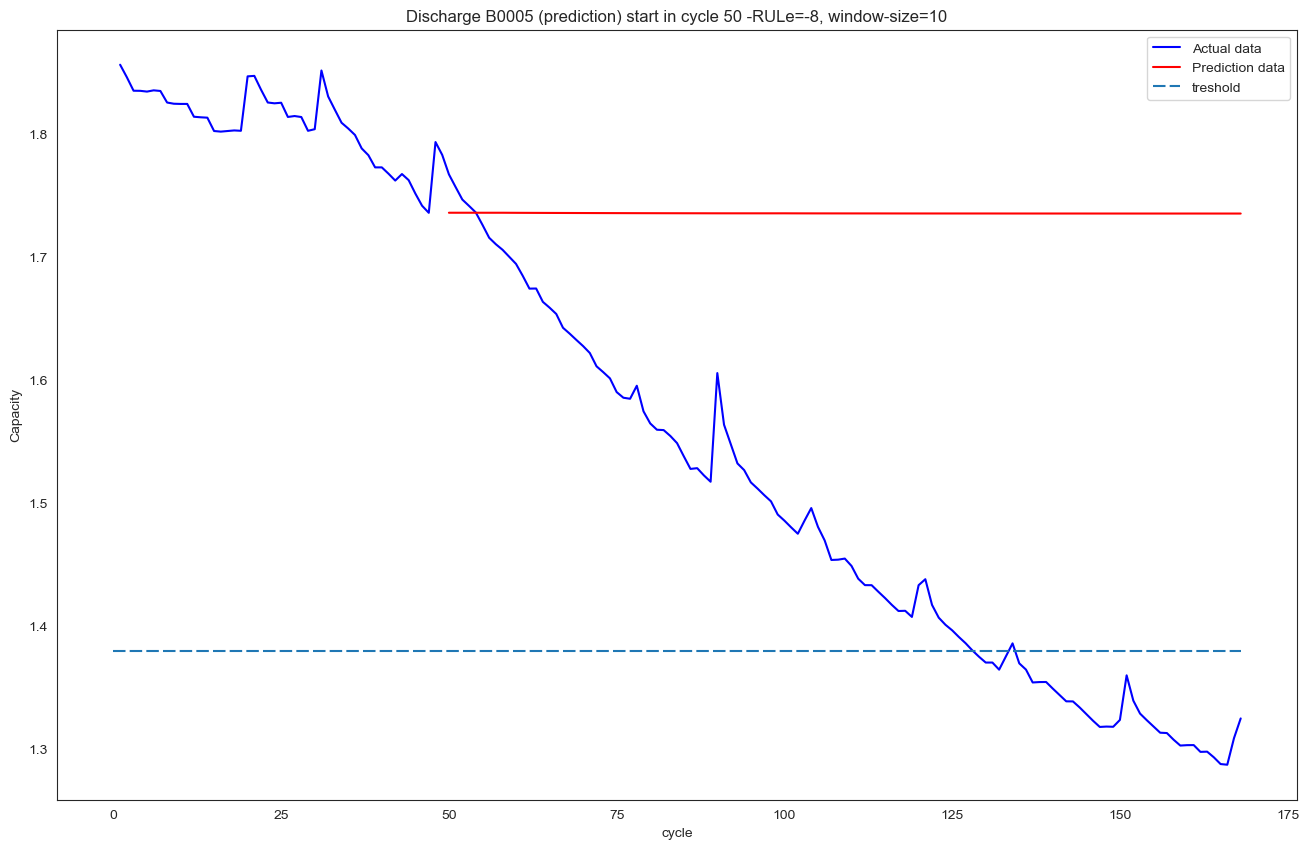

In [21]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

Finally, it can be seen in the graph that the capacity value and how it behaves over time is very close to the real value and supporting these data, the error in the estimation of the RUL was -8 which makes us understand that The model went ahead by 8 cycles to estimate that the battery reached its end of life.

In [22]:
pred=0
Afil=0
Pfil=0
a=data_test['capacity'].values
b=data_test['pre'].values
j=0
k=0
for i in range(len(a)):
    actual=a[i]
    
    if actual<=1.38:
        j=i
        Afil=j
        break
for i in range(len(a)):
    pred=b[i]
    if pred< 1.38:
        k=i
        Pfil=k
        break
print("The Actual fail at cycle number: "+ str(Afil+ln))
print("The prediction fail at cycle number: "+ str(Pfil+ln))
RULerror=Pfil-Afil
print("The error of RUL= "+ str(RULerror)+ " Cycle(s)")

The Actual fail at cycle number: 128
The prediction fail at cycle number: 49
The error of RUL= -79 Cycle(s)
